In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 31
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "ga-100"
number_of_opt_evaluations = 200
run_i = 9


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


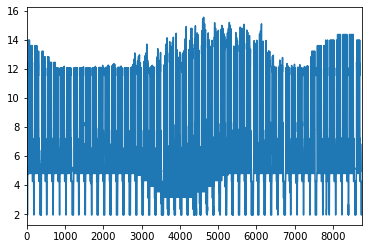

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.553950309753418 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.521691083908081 sec


ERROR:root:Finished Generation of Irradiance


0.0


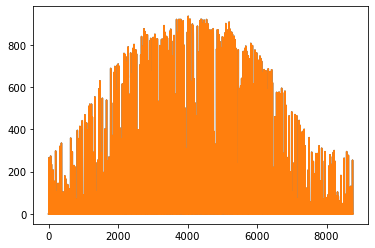

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4380266666412354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454826593399048 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4547195434570312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


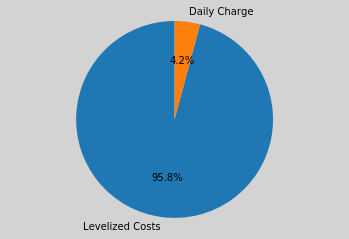

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (216.68995517250002, 179.86699423050365, 214.09080776677064, 11.234430001673704, 34.92525749379878, 2.3428297853732523, 0.5079652322319002, 0.7864498090306231, 0.8410888365956795)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 217
                                           a tilt of 11.2
                                           and a gcr of 0.508


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.395688772201538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 34.9
                                           and a gcr of 0.786


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.494962692260742 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 2.3
                                           and a gcr of 0.841


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2723965644836426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 312.442, 0.0]


ERROR:ga_logger:Cost: 3236.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,236 per year


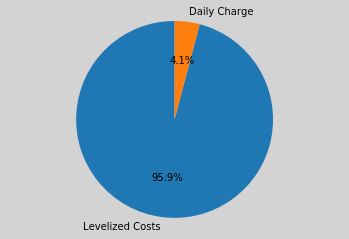

Total roof area of the  building: 599 m2
Total roof area used 397 m2
Percentage: 66.4%
succes
[[216.68995517250002, 179.86699423050365, 214.09080776677064, 11.234430001673704, 34.92525749379878, 2.3428297853732523, 0.5079652322319002, 0.7864498090306231, 0.8410888365956795, 3236.29, 312.442, 0.0, 312.442, 0.0, {'Levelized Costs': 3103.2349999999997, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600625765146, 61845.7, 397.281]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.81495306810717, 243.1834985900544, 155.47193423154766, 52.55552841154403, 39.44332056814856, 31.994379765806503, 0.5769980342738155, 0.21951132639181803, 0.413213432844873)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 52.6
                                           and a gcr of 0.577


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.458585739135742 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 243
                                           a tilt of 39.4
                                           and a gcr of 0.220


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3767807483673096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 32.0
                                           and a gcr of 0.413


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.345677614212036 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 247.416]


ERROR:ga_logger:Cost: 3900.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0212 /kWh
Total Cost of the system: $ 3,900 per year


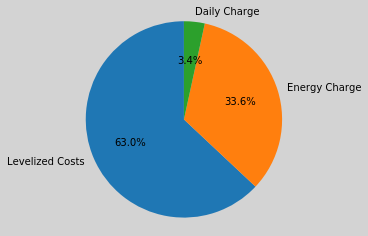

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[125.81495306810717, 243.1834985900544, 155.47193423154766, 52.55552841154403, 39.44332056814856, 31.994379765806503, 0.5769980342738155, 0.21951132639181803, 0.413213432844873, 3900.38, 247.416, 0.0, 0.0, 247.416, {'Levelized Costs': 2457.389, 'Energy Charge': 1309.949, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51391.21438999979, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.500785188176, 106.40181685355857, 173.96620625115003, 39.98794706892315, 54.406068182213886, 45.326705633545, 0.29536427665401205, 0.4955797212661744, 0.7356952472506184)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 187
                                           a tilt of 40.0
                                           and a gcr of 0.295


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.486114263534546 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 106
                                           a tilt of 54.4
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4032323360443115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 174
                                           a tilt of 45.3
                                           and a gcr of 0.736


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.45245361328125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [86.4078, 0.0, 225.281]


ERROR:ga_logger:Cost: 3228.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,229 per year


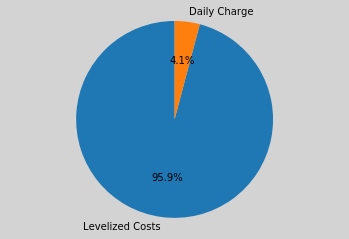

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[186.500785188176, 106.40181685355857, 173.96620625115003, 39.98794706892315, 54.406068182213886, 45.326705633545, 0.29536427665401205, 0.4955797212661744, 0.7356952472506184, 3228.81, 311.6888, 86.4078, 0.0, 225.281, {'Levelized Costs': 3095.755, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60308156345, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (143.98332899196708, 96.48469605012711, 234.00358871707786, 25.043416132705993, 9.382193292069953, 32.103598182380345, 0.39259458865804936, 0.46696586084680974, 0.6103975508351002)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 25.0
                                           and a gcr of 0.393


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.648829698562622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 9.4
                                           and a gcr of 0.467


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5073180198669434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 32.1
                                           and a gcr of 0.610


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5220961570739746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  34 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [70.7779, 0.0, 255.439]


ERROR:ga_logger:Cost: 3373.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,373 per year


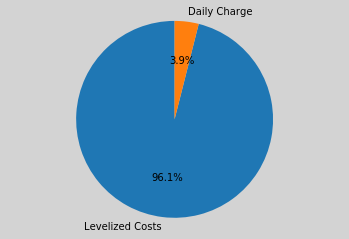

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[143.98332899196708, 96.48469605012711, 234.00358871707786, 25.043416132705993, 9.382193292069953, 32.103598182380345, 0.39259458865804936, 0.46696586084680974, 0.6103975508351002, 3373.11, 326.2169, 70.7779, 0.0, 255.439, {'Levelized Costs': 3240.052, 'Energy Charge': 0.01600000000013324, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60332887991, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (188.55657707462532, 262.75032956221344, 219.7205442637329, 10.821339296885593, 52.69067931576227, 38.677132929344765, 0.39466988955387267, 0.44225058422404406, 0.43637429625812607)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 10.8
                                           and a gcr of 0.395


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.525485992431641 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 52.7
                                           and a gcr of 0.442


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454308271408081 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 38.7
                                           and a gcr of 0.436


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.33333683013916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 218 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 261.284]


ERROR:ga_logger:Cost: 4029.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0210 /kWh
Total Cost of the system: $ 4,030 per year


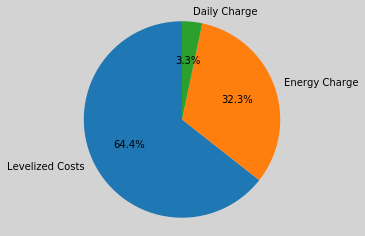

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[188.55657707462532, 262.75032956221344, 219.7205442637329, 10.821339296885593, 52.69067931576227, 38.677132929344765, 0.39466988955387267, 0.44225058422404406, 0.43637429625812607, 4029.77, 261.284, 0.0, 0.0, 261.284, {'Levelized Costs': 2595.127, 'Energy Charge': 1301.601, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51457.83673751778, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100.74463914987112, 247.96662415199668, 249.85824412034694, 40.478052403611954, 1.4475369151798603, 5.96302325164927, 0.8887230350236821, 0.5073897986948264, 0.5396692457551372)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 101
                                           a tilt of 40.5
                                           and a gcr of 0.889


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4155871868133545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 248
                                           a tilt of 1.4
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1379523277282715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.540


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3703129291534424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 323.133]


ERROR:ga_logger:Cost: 3559.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0035 /kWh
Total Cost of the system: $ 3,559 per year


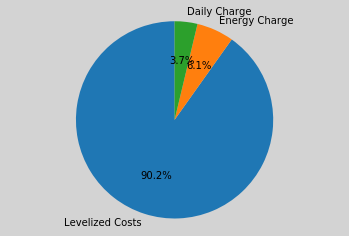

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[100.74463914987112, 247.96662415199668, 249.85824412034694, 40.478052403611954, 1.4475369151798603, 5.96302325164927, 0.8887230350236821, 0.5073897986948264, 0.5396692457551372, 3559.49, 323.133, 0.0, 0.0, 323.133, {'Levelized Costs': 3209.423, 'Energy Charge': 217.0250000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60113.689128607955, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (196.259674544969, 124.34893392334953, 92.09306589704761, 32.69473918525583, 54.06927948682077, 8.929917355845033, 0.33722823400697677, 0.5911234467382946, 0.8814994888898522)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 196
                                           a tilt of 32.7
                                           and a gcr of 0.337


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8721084594726562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 124
                                           a tilt of 54.1
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3779184818267822 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 8.9
                                           and a gcr of 0.881


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.363281488418579 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [126.418, 0.0, 197.358]


ERROR:ga_logger:Cost: 3348.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,349 per year


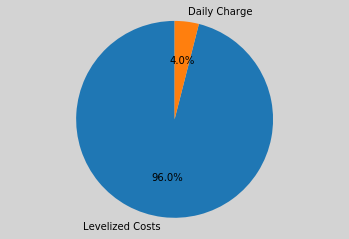

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[196.259674544969, 124.34893392334953, 92.09306589704761, 32.69473918525583, 54.06927948682077, 8.929917355845033, 0.33722823400697677, 0.5911234467382946, 0.8814994888898522, 3348.86, 323.776, 126.418, 0.0, 197.358, {'Levelized Costs': 3215.7999999999997, 'Energy Charge': 0.018000000000370164, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60116288002, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (209.50744903208493, 243.16255241718355, 217.84003848897018, 43.503519591658915, 44.43666524410414, 34.99961596910298, 0.7844291211503938, 0.3513385236630927, 0.8503949286535704)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 43.5
                                           and a gcr of 0.784


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6330740451812744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 243
                                           a tilt of 44.4
                                           and a gcr of 0.351


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5615007877349854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 218
                                           a tilt of 35.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5286433696746826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [338.147, 0.0, 0.0]


ERROR:ga_logger:Cost: 3491.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,492 per year


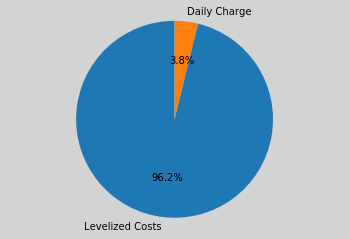

Total roof area of the  building: 599 m2
Total roof area used 431 m2
Percentage: 72.0%
succes
[[209.50744903208493, 243.16255241718355, 217.84003848897018, 43.503519591658915, 44.43666524410414, 34.99961596910298, 0.7844291211503938, 0.3513385236630927, 0.8503949286535704, 3491.6, 338.147, 338.147, 0.0, 0.0, {'Levelized Costs': 3358.5459999999994, 'Energy Charge': 0.012000000000568889, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60031660898, 61845.7, 431.073]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (95.17686250314316, 240.65867007109097, 227.45361923246494, 24.631127703137846, 1.7613044836021539, 22.02010268239008, 0.290063332192347, 0.25559520522226875, 0.22978414562662636)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 24.6
                                           and a gcr of 0.290


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.618846893310547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 241
                                           a tilt of 1.8
                                           and a gcr of 0.256


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5329861640930176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 227
                                           a tilt of 22.0
                                           and a gcr of 0.230


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.244786977767944 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  74 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [173.679, 0.0, 0.0]


ERROR:ga_logger:Cost: 5666.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0616 /kWh
Total Cost of the system: $ 5,666 per year


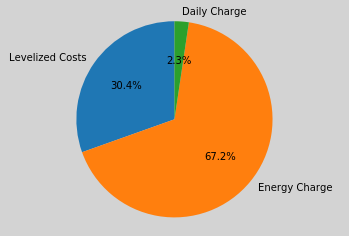

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[95.17686250314316, 240.65867007109097, 227.45361923246494, 24.631127703137846, 1.7613044836021539, 22.02010268239008, 0.290063332192347, 0.25559520522226875, 0.22978414562662636, 5666.14, 173.679, 173.679, 0.0, 0.0, {'Levelized Costs': 1725.0099999999998, 'Energy Charge': 3808.0880000000006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 31453.954019749915, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (251.6233626034853, 119.77639074413383, 182.78169097826665, 19.586376939891505, 50.52358559609928, 48.044166341803695, 0.4669280607093526, 0.4984649033305619, 0.6611960740810764)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 19.6
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5645534992218018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 50.5
                                           and a gcr of 0.498


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.456137180328369 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 48.0
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4432930946350098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.886]


ERROR:ga_logger:Cost: 3250.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,251 per year


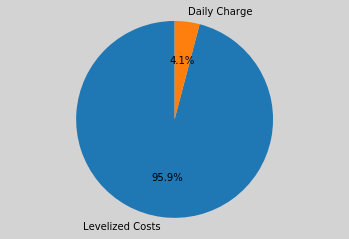

Total roof area of the  building: 599 m2
Total roof area used 475 m2
Percentage: 79.3%
succes
[[251.6233626034853, 119.77639074413383, 182.78169097826665, 19.586376939891505, 50.52358559609928, 48.044166341803695, 0.4669280607093526, 0.4984649033305619, 0.6611960740810764, 3250.63, 313.886, 0.0, 0.0, 313.886, {'Levelized Costs': 3117.5750000000003, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60284528334, 61845.7, 474.724]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (151.9201522417117, 172.02633877011374, 132.26378263523915, 49.036272927485854, 40.97534484129348, 40.85659910019976, 0.3690431939178487, 0.7994486290736831, 0.31873351392223737)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 49.0
                                           and a gcr of 0.369


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.83069372177124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 41.0
                                           and a gcr of 0.799


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.940619707107544 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 40.9
                                           and a gcr of 0.319


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4761996269226074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  28 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [139.15, 177.241, 0.0]


ERROR:ga_logger:Cost: 3275.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,276 per year


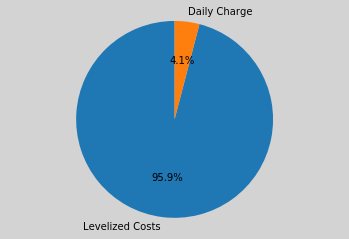

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[151.9201522417117, 172.02633877011374, 132.26378263523915, 49.036272927485854, 40.97534484129348, 40.85659910019976, 0.3690431939178487, 0.7994486290736831, 0.31873351392223737, 3275.52, 316.391, 139.15, 177.241, 0.0, {'Levelized Costs': 3142.4599999999996, 'Energy Charge': 0.01800000000031332, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60322542991, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (154.08376191340105, 136.40917230269474, 132.18793403309508, 3.0391681102658565, 33.79144566127709, 15.744531660092122, 0.2461891297977515, 0.38667014332896266, 0.22213916758143887)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 3.0
                                           and a gcr of 0.246


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.396223545074463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 136
                                           a tilt of 33.8
                                           and a gcr of 0.387


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4460268020629883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 15.7
                                           and a gcr of 0.222


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.431307315826416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s

ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 231.523, 0.0]


ERROR:ga_logger:Cost: 4365.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0313 /kWh
Total Cost of the system: $ 4,365 per year


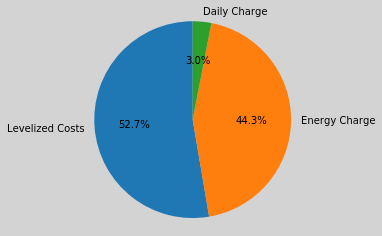

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[154.08376191340105, 136.40917230269474, 132.18793403309508, 3.0391681102658565, 33.79144566127709, 15.744531660092122, 0.2461891297977515, 0.38667014332896266, 0.22213916758143887, 4365.49, 231.523, 0.0, 231.523, 0.0, {'Levelized Costs': 2299.5379999999996, 'Energy Charge': 1932.9100000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 46419.45977385001, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (137.73393308981457, 176.19675924604167, 217.83303292081243, 11.04305794742425, 21.733896942453207, 22.908813569805208, 0.37411494429056985, 0.3825958105545531, 0.7814370108200188)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 11.0
                                           and a gcr of 0.374


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5284929275512695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 21.7
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.522003412246704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 218
                                           a tilt of 22.9
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7863314151763916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 151.483, 158.496]


ERROR:ga_logger:Cost: 3211.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,212 per year


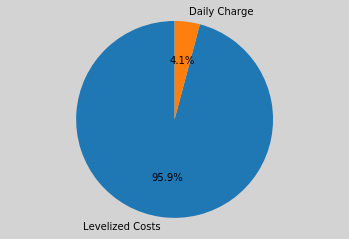

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[137.73393308981457, 176.19675924604167, 217.83303292081243, 11.04305794742425, 21.733896942453207, 22.908813569805208, 0.37411494429056985, 0.3825958105545531, 0.7814370108200188, 3211.83, 309.97900000000004, 0.0, 151.483, 158.496, {'Levelized Costs': 3078.781, 'Energy Charge': 0.006999999999948159, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60233522369, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (229.63296577095014, 261.51168496876824, 258.931756651683, 38.457356307940756, 53.96480792043249, 12.929378719250192, 0.25420029977316627, 0.7907451787741915, 0.7893966604836633)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 38.5
                                           and a gcr of 0.254


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.379958152770996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 54.0
                                           and a gcr of 0.791


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3316404819488525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 12.9
                                           and a gcr of 0.789


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8051397800445557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [63.2727, 0.0, 276.173]


ERROR:ga_logger:Cost: 3504.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,504 per year


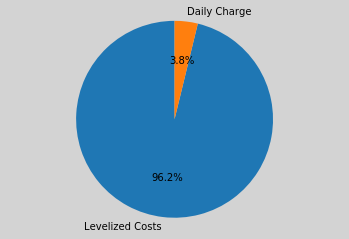

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[229.63296577095014, 261.51168496876824, 258.931756651683, 38.457356307940756, 53.96480792043249, 12.929378719250192, 0.25420029977316627, 0.7907451787741915, 0.7893966604836633, 3504.5, 339.4457, 63.2727, 0.0, 276.173, {'Levelized Costs': 3371.445, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602199557696, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (158.235855898943, 154.88522805341393, 243.37008226062494, 11.380051025817213, 6.540241850959566, 55.12776320795931, 0.38891778675364924, 0.8434712263255841, 0.5272066164739021)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 158
                                           a tilt of 11.4
                                           and a gcr of 0.389


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3485751152038574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 6.5
                                           and a gcr of 0.843


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.380988121032715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 243
                                           a tilt of 55.1
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3997080326080322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [161.145, 155.553, 0.0]


ERROR:ga_logger:Cost: 3278.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,279 per year


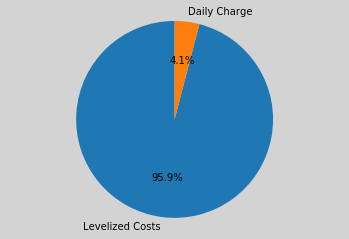

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[158.235855898943, 154.88522805341393, 243.37008226062494, 11.380051025817213, 6.540241850959566, 55.12776320795931, 0.38891778675364924, 0.8434712263255841, 0.5272066164739021, 3278.56, 316.698, 161.145, 155.553, 0.0, {'Levelized Costs': 3145.505, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59973975897, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (169.57515604522968, 150.7372577601058, 166.5459361746858, 13.370383369264687, 43.6542168144825, 23.66519619208367, 0.3169236392111012, 0.6806668573187538, 0.25490819276315935)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 13.4
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.609463930130005 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 151
                                           a tilt of 43.7
                                           and a gcr of 0.681


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5200626850128174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 23.7
                                           and a gcr of 0.255


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.499027967453003 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 270.242, 51.4243]


ERROR:ga_logger:Cost: 3327.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,328 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[169.57515604522968, 150.7372577601058, 166.5459361746858, 13.370383369264687, 43.6542168144825, 23.66519619208367, 0.3169236392111012, 0.6806668573187538, 0.25490819276315935, 3327.91, 321.66630000000004, 0.0, 270.242, 51.4243, {'Levelized Costs': 3194.8450000000003, 'Energy Charge': 0.022999999999797183, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60342261989, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (257.82404804779674, 167.27933832927926, 128.77101026474574, 43.366967830060915, 5.926213538299915, 7.022327858534286, 0.31374449220169137, 0.48699533766280284, 0.7148197425799259)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 43.4
                                           and a gcr of 0.314


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.592176675796509 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 5.9
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.473177909851074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 129
                                           a tilt of 7.0
                                           and a gcr of 0.715


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.45106840133667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 226.995, 94.8191]


ERROR:ga_logger:Cost: 3329.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,329 per year


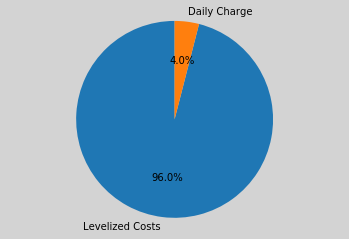

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[257.82404804779674, 167.27933832927926, 128.77101026474574, 43.366967830060915, 5.926213538299915, 7.022327858534286, 0.31374449220169137, 0.48699533766280284, 0.7148197425799259, 3329.38, 321.8141, 0.0, 226.995, 94.8191, {'Levelized Costs': 3196.315, 'Energy Charge': 0.023000000000365617, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60315253989, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115.00857882469013, 230.27052776519642, 120.43673918644711, 50.331190428161115, 24.679561181917943, 15.741437698313138, 0.36329025508290125, 0.7668024543764995, 0.8164792725959891)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 50.3
                                           and a gcr of 0.363


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5042593479156494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 24.7
                                           and a gcr of 0.767


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4657721519470215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 15.7
                                           and a gcr of 0.816


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3692665100097656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 334.849, 0.0]


ERROR:ga_logger:Cost: 3458.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,459 per year


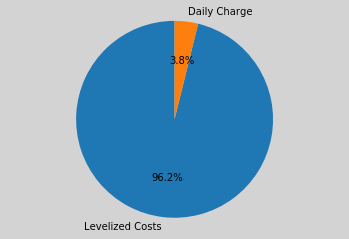

Total roof area of the  building: 599 m2
Total roof area used 437 m2
Percentage: 72.9%
succes
[[115.00857882469013, 230.27052776519642, 120.43673918644711, 50.331190428161115, 24.679561181917943, 15.741437698313138, 0.36329025508290125, 0.7668024543764995, 0.8164792725959891, 3458.84, 334.849, 0.0, 334.849, 0.0, {'Levelized Costs': 3325.784, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6007001928, 61845.7, 436.682]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.61517212799714, 234.61790904257, 224.5950422868141, 28.27904328927007, 48.173983331776306, 27.901238864959364, 0.5805648251673232, 0.37764960269610304, 0.7792660749919225)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 28.3
                                           and a gcr of 0.581


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.381540060043335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 48.2
                                           and a gcr of 0.378


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3959712982177734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 27.9
                                           and a gcr of 0.779


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4081532955169678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 126s


ERROR:ga_logger:panel relevance: [329.906, 0.0, 0.0]


ERROR:ga_logger:Cost: 3409.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,410 per year


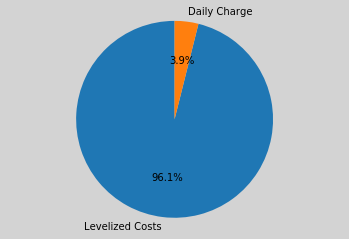

Total roof area of the  building: 599 m2
Total roof area used 568 m2
Percentage: 94.9%
succes
[[120.61517212799714, 234.61790904257, 224.5950422868141, 28.27904328927007, 48.173983331776306, 27.901238864959364, 0.5805648251673232, 0.37764960269610304, 0.7792660749919225, 3409.75, 329.906, 329.906, 0.0, 0.0, {'Levelized Costs': 3276.701, 'Energy Charge': 0.007000000000232376, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602785819945, 61845.7, 568.25]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (93.15833145249353, 194.9398804155075, 177.58332141571134, 36.51486223404982, 7.9330444185391285, 13.00132260545733, 0.7584709325188475, 0.5050083940100705, 0.2575078040392339)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 93
                                           a tilt of 36.5
                                           and a gcr of 0.758


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.546825885772705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 7.9
                                           and a gcr of 0.505


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.692945718765259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 13.0
                                           and a gcr of 0.258


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.378319501876831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 302.38, 0.0]


ERROR:ga_logger:Cost: 3497.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0058 /kWh
Total Cost of the system: $ 3,497 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[93.15833145249353, 194.9398804155075, 177.58332141571134, 36.51486223404982, 7.9330444185391285, 13.00132260545733, 0.7584709325188475, 0.5050083940100705, 0.2575078040392339, 3497.21, 302.38, 0.0, 302.38, 0.0, {'Levelized Costs': 3003.284, 'Energy Charge': 360.8839999999999, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58965.632422190356, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (110.98324699923386, 107.29517401938656, 223.87274624246734, 30.78784000026483, 24.873300790867965, 29.99921614832271, 0.8994716067041724, 0.5400819713614502, 0.26390803911001565)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 111
                                           a tilt of 30.8
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.508037567138672 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 107
                                           a tilt of 24.9
                                           and a gcr of 0.540


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5380780696868896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 224
                                           a tilt of 30.0
                                           and a gcr of 0.264


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.449256420135498 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  55 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [53.0626, 291.519, 0.0]


ERROR:ga_logger:Cost: 3555.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,556 per year


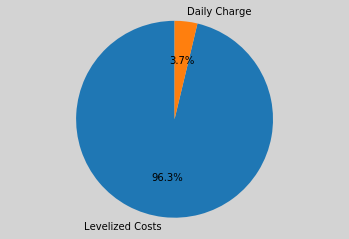

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[110.98324699923386, 107.29517401938656, 223.87274624246734, 30.78784000026483, 24.873300790867965, 29.99921614832271, 0.8994716067041724, 0.5400819713614502, 0.26390803911001565, 3555.51, 344.5816, 53.0626, 291.519, 0.0, {'Levelized Costs': 3422.4550000000004, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60003819994, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (192.13677642747393, 238.01433243539617, 197.49225933882263, 28.485850250462786, 20.68640157140017, 6.624300657662916, 0.25459894270794686, 0.6042582971315343, 0.6529572676681492)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 28.5
                                           and a gcr of 0.255


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8632311820983887 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 20.7
                                           and a gcr of 0.604


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.469644784927368 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 6.6
                                           and a gcr of 0.653


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.465016841888428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [48.0026, 0.0, 267.856]


ERROR:ga_logger:Cost: 3270.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,270 per year


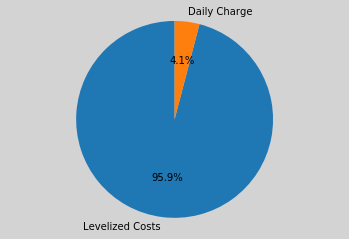

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[192.13677642747393, 238.01433243539617, 197.49225933882263, 28.485850250462786, 20.68640157140017, 6.624300657662916, 0.25459894270794686, 0.6042582971315343, 0.6529572676681492, 3270.23, 315.8586, 48.0026, 0.0, 267.856, {'Levelized Costs': 3137.17, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60122706657, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (123.57811894066143, 107.71910480860574, 226.10398607483538, 13.422747797410667, 36.41337323749245, 43.78079143493706, 0.8237397471173735, 0.542351360194489, 0.30432718870256664)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 13.4
                                           and a gcr of 0.824


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4038596153259277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 108
                                           a tilt of 36.4
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5970373153686523 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 43.8
                                           and a gcr of 0.304


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4727511405944824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 103 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [231.216, 0.0, 96.7976]


ERROR:ga_logger:Cost: 3390.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,391 per year


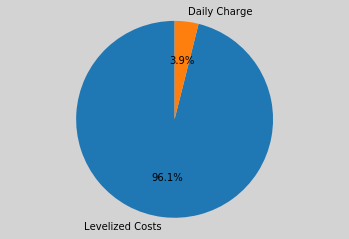

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[123.57811894066143, 107.71910480860574, 226.10398607483538, 13.422747797410667, 36.41337323749245, 43.78079143493706, 0.8237397471173735, 0.542351360194489, 0.30432718870256664, 3390.96, 328.0136, 231.216, 0.0, 96.7976, {'Levelized Costs': 3257.9, 'Energy Charge': 0.017999999999858574, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60020612005, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (182.902347951876, 119.13925248242788, 227.76603453927328, 47.34848958761205, 55.60006763455233, 6.051177527874154, 0.4546178095861258, 0.6414329695870133, 0.6514041234561285)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 47.3
                                           and a gcr of 0.455


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.502937078475952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 119
                                           a tilt of 55.6
                                           and a gcr of 0.641


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.387535572052002 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 228
                                           a tilt of 6.1
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.393369197845459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 225 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [180.308, 0.0, 131.679]


ERROR:ga_logger:Cost: 3231.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,232 per year


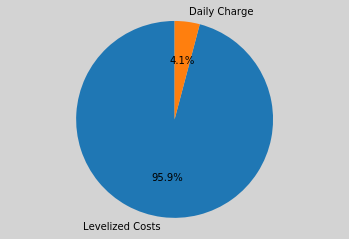

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[182.902347951876, 119.13925248242788, 227.76603453927328, 47.34848958761205, 55.60006763455233, 6.051177527874154, 0.4546178095861258, 0.6414329695870133, 0.6514041234561285, 3231.78, 311.98699999999997, 180.308, 0.0, 131.679, {'Levelized Costs': 3098.721, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60361091577, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.3721649083244, 207.07445898354598, 101.08221018133939, 40.62820944265554, 23.96562958578833, 43.524807194614006, 0.7948898997381135, 0.25834108177681714, 0.3403353264954625)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 40.6
                                           and a gcr of 0.795


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.464780330657959 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 207
                                           a tilt of 24.0
                                           and a gcr of 0.258


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4555439949035645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 43.5
                                           and a gcr of 0.340


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.546510934829712 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 195 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [267.185, 67.8489, 0.0]


ERROR:ga_logger:Cost: 3460.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,461 per year


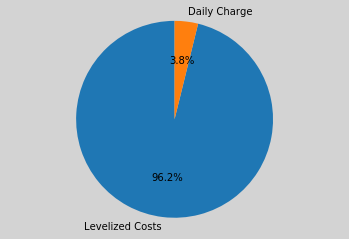

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[141.3721649083244, 207.07445898354598, 101.08221018133939, 40.62820944265554, 23.96562958578833, 43.524807194614006, 0.7948898997381135, 0.25834108177681714, 0.3403353264954625, 3460.68, 335.0339, 267.185, 67.8489, 0.0, {'Levelized Costs': 3327.6189999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60106750649, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (184.17316502681376, 203.8835733320679, 193.90781614554015, 32.36320643367782, 1.1405953622904828, 52.794568103342556, 0.3867938915538044, 0.5614720412601826, 0.4417065848285757)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 184
                                           a tilt of 32.4
                                           and a gcr of 0.387


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.559821605682373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 1.1
                                           and a gcr of 0.561


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9020471572875977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 52.8
                                           and a gcr of 0.442


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.442248582839966 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [9.40241, 322.539, 0.0]


ERROR:ga_logger:Cost: 3429.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,430 per year


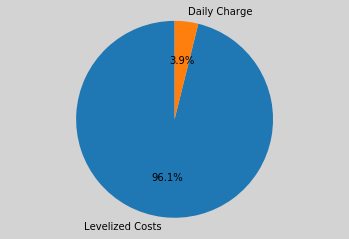

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[184.17316502681376, 203.8835733320679, 193.90781614554015, 32.36320643367782, 1.1405953622904828, 52.794568103342556, 0.3867938915538044, 0.5614720412601826, 0.4417065848285757, 3429.97, 331.94140999999996, 9.40241, 322.539, 0.0, {'Levelized Costs': 3296.92, 'Energy Charge': 0.007999999999924512, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59970008996, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (219.09237760247737, 204.04752309719967, 254.7897644091769, 46.382792633708625, 34.028706958388405, 15.914869889219041, 0.33986874913661513, 0.6751819479383012, 0.5065706644052418)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 219
                                           a tilt of 46.4
                                           and a gcr of 0.340


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.551565647125244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 34.0
                                           and a gcr of 0.675


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5172441005706787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 15.9
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.538785934448242 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 216 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 312.848, 0.0]


ERROR:ga_logger:Cost: 3240.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,240 per year


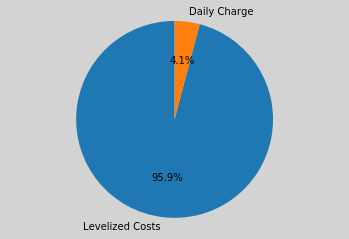

Total roof area of the  building: 599 m2
Total roof area used 463 m2
Percentage: 77.4%
succes
[[219.09237760247737, 204.04752309719967, 254.7897644091769, 46.382792633708625, 34.028706958388405, 15.914869889219041, 0.33986874913661513, 0.6751819479383012, 0.5065706644052418, 3240.32, 312.848, 0.0, 312.848, 0.0, {'Levelized Costs': 3107.266, 'Energy Charge': 0.012000000000227828, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600812130244, 61845.7, 463.353]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (192.04325866684246, 134.051675264102, 133.30161995504824, 54.87960959624364, 44.88113949316904, 7.651558359661808, 0.46132170530559385, 0.3727272961674928, 0.41209639022851585)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 54.9
                                           and a gcr of 0.461


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.481659412384033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 134
                                           a tilt of 44.9
                                           and a gcr of 0.373


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6070024967193604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 133
                                           a tilt of 7.7
                                           and a gcr of 0.412


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4196009635925293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [276.222, 0.0, 0.0]


ERROR:ga_logger:Cost: 3869.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0161 /kWh
Total Cost of the system: $ 3,869 per year


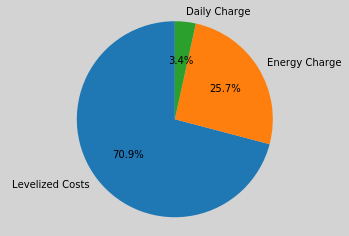

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[192.04325866684246, 134.051675264102, 133.30161995504824, 54.87960959624364, 44.88113949316904, 7.651558359661808, 0.46132170530559385, 0.3727272961674928, 0.41209639022851585, 3869.39, 276.222, 276.222, 0.0, 0.0, {'Levelized Costs': 2743.4919999999997, 'Energy Charge': 992.8560000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53921.8775967702, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115.5627345449676, 105.44739211845524, 234.7915586359564, 25.16662243396137, 17.022717196111564, 6.174975910743841, 0.7612613628364211, 0.5901226036143161, 0.8091369079332764)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 25.2
                                           and a gcr of 0.761


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.444429397583008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 17.0
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3902509212493896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.2
                                           and a gcr of 0.809


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.518768310546875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 190 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 329.849]


ERROR:ga_logger:Cost: 3409.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,409 per year


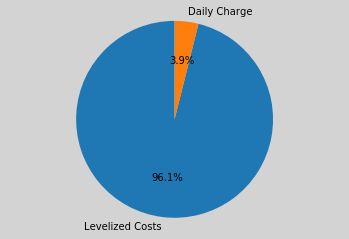

Total roof area of the  building: 599 m2
Total roof area used 408 m2
Percentage: 68.1%
succes
[[115.5627345449676, 105.44739211845524, 234.7915586359564, 25.16662243396137, 17.022717196111564, 6.174975910743841, 0.7612613628364211, 0.5901226036143161, 0.8091369079332764, 3409.18, 329.849, 0.0, 0.0, 329.849, {'Levelized Costs': 3276.1349999999998, 'Energy Charge': 0.0030000000000427463, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600406486396, 61845.7, 407.655]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (156.35155260254646, 211.60476155819413, 234.52515191061113, 15.643955519608742, 30.24348957628121, 52.28306225764283, 0.5335914020419915, 0.7757788837792874, 0.41217329080478504)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 15.6
                                           and a gcr of 0.534


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.390610456466675 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 212
                                           a tilt of 30.2
                                           and a gcr of 0.776


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3927700519561768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 52.3
                                           and a gcr of 0.412


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4074361324310303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 216 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [306.545, 0.0, 0.0]


ERROR:ga_logger:Cost: 3177.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,178 per year


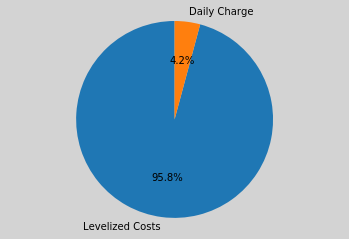

Total roof area of the  building: 599 m2
Total roof area used 574 m2
Percentage: 95.9%
succes
[[156.35155260254646, 211.60476155819413, 234.52515191061113, 15.643955519608742, 30.24348957628121, 52.28306225764283, 0.5335914020419915, 0.7757788837792874, 0.41217329080478504, 3177.72, 306.545, 306.545, 0.0, 0.0, {'Levelized Costs': 3044.6619999999994, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60222920003, 61845.7, 574.494]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (112.93235070938275, 207.69673399887665, 110.39754227105145, 29.98658752279255, 32.05698733484115, 12.573353276883859, 0.3491473597851858, 0.5469201241296235, 0.6988149000332886)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 30.0
                                           and a gcr of 0.349


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6069862842559814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 32.1
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5733892917633057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 12.6
                                           and a gcr of 0.699


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.571220874786377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 306.003, 0.0]


ERROR:ga_logger:Cost: 3172.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,172 per year


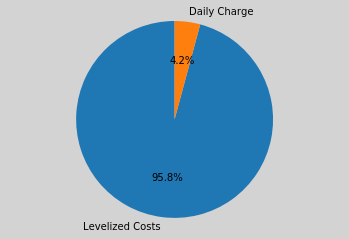

Total roof area of the  building: 599 m2
Total roof area used 560 m2
Percentage: 93.4%
succes
[[112.93235070938275, 207.69673399887665, 110.39754227105145, 29.98658752279255, 32.05698733484115, 12.573353276883859, 0.3491473597851858, 0.5469201241296235, 0.6988149000332886, 3172.34, 306.003, 0.0, 306.003, 0.0, {'Levelized Costs': 3039.287, 'Energy Charge': 0.011000000000251475, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602498270455, 61845.7, 559.502]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.37264609247978, 111.43591639572547, 196.7033968735908, 51.673949567404165, 8.5169635047817, 44.16496216693601, 0.887794106771576, 0.23839014938757724, 0.8840154783105423)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 51.7
                                           and a gcr of 0.888


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4162230491638184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 111
                                           a tilt of 8.5
                                           and a gcr of 0.238


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3783199787139893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 44.2
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4041593074798584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 71.7296, 263.322]


ERROR:ga_logger:Cost: 3460.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,461 per year


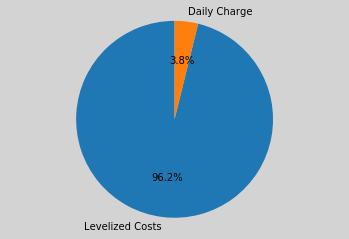

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[152.37264609247978, 111.43591639572547, 196.7033968735908, 51.673949567404165, 8.5169635047817, 44.16496216693601, 0.887794106771576, 0.23839014938757724, 0.8840154783105423, 3460.85, 335.0516, 0.0, 71.7296, 263.322, {'Levelized Costs': 3327.798, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599000904054, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.5128706326744, 165.2920077050366, 197.52346881117012, 16.617938287182604, 8.371553440839545, 50.463626351820686, 0.3302016543538894, 0.7745782410876045, 0.7999793277797027)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 16.6
                                           and a gcr of 0.330


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3851091861724854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 8.4
                                           and a gcr of 0.775


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4623425006866455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 50.5
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5103700160980225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 318.326, 0.0]


ERROR:ga_logger:Cost: 3294.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,295 per year


Total roof area of the  building: 599 m2
Total roof area used 411 m2
Percentage: 68.6%
succes
[[261.5128706326744, 165.2920077050366, 197.52346881117012, 16.617938287182604, 8.371553440839545, 50.463626351820686, 0.3302016543538894, 0.7745782410876045, 0.7999793277797027, 3294.74, 318.326, 0.0, 318.326, 0.0, {'Levelized Costs': 3161.6819999999993, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60238553549, 61845.7, 410.967]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.43679344239239, 138.92043702044487, 127.5076743553289, 54.08266288613995, 2.2168216514000947, 36.62590205642081, 0.23800446347236243, 0.3374147095813105, 0.6967922270211205)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 54.1
                                           and a gcr of 0.238


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.428595781326294 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 139
                                           a tilt of 2.2
                                           and a gcr of 0.337


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4597764015197754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 128
                                           a tilt of 36.6
                                           and a gcr of 0.697


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5338077545166016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 71.3628, 269.842]


ERROR:ga_logger:Cost: 3521.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,522 per year


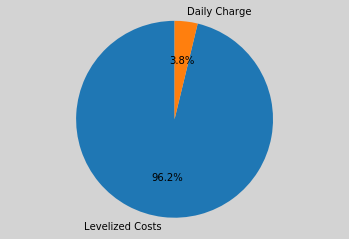

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.43679344239239, 138.92043702044487, 127.5076743553289, 54.08266288613995, 2.2168216514000947, 36.62590205642081, 0.23800446347236243, 0.3374147095813105, 0.6967922270211205, 3521.97, 341.2048, 0.0, 71.3628, 269.842, {'Levelized Costs': 3388.9139999999998, 'Energy Charge': 0.013999999999953161, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60055172997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (243.00568670231817, 176.8676951387468, 209.60856951668893, 16.16271234451017, 53.010084489372595, 40.71194087410527, 0.4498957608473727, 0.7509345285012252, 0.6501720920502665)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 243
                                           a tilt of 16.2
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0610973834991455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 53.0
                                           and a gcr of 0.751


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4275381565093994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 40.7
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5093681812286377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 190 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 321.401]


ERROR:ga_logger:Cost: 3325.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,325 per year


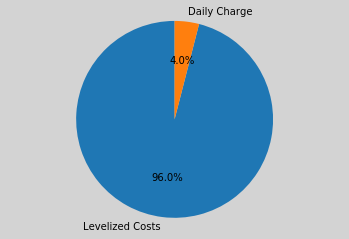

Total roof area of the  building: 599 m2
Total roof area used 494 m2
Percentage: 82.6%
succes
[[243.00568670231817, 176.8676951387468, 209.60856951668893, 16.16271234451017, 53.010084489372595, 40.71194087410527, 0.4498957608473727, 0.7509345285012252, 0.6501720920502665, 3325.28, 321.401, 0.0, 0.0, 321.401, {'Levelized Costs': 3192.2280000000005, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6023617644, 61845.7, 494.332]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (118.55642317853918, 182.60202281995123, 146.67771167981462, 22.434355517621455, 6.989218168794386, 10.206358360878864, 0.841563430956249, 0.2226316227438133, 0.2818427321178273)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 22.4
                                           and a gcr of 0.842


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.417710542678833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 7.0
                                           and a gcr of 0.223


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.944648027420044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 147
                                           a tilt of 10.2
                                           and a gcr of 0.282


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7061126232147217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [257.153, 0.0, 82.635]


ERROR:ga_logger:Cost: 3507.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,508 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[118.55642317853918, 182.60202281995123, 146.67771167981462, 22.434355517621455, 6.989218168794386, 10.206358360878864, 0.841563430956249, 0.2226316227438133, 0.2818427321178273, 3507.9, 339.788, 257.153, 0.0, 82.635, {'Levelized Costs': 3374.847, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60141928009, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105.30730625854925, 139.54020775078428, 211.67923567726095, 11.852087412060692, 37.50335742173494, 30.68997035910326, 0.6324525219921392, 0.5340191154851655, 0.5665066140911903)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 11.9
                                           and a gcr of 0.632


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5836381912231445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 37.5
                                           and a gcr of 0.534


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4020986557006836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 212
                                           a tilt of 30.7
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4475789070129395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 215 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.008]


ERROR:ga_logger:Cost: 3202.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,202 per year


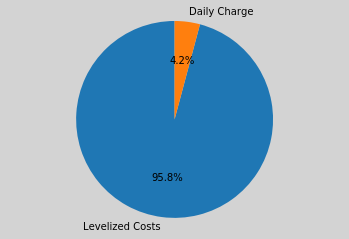

Total roof area of the  building: 599 m2
Total roof area used 545 m2
Percentage: 91.1%
succes
[[105.30730625854925, 139.54020775078428, 211.67923567726095, 11.852087412060692, 37.50335742173494, 30.68997035910326, 0.6324525219921392, 0.5340191154851655, 0.5665066140911903, 3202.18, 309.008, 0.0, 0.0, 309.008, {'Levelized Costs': 3069.1299999999997, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59898185171, 61845.7, 545.461]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.30147125502344, 123.02895460246317, 201.1689276186244, 22.89099918273122, 40.68822208831439, 2.946777472082239, 0.7436468931195255, 0.47687557113538487, 0.29138403994091716)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 22.9
                                           and a gcr of 0.744


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.423166275024414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 123
                                           a tilt of 40.7
                                           and a gcr of 0.477


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.521787643432617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 201
                                           a tilt of 2.9
                                           and a gcr of 0.291


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5815961360931396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [144.757, 192.707, 0.0]


ERROR:ga_logger:Cost: 3484.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,485 per year


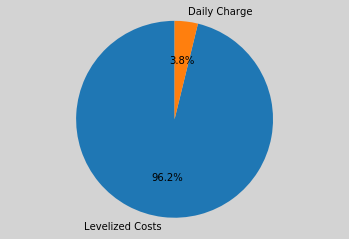

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[241.30147125502344, 123.02895460246317, 201.1689276186244, 22.89099918273122, 40.68822208831439, 2.946777472082239, 0.7436468931195255, 0.47687557113538487, 0.29138403994091716, 3484.82, 337.464, 144.757, 192.707, 0.0, {'Levelized Costs': 3351.761, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60047081, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (171.72170701460436, 209.7460541723355, 90.55820758345122, 44.398079725036155, 28.505083243476577, 5.518725621679259, 0.2644850419636225, 0.4543628927789239, 0.4441592737353647)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 44.4
                                           and a gcr of 0.264


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5340614318847656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 28.5
                                           and a gcr of 0.454


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.489845037460327 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 5.5
                                           and a gcr of 0.444


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.416753053665161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 272.055, 0.0]


ERROR:ga_logger:Cost: 3625.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0128 /kWh
Total Cost of the system: $ 3,625 per year


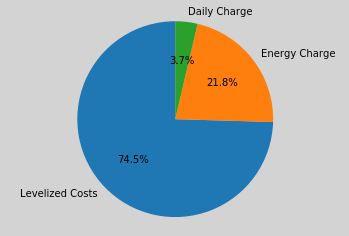

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[171.72170701460436, 209.7460541723355, 90.55820758345122, 44.398079725036155, 28.505083243476577, 5.518725621679259, 0.2644850419636225, 0.4543628927789239, 0.4441592737353647, 3625.41, 272.055, 0.0, 272.055, 0.0, {'Levelized Costs': 2702.1020000000003, 'Energy Charge': 790.2659999999998, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55538.72411644698, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (118.05839515137737, 201.4393808114914, 220.85230500730842, 47.56143172358904, 31.385101278166417, 45.655634515009986, 0.6052423826918344, 0.5542698752455473, 0.6822564191478966)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 118
                                           a tilt of 47.6
                                           and a gcr of 0.605


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5314321517944336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 201
                                           a tilt of 31.4
                                           and a gcr of 0.554


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4790804386138916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 221
                                           a tilt of 45.7
                                           and a gcr of 0.682


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.458320379257202 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 232 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 302.5, 0.0]


ERROR:ga_logger:Cost: 3137.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,138 per year


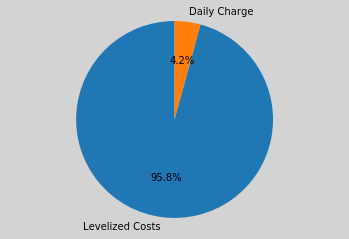

Total roof area of the  building: 599 m2
Total roof area used 546 m2
Percentage: 91.1%
succes
[[118.05839515137737, 201.4393808114914, 220.85230500730842, 47.56143172358904, 31.385101278166417, 45.655634515009986, 0.6052423826918344, 0.5542698752455473, 0.6822564191478966, 3137.54, 302.5, 0.0, 302.5, 0.0, {'Levelized Costs': 3004.4829999999997, 'Energy Charge': 0.015000000000327418, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600994176784, 61845.7, 545.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (216.34453270185233, 157.15090994807275, 240.02683041120704, 33.21782478144625, 3.790969127375652, 10.242295797953764, 0.8267219180172962, 0.2458302855773629, 0.4625829103561894)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 33.2
                                           and a gcr of 0.827


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.608950138092041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 3.8
                                           and a gcr of 0.246


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.530688762664795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 10.2
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.499765157699585 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 189 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [121.059, 0.0, 209.24]


ERROR:ga_logger:Cost: 3413.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,414 per year


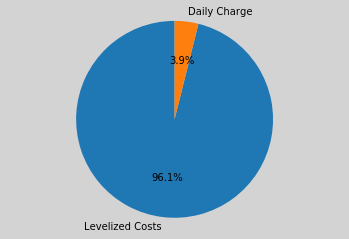

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[216.34453270185233, 157.15090994807275, 240.02683041120704, 33.21782478144625, 3.790969127375652, 10.242295797953764, 0.8267219180172962, 0.2458302855773629, 0.4625829103561894, 3413.65, 330.299, 121.059, 0.0, 209.24, {'Levelized Costs': 3280.5899999999997, 'Energy Charge': 0.018000000000370164, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599860054346, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220.2376474692315, 215.68527778677492, 187.04659032588353, 22.065040733162597, 50.44602262671858, 14.22587727284757, 0.3326028304789903, 0.2474368571333931, 0.48023079965022597)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 22.1
                                           and a gcr of 0.333


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5980441570281982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 50.4
                                           and a gcr of 0.247


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6139917373657227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 14.2
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.329399108886719 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 202 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 287.544]


ERROR:ga_logger:Cost: 3445.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0074 /kWh
Total Cost of the system: $ 3,446 per year


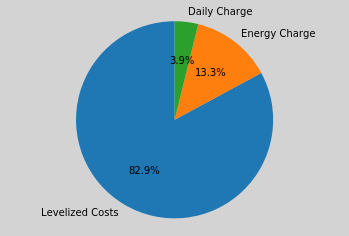

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[220.2376474692315, 215.68527778677492, 187.04659032588353, 22.065040733162597, 50.44602262671858, 14.22587727284757, 0.3326028304789903, 0.2474368571333931, 0.48023079965022597, 3445.6, 287.544, 0.0, 0.0, 287.544, {'Levelized Costs': 2855.939, 'Energy Charge': 456.6190000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58201.5230042409, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (131.20903259342987, 190.85612494404745, 184.06460922867063, 12.075708614208862, 1.719372180509303, 2.121395636020017, 0.5139196126034684, 0.534648047294504, 0.853191032013537)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 12.1
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.838522434234619 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 1.7
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3951451778411865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 2.1
                                           and a gcr of 0.853


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3690052032470703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 190 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [291.393, 0.0, 27.0975]


ERROR:ga_logger:Cost: 3296.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,296 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.20903259342987, 190.85612494404745, 184.06460922867063, 12.075708614208862, 1.719372180509303, 2.121395636020017, 0.5139196126034684, 0.534648047294504, 0.853191032013537, 3296.37, 318.4905, 291.393, 0.0, 27.0975, {'Levelized Costs': 3163.3109999999997, 'Energy Charge': 0.01700000000039381, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59878827778, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.15622679482544, 183.94484173387525, 203.82889021876366, 16.68491097288103, 53.89960167602224, 43.72390973980154, 0.40687083986369865, 0.5882274224106068, 0.88087083010929)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 16.7
                                           and a gcr of 0.407


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.730879545211792 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 53.9
                                           and a gcr of 0.588


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3810484409332275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 204
                                           a tilt of 43.7
                                           and a gcr of 0.881


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3764288425445557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [0.0, 318.608, 0.0]


ERROR:ga_logger:Cost: 3297.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,298 per year


Total roof area of the  building: 599 m2
Total roof area used 542 m2
Percentage: 90.5%
succes
[[261.15622679482544, 183.94484173387525, 203.82889021876366, 16.68491097288103, 53.89960167602224, 43.72390973980154, 0.40687083986369865, 0.5882274224106068, 0.88087083010929, 3297.54, 318.608, 0.0, 318.608, 0.0, {'Levelized Costs': 3164.4809999999998, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60219310177, 61845.7, 541.641]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (149.55588344968558, 197.79853281575038, 95.57660274173429, 23.41951089957903, 43.998219431698324, 25.044541672172937, 0.7416132855379671, 0.753230845975982, 0.28011523188095266)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 23.4
                                           and a gcr of 0.742


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5781924724578857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 44.0
                                           and a gcr of 0.753


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4348881244659424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 25.0
                                           and a gcr of 0.280


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4227378368377686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [315.613, 0.0, 0.0]


ERROR:ga_logger:Cost: 3267.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,268 per year


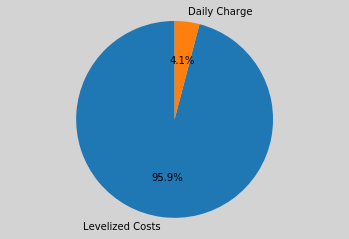

Total roof area of the  building: 599 m2
Total roof area used 426 m2
Percentage: 71.1%
succes
[[149.55588344968558, 197.79853281575038, 95.57660274173429, 23.41951089957903, 43.998219431698324, 25.044541672172937, 0.7416132855379671, 0.753230845975982, 0.28011523188095266, 3267.79, 315.613, 315.613, 0.0, 0.0, {'Levelized Costs': 3134.7309999999998, 'Energy Charge': 0.01700000000022328, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60194181134, 61845.7, 425.576]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.17431842151132, 201.60419816434438, 147.99209194200432, 3.100632061528814, 54.850950352630555, 17.380674570487894, 0.4617211562116985, 0.7548795736692309, 0.30441401300688425)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 3.1
                                           and a gcr of 0.462


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.604130268096924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 202
                                           a tilt of 54.9
                                           and a gcr of 0.755


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.426570177078247 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 148
                                           a tilt of 17.4
                                           and a gcr of 0.304


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6617329120635986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 257.056, 78.6106]


ERROR:ga_logger:Cost: 3466.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,467 per year


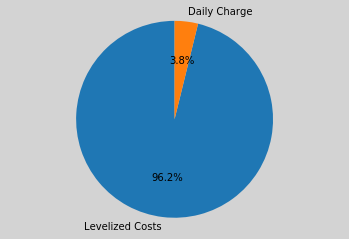

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[172.17431842151132, 201.60419816434438, 147.99209194200432, 3.100632061528814, 54.850950352630555, 17.380674570487894, 0.4617211562116985, 0.7548795736692309, 0.30441401300688425, 3466.97, 335.6666, 0.0, 257.056, 78.6106, {'Levelized Costs': 3333.9149999999995, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60164517401, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (155.35783657850516, 234.41237363179482, 260.6559185365531, 30.751728638642355, 19.394973446714236, 3.37600959183051, 0.8460407779660966, 0.76503233825634, 0.7081917460768248)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 30.8
                                           and a gcr of 0.846


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.190328598022461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 234
                                           a tilt of 19.4
                                           and a gcr of 0.765


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.496551036834717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 3.4
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.323068857192993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [326.53, 0.0, 0.0]


ERROR:ga_logger:Cost: 3376.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,376 per year


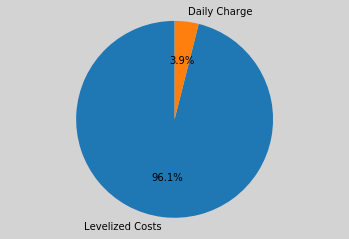

Total roof area of the  building: 599 m2
Total roof area used 386 m2
Percentage: 64.5%
succes
[[155.35783657850516, 234.41237363179482, 260.6559185365531, 30.751728638642355, 19.394973446714236, 3.37600959183051, 0.8460407779660966, 0.76503233825634, 0.7081917460768248, 3376.22, 326.53, 326.53, 0.0, 0.0, {'Levelized Costs': 3243.1639999999993, 'Energy Charge': 0.014000000000407908, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60107099989, 61845.7, 385.951]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (204.40036427014797, 221.42875791472832, 95.50068315562889, 46.12498714633782, 27.987148333756046, 41.45386257266395, 0.8784034504045961, 0.5301320301118487, 0.8811777282587205)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 46.1
                                           and a gcr of 0.878


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6240527629852295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 221
                                           a tilt of 28.0
                                           and a gcr of 0.530


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4193623065948486 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 41.5
                                           and a gcr of 0.881


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.452014207839966 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [0.0, 313.302, 0.0]


ERROR:ga_logger:Cost: 3244.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,245 per year


Total roof area of the  building: 599 m2
Total roof area used 591 m2
Percentage: 98.7%
succes
[[204.40036427014797, 221.42875791472832, 95.50068315562889, 46.12498714633782, 27.987148333756046, 41.45386257266395, 0.8784034504045961, 0.5301320301118487, 0.8811777282587205, 3244.84, 313.302, 0.0, 313.302, 0.0, {'Levelized Costs': 3111.776, 'Energy Charge': 0.022000000000446107, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601814170965, 61845.7, 590.989]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (149.1640297387128, 164.4454858087301, 104.06314465957992, 1.9541756044089738, 43.02103159176232, 23.18126281953024, 0.4871278890103241, 0.4664854959327036, 0.43538008010167273)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 2.0
                                           and a gcr of 0.487


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.449475049972534 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 43.0
                                           and a gcr of 0.466


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6096110343933105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 104
                                           a tilt of 23.2
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.705810070037842 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [0.0, 279.314, 0.0]


ERROR:ga_logger:Cost: 3502.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0096 /kWh
Total Cost of the system: $ 3,503 per year


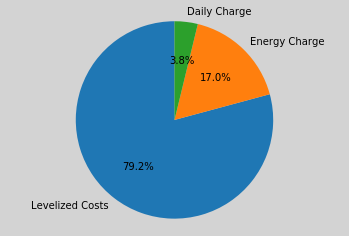

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[149.1640297387128, 164.4454858087301, 104.06314465957992, 1.9541756044089738, 43.02103159176232, 23.18126281953024, 0.4871278890103241, 0.4664854959327036, 0.43538008010167273, 3502.94, 279.314, 0.0, 279.314, 0.0, {'Levelized Costs': 2774.196, 'Energy Charge': 595.7020000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57091.54260399987, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (198.22580298648663, 244.7515925810691, 233.3344450379451, 19.34648003600022, 21.528924241600354, 29.32272265136144, 0.24148919214973655, 0.27728259022551277, 0.303621292485998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 19.3
                                           and a gcr of 0.241


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.772508382797241 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 21.5
                                           and a gcr of 0.277


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6175947189331055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 29.3
                                           and a gcr of 0.304


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.705624580383301 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 181.797]


ERROR:ga_logger:Cost: 5245.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0535 /kWh
Total Cost of the system: $ 5,246 per year


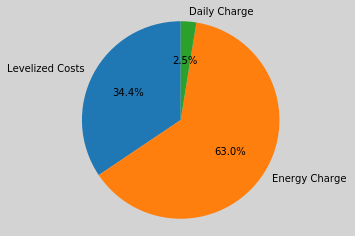

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[198.22580298648663, 244.7515925810691, 233.3344450379451, 19.34648003600022, 21.528924241600354, 29.32272265136144, 0.24148919214973655, 0.27728259022551277, 0.303621292485998, 5245.89, 181.797, 0.0, 0.0, 181.797, {'Levelized Costs': 1805.6366000000003, 'Energy Charge': 3307.2114, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 35451.38089961534, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (91.36508082970349, 128.5566487234182, 234.48649667709378, 50.11043940178943, 16.48901132203292, 47.550599876931976, 0.22744646800757667, 0.41835176668435414, 0.5203025661121292)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 50.1
                                           and a gcr of 0.227


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6263949871063232 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 129
                                           a tilt of 16.5
                                           and a gcr of 0.418


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4404854774475098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 47.6
                                           and a gcr of 0.520


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5379981994628906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 183 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.537]


ERROR:ga_logger:Cost: 4088.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0139 /kWh
Total Cost of the system: $ 4,088 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[91.36508082970349, 128.5566487234182, 234.48649667709378, 50.11043940178943, 16.48901132203292, 47.550599876931976, 0.22744646800757667, 0.41835176668435414, 0.5203025661121292, 4088.11, 311.537, 0.0, 0.0, 311.537, {'Levelized Costs': 3094.251, 'Energy Charge': 860.8170000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 54975.6882795966, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (108.7033649838731, 203.3602425866278, 94.19999513782543, 1.5895518137849098, 50.28108243595741, 34.435035627135434, 0.5155389328030181, 0.6573016833192566, 0.5497465145294529)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 1.6
                                           and a gcr of 0.516


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5140631198883057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 50.3
                                           and a gcr of 0.657


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5090694427490234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 34.4
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.404991626739502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 330.259, 0.0]


ERROR:ga_logger:Cost: 3413.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,413 per year


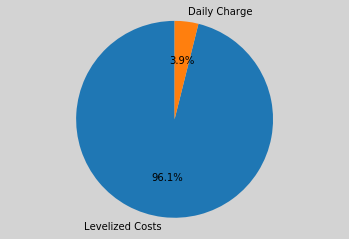

Total roof area of the  building: 599 m2
Total roof area used 502 m2
Percentage: 83.9%
succes
[[108.7033649838731, 203.3602425866278, 94.19999513782543, 1.5895518137849098, 50.28108243595741, 34.435035627135434, 0.5155389328030181, 0.6573016833192566, 0.5497465145294529, 3413.26, 330.259, 0.0, 330.259, 0.0, {'Levelized Costs': 3280.206, 'Energy Charge': 0.012000000000000455, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60045258937, 61845.7, 502.447]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (148.58171850031152, 238.96964372687856, 231.15910098944119, 55.47160228379075, 52.654094480629034, 41.09781355319811, 0.7310407981125937, 0.5530262090322926, 0.8377231074439078)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 55.5
                                           and a gcr of 0.731


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.641885280609131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 239
                                           a tilt of 52.7
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5398507118225098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 41.1
                                           and a gcr of 0.838


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.462062120437622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [356.818, 0.0, 0.0]


ERROR:ga_logger:Cost: 3677.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,677 per year


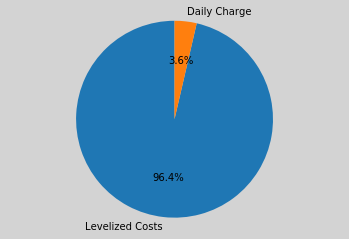

Total roof area of the  building: 599 m2
Total roof area used 488 m2
Percentage: 81.5%
succes
[[148.58171850031152, 238.96964372687856, 231.15910098944119, 55.47160228379075, 52.654094480629034, 41.09781355319811, 0.7310407981125937, 0.5530262090322926, 0.8377231074439078, 3677.04, 356.818, 356.818, 0.0, 0.0, {'Levelized Costs': 3543.9849999999997, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60100133003, 61845.7, 488.095]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (158.57138365766593, 97.14665897107355, 237.19212923847928, 55.13952201132592, 20.04707923788149, 51.10303280154027, 0.28149608156124917, 0.7159550499387428, 0.8411207308073916)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 55.1
                                           and a gcr of 0.281


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.487138509750366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 20.0
                                           and a gcr of 0.716


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9563066959381104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 51.1
                                           and a gcr of 0.841


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6707041263580322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [53.0933, 293.649, 0.0]


ERROR:ga_logger:Cost: 3576.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,577 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[158.57138365766593, 97.14665897107355, 237.19212923847928, 55.13952201132592, 20.04707923788149, 51.10303280154027, 0.28149608156124917, 0.7159550499387428, 0.8411207308073916, 3576.97, 346.7423, 53.0933, 293.649, 0.0, {'Levelized Costs': 3443.9049999999997, 'Energy Charge': 0.023000000000024556, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60167536997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (210.10498115186786, 187.41365244750165, 197.2781001253708, 15.270419597117762, 13.693026638128153, 7.529099187658237, 0.3921883288287332, 0.27609929945071576, 0.6354365337280874)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 15.3
                                           and a gcr of 0.392


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.495939254760742 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 13.7
                                           and a gcr of 0.276


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4684760570526123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 7.5
                                           and a gcr of 0.635


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3817200660705566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [104.911, 0.0, 210.495]


ERROR:ga_logger:Cost: 3265.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,266 per year


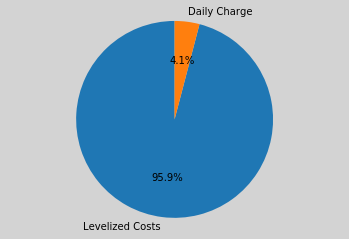

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[210.10498115186786, 187.41365244750165, 197.2781001253708, 15.270419597117762, 13.693026638128153, 7.529099187658237, 0.3921883288287332, 0.27609929945071576, 0.6354365337280874, 3265.73, 315.406, 104.911, 0.0, 210.495, {'Levelized Costs': 3132.6739999999995, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604164430864, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (113.4166537502515, 158.00891222289675, 240.61516138036606, 45.46098972607308, 43.645001380227754, 1.0651881969430568, 0.7786939507037753, 0.6516963802384119, 0.39246015895591047)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 45.5
                                           and a gcr of 0.779


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.581044912338257 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 158
                                           a tilt of 43.6
                                           and a gcr of 0.652


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5227973461151123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 1.1
                                           and a gcr of 0.392


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4484944343566895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 175 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 319.034, 0.0]


ERROR:ga_logger:Cost: 3301.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,302 per year


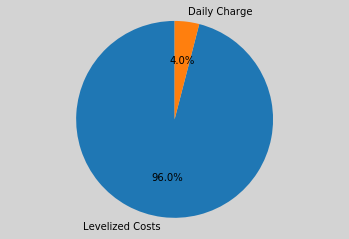

Total roof area of the  building: 599 m2
Total roof area used 490 m2
Percentage: 81.8%
succes
[[113.4166537502515, 158.00891222289675, 240.61516138036606, 45.46098972607308, 43.645001380227754, 1.0651881969430568, 0.7786939507037753, 0.6516963802384119, 0.39246015895591047, 3301.76, 319.034, 0.0, 319.034, 0.0, {'Levelized Costs': 3168.699, 'Energy Charge': 0.019000000000005457, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60133519988, 61845.7, 489.543]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (226.33427277836975, 240.79641184067256, 134.41438566752495, 5.878376689057188, 4.605295529387671, 10.304737635769204, 0.4025889204285673, 0.6700650583654107, 0.7886497305585054)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 5.9
                                           and a gcr of 0.403


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.745100259780884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 241
                                           a tilt of 4.6
                                           and a gcr of 0.670


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5107712745666504 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 134
                                           a tilt of 10.3
                                           and a gcr of 0.789


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4608242511749268 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 136s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 323.669]


ERROR:ga_logger:Cost: 3347.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,348 per year


Total roof area of the  building: 599 m2
Total roof area used 410 m2
Percentage: 68.5%
succes
[[226.33427277836975, 240.79641184067256, 134.41438566752495, 5.878376689057188, 4.605295529387671, 10.304737635769204, 0.4025889204285673, 0.6700650583654107, 0.7886497305585054, 3347.8, 323.669, 0.0, 0.0, 323.669, {'Levelized Costs': 3214.739, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60055761422, 61845.7, 410.409]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (96.88376536377322, 263.3593480607606, 132.1831898426166, 35.164172850244555, 12.747124111289969, 42.14203636563331, 0.3529444232906578, 0.27586670550323306, 0.7909243097813123)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 97
                                           a tilt of 35.2
                                           and a gcr of 0.353


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5472543239593506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 12.7
                                           and a gcr of 0.276


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.480433940887451 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 42.1
                                           and a gcr of 0.791


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.432603359222412 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 175 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 63.2093, 292.351]


ERROR:ga_logger:Cost: 3664.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,665 per year


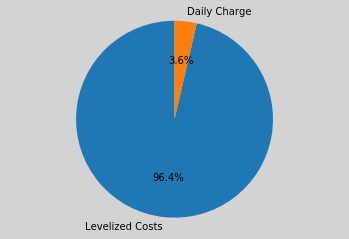

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[96.88376536377322, 263.3593480607606, 132.1831898426166, 35.164172850244555, 12.747124111289969, 42.14203636563331, 0.3529444232906578, 0.27586670550323306, 0.7909243097813123, 3664.55, 355.5603, 0.0, 63.2093, 292.351, {'Levelized Costs': 3531.4880000000003, 'Energy Charge': 0.020000000000095497, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599978399834, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (106.83520734399445, 202.52590633709775, 222.9737637099675, 34.03859696332719, 32.359087310168896, 49.14318021182116, 0.7917609086623065, 0.4111340923885207, 0.23114727749098476)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 107
                                           a tilt of 34.0
                                           and a gcr of 0.792


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.540658950805664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 32.4
                                           and a gcr of 0.411


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5344293117523193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 223
                                           a tilt of 49.1
                                           and a gcr of 0.231


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.462261199951172 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 175 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [202.653, 140.94, 0.0]


ERROR:ga_logger:Cost: 3545.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,546 per year


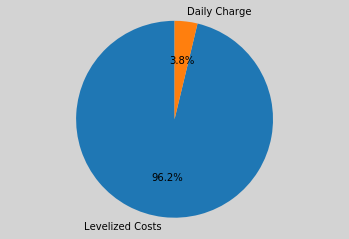

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[106.83520734399445, 202.52590633709775, 222.9737637099675, 34.03859696332719, 32.359087310168896, 49.14318021182116, 0.7917609086623065, 0.4111340923885207, 0.23114727749098476, 3545.7, 343.59299999999996, 202.653, 140.94, 0.0, {'Levelized Costs': 3412.6510000000003, 'Energy Charge': 0.006999999999720785, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600119589966, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205.49325073011698, 162.64842733227687, 115.83141734179291, 2.844985731576612, 47.96642101599126, 44.90101939766646, 0.36055745512409704, 0.7882324326202863, 0.6814588271214211)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 2.8
                                           and a gcr of 0.361


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7210376262664795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 48.0
                                           and a gcr of 0.788


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7356417179107666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 116
                                           a tilt of 44.9
                                           and a gcr of 0.681


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.975374460220337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [117.459, 215.181, 0.0]


ERROR:ga_logger:Cost: 3436.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,437 per year


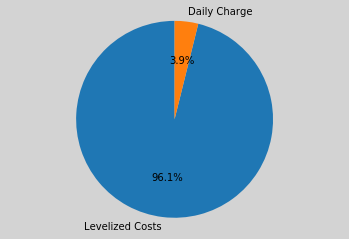

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[205.49325073011698, 162.64842733227687, 115.83141734179291, 2.844985731576612, 47.96642101599126, 44.90101939766646, 0.36055745512409704, 0.7882324326202863, 0.6814588271214211, 3436.9, 332.64, 117.459, 215.181, 0.0, {'Levelized Costs': 3303.85, 'Energy Charge': 0.008000000000208729, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60357531131, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.92270899574115, 218.88458177087202, 185.37600058011878, 47.63901131352626, 39.06136375966494, 22.805524905665365, 0.44574587726789866, 0.8105342641399065, 0.4932168927395321)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 47.6
                                           and a gcr of 0.446


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7844862937927246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 39.1
                                           and a gcr of 0.811


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.233051300048828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 22.8
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.722050905227661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  24 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 7.02938, 291.042]


ERROR:ga_logger:Cost: 3093.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,094 per year


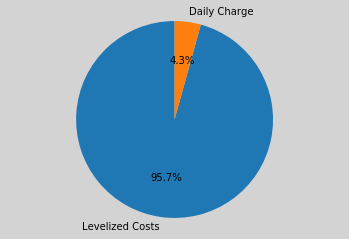

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[120.92270899574115, 218.88458177087202, 185.37600058011878, 47.63901131352626, 39.06136375966494, 22.805524905665365, 0.44574587726789866, 0.8105342641399065, 0.4932168927395321, 3093.56, 298.07138, 0.0, 7.02938, 291.042, {'Levelized Costs': 2960.491, 'Energy Charge': 0.027000000000043656, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60326985272, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180.27701038038273, 196.8543510681019, 201.6524595812013, 2.612629252933072, 32.259529238690725, 15.797195437115683, 0.3078655934454392, 0.5668398022033339, 0.43187384522046424)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 2.6
                                           and a gcr of 0.308


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4275598526000977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 32.3
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4360358715057373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 15.8
                                           and a gcr of 0.432


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454174280166626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 301.182, 0.0]


ERROR:ga_logger:Cost: 3124.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,124 per year


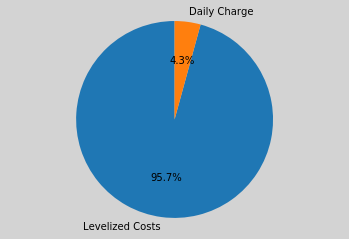

Total roof area of the  building: 599 m2
Total roof area used 531 m2
Percentage: 88.7%
succes
[[180.27701038038273, 196.8543510681019, 201.6524595812013, 2.612629252933072, 32.259529238690725, 15.797195437115683, 0.3078655934454392, 0.5668398022033339, 0.43187384522046424, 3124.46, 301.182, 0.0, 301.182, 0.0, {'Levelized Costs': 2991.395, 'Energy Charge': 0.02300000000025193, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60018857275, 61845.7, 531.336]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (161.59426223976948, 121.34780777462208, 231.27195757131744, 48.813443443473346, 38.62136415740015, 15.74295913605902, 0.28574080649860045, 0.8275792999695877, 0.4312567232591008)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 48.8
                                           and a gcr of 0.286


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.624452590942383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 38.6
                                           and a gcr of 0.828


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.419530153274536 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 15.7
                                           and a gcr of 0.431


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.492353916168213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 184.173, 162.246]


ERROR:ga_logger:Cost: 3573.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,574 per year


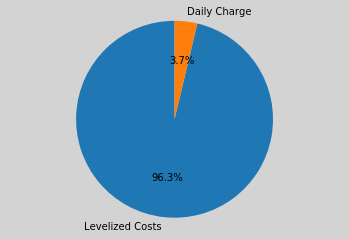

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[161.59426223976948, 121.34780777462208, 231.27195757131744, 48.813443443473346, 38.62136415740015, 15.74295913605902, 0.28574080649860045, 0.8275792999695877, 0.4312567232591008, 3573.76, 346.419, 0.0, 184.173, 162.246, {'Levelized Costs': 3440.7060000000006, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6021494002, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (223.1436983655111, 116.70919509793606, 132.1588625435754, 52.04799521902414, 52.722606650436404, 52.280198531720515, 0.8101952645517547, 0.20951065763989235, 0.8623377874376206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 223
                                           a tilt of 52.0
                                           and a gcr of 0.810


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7688803672790527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 117
                                           a tilt of 52.7
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6347508430480957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 52.3
                                           and a gcr of 0.862


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6269640922546387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [334.83, 38.8624, 0.0]


ERROR:ga_logger:Cost: 3844.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,845 per year


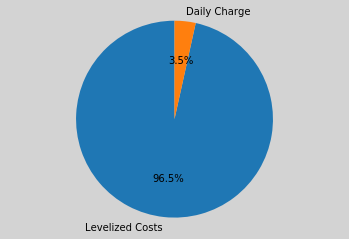

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[223.1436983655111, 116.70919509793606, 132.1588625435754, 52.04799521902414, 52.722606650436404, 52.280198531720515, 0.8101952645517547, 0.20951065763989235, 0.8623377874376206, 3844.64, 373.69239999999996, 334.83, 38.8624, 0.0, {'Levelized Costs': 3711.5889999999995, 'Energy Charge': 0.009000000000241926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601722879925, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.78864293054527, 238.75694338354919, 116.93322018029926, 25.56775666498113, 48.066370686875636, 26.6861072118883, 0.7901366990313585, 0.8472927427799095, 0.3636077875949877)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 25.6
                                           and a gcr of 0.790


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.844205379486084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 239
                                           a tilt of 48.1
                                           and a gcr of 0.847


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4573941230773926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 117
                                           a tilt of 26.7
                                           and a gcr of 0.364


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4410452842712402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [239.776, 0.0, 107.373]


ERROR:ga_logger:Cost: 3581.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,581 per year


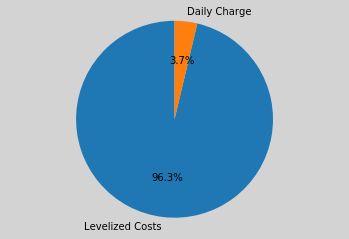

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[108.78864293054527, 238.75694338354919, 116.93322018029926, 25.56775666498113, 48.066370686875636, 26.6861072118883, 0.7901366990313585, 0.8472927427799095, 0.3636077875949877, 3581.02, 347.149, 239.776, 0.0, 107.373, {'Levelized Costs': 3447.958, 'Energy Charge': 0.01999999999998181, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60278552991, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235.25776136785706, 95.9703461323725, 151.48917640896775, 49.928785532832805, 33.034800019997604, 26.358199955637243, 0.6749129979564281, 0.5226338430115176, 0.735882655059648)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 49.9
                                           and a gcr of 0.675


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6039698123931885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 33.0
                                           and a gcr of 0.523


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4713759422302246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 26.4
                                           and a gcr of 0.736


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.486788034439087 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.371]


ERROR:ga_logger:Cost: 3265.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,265 per year


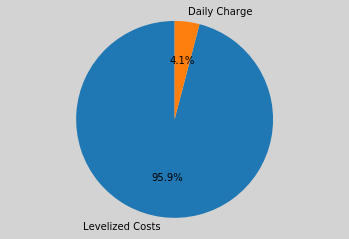

Total roof area of the  building: 599 m2
Total roof area used 429 m2
Percentage: 71.6%
succes
[[235.25776136785706, 95.9703461323725, 151.48917640896775, 49.928785532832805, 33.034800019997604, 26.358199955637243, 0.6749129979564281, 0.5226338430115176, 0.735882655059648, 3265.38, 315.371, 0.0, 0.0, 315.371, {'Levelized Costs': 3132.3300000000004, 'Energy Charge': 0.007999999999810825, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60192148019, 61845.7, 428.561]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (222.9212255197846, 128.30666716392443, 108.66045200456938, 41.87224610374948, 28.08526649311771, 23.925674392685647, 0.780122394348405, 0.5358676704963858, 0.3137310077153178)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 223
                                           a tilt of 41.9
                                           and a gcr of 0.780


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.870828866958618 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 128
                                           a tilt of 28.1
                                           and a gcr of 0.536


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4642388820648193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 23.9
                                           and a gcr of 0.314


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4513766765594482 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 319.362, 0.0]


ERROR:ga_logger:Cost: 3305.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,305 per year


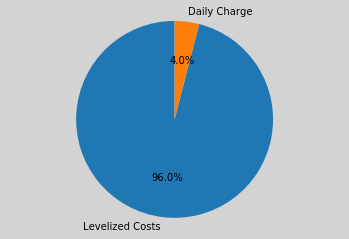

Total roof area of the  building: 599 m2
Total roof area used 596 m2
Percentage: 99.5%
succes
[[222.9212255197846, 128.30666716392443, 108.66045200456938, 41.87224610374948, 28.08526649311771, 23.925674392685647, 0.780122394348405, 0.5358676704963858, 0.3137310077153178, 3305.03, 319.362, 0.0, 319.362, 0.0, {'Levelized Costs': 3171.98, 'Energy Charge': 0.008000000000436103, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60211211996, 61845.7, 595.972]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (198.9816543739389, 143.63461415979887, 206.00096397432787, 22.877194049918714, 8.016380835166498, 53.49002922635363, 0.7011324359317093, 0.4223240051912295, 0.7727430714196979)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 22.9
                                           and a gcr of 0.701


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.821951389312744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 8.0
                                           and a gcr of 0.422


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6196250915527344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 53.5
                                           and a gcr of 0.773


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.644880533218384 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 133s


ERROR:ga_logger:panel relevance: [307.865, 0.0, 0.0]


ERROR:ga_logger:Cost: 3190.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,191 per year


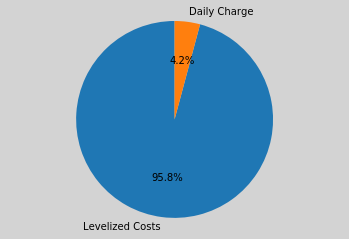

Total roof area of the  building: 599 m2
Total roof area used 439 m2
Percentage: 73.3%
succes
[[198.9816543739389, 143.63461415979887, 206.00096397432787, 22.877194049918714, 8.016380835166498, 53.49002922635363, 0.7011324359317093, 0.4223240051912295, 0.7727430714196979, 3190.83, 307.865, 307.865, 0.0, 0.0, {'Levelized Costs': 3057.7670000000003, 'Energy Charge': 0.02099999999973079, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60166695517, 61845.7, 439.096]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (116.79571930127148, 193.93548995802706, 203.7466094908407, 46.41855138376977, 18.12857133046651, 47.01510922848492, 0.7043523131548104, 0.323152843342823, 0.4050388070240494)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 46.4
                                           and a gcr of 0.704


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5317485332489014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 18.1
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.552976608276367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 204
                                           a tilt of 47.0
                                           and a gcr of 0.405


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4911293983459473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 168 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [287.91, 0.0, 76.9589]


ERROR:ga_logger:Cost: 3757.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,757 per year


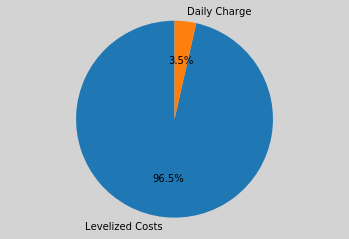

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[116.79571930127148, 193.93548995802706, 203.7466094908407, 46.41855138376977, 18.12857133046651, 47.01510922848492, 0.7043523131548104, 0.323152843342823, 0.4050388070240494, 3757.0, 364.86890000000005, 287.91, 0.0, 76.9589, {'Levelized Costs': 3623.948, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60151309999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (171.07946108076763, 103.6153077266886, 157.0105937874556, 32.29584335642542, 19.03139689808749, 26.83763665840742, 0.5599077802576402, 0.6656016717802467, 0.6268243002743573)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 171
                                           a tilt of 32.3
                                           and a gcr of 0.560


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.784785509109497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 104
                                           a tilt of 19.0
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6343986988067627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 26.8
                                           and a gcr of 0.627


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6767313480377197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 135s


ERROR:ga_logger:panel relevance: [298.793, 0.0, 0.0]


ERROR:ga_logger:Cost: 3100.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,101 per year


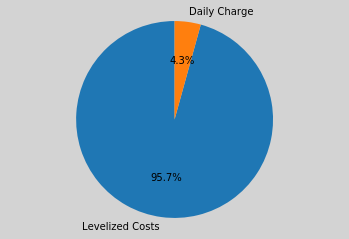

Total roof area of the  building: 599 m2
Total roof area used 534 m2
Percentage: 89.1%
succes
[[171.07946108076763, 103.6153077266886, 157.0105937874556, 32.29584335642542, 19.03139689808749, 26.83763665840742, 0.5599077802576402, 0.6656016717802467, 0.6268243002743573, 3100.73, 298.793, 298.793, 0.0, 0.0, {'Levelized Costs': 2967.672, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59911667991, 61845.7, 533.647]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (219.16209930440996, 258.688131249041, 93.56165556914478, 38.07082085589255, 39.853839612243796, 33.17668031837088, 0.7635587006764588, 0.7357188899019742, 0.526153318428487)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 219
                                           a tilt of 38.1
                                           and a gcr of 0.764


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.561771869659424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 39.9
                                           and a gcr of 0.736


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3862762451171875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 33.2
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5839526653289795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [339.007, 0.0, 0.0]


ERROR:ga_logger:Cost: 3500.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,500 per year


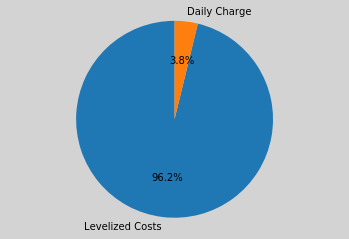

Total roof area of the  building: 599 m2
Total roof area used 444 m2
Percentage: 74.2%
succes
[[219.16209930440996, 258.688131249041, 93.56165556914478, 38.07082085589255, 39.853839612243796, 33.17668031837088, 0.7635587006764588, 0.7357188899019742, 0.526153318428487, 3500.14, 339.007, 339.007, 0.0, 0.0, {'Levelized Costs': 3367.0789999999997, 'Energy Charge': 0.019000000000346517, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60404320839, 61845.7, 443.983]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (229.05689823583933, 247.77889066470095, 217.70781092741385, 15.45922287826294, 27.070537305163064, 15.955394720812173, 0.3880252716874535, 0.30277131202120966, 0.479662751967073)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 229
                                           a tilt of 15.5
                                           and a gcr of 0.388


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.433460235595703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 248
                                           a tilt of 27.1
                                           and a gcr of 0.303


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6059041023254395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 218
                                           a tilt of 16.0
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.118621349334717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 287.204]


ERROR:ga_logger:Cost: 3606.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0100 /kWh
Total Cost of the system: $ 3,607 per year


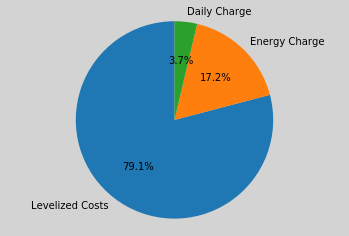

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[229.05689823583933, 247.77889066470095, 217.70781092741385, 15.45922287826294, 27.070537305163064, 15.955394720812173, 0.3880252716874535, 0.30277131202120966, 0.479662751967073, 3606.95, 287.204, 0.0, 0.0, 287.204, {'Levelized Costs': 2852.5619999999994, 'Energy Charge': 621.3460000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56886.862754937945, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.94803205838593, 158.9627014035685, 225.75313893887656, 1.0331680551470892, 8.02518820645442, 35.24731662984005, 0.8688055319588508, 0.8226491362454711, 0.6902473620586775)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 1.0
                                           and a gcr of 0.869


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.595093011856079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 159
                                           a tilt of 8.0
                                           and a gcr of 0.823


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.369335174560547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 35.2
                                           and a gcr of 0.690


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.403956174850464 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 320.798, 0.0]


ERROR:ga_logger:Cost: 3319.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,319 per year


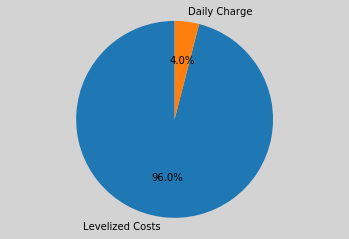

Total roof area of the  building: 599 m2
Total roof area used 390 m2
Percentage: 65.1%
succes
[[141.94803205838593, 158.9627014035685, 225.75313893887656, 1.0331680551470892, 8.02518820645442, 35.24731662984005, 0.8688055319588508, 0.8226491362454711, 0.6902473620586775, 3319.28, 320.798, 0.0, 320.798, 0.0, {'Levelized Costs': 3186.231, 'Energy Charge': 0.006999999999948159, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60013584665, 61845.7, 389.957]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (222.49854915173174, 157.37341677672583, 198.31476917478875, 51.78054269440304, 55.425482263963886, 16.31315643931951, 0.6393435580577493, 0.7502419009321719, 0.36620158542714376)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 222
                                           a tilt of 51.8
                                           and a gcr of 0.639


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.566432237625122 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 55.4
                                           and a gcr of 0.750


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4047956466674805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 16.3
                                           and a gcr of 0.366


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.506998300552368 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 122s


ERROR:ga_logger:panel relevance: [0.0, 222.703, 110.564]


ERROR:ga_logger:Cost: 3443.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,443 per year


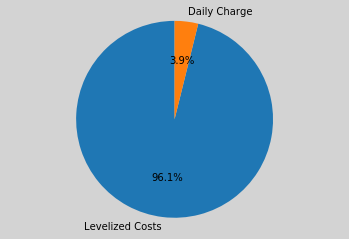

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[222.49854915173174, 157.37341677672583, 198.31476917478875, 51.78054269440304, 55.425482263963886, 16.31315643931951, 0.6393435580577493, 0.7502419009321719, 0.36620158542714376, 3443.13, 333.267, 0.0, 222.703, 110.564, {'Levelized Costs': 3310.077, 'Energy Charge': 0.010999999999910415, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602419178555, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255.38778492310638, 173.41028588291655, 94.90720330151375, 36.09707886569338, 39.53465195795956, 28.292997550591373, 0.36899003028132094, 0.8766957651735803, 0.7448981103510577)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 36.1
                                           and a gcr of 0.369


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.665893316268921 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 39.5
                                           and a gcr of 0.877


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4270501136779785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 28.3
                                           and a gcr of 0.745


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.460676908493042 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 326.422, 0.0]


ERROR:ga_logger:Cost: 3375.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


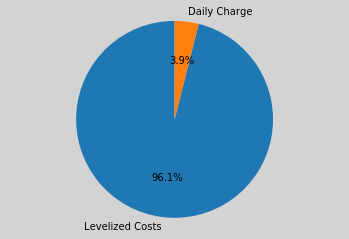

Total roof area of the  building: 599 m2
Total roof area used 372 m2
Percentage: 62.2%
succes
[[255.38778492310638, 173.41028588291655, 94.90720330151375, 36.09707886569338, 39.53465195795956, 28.292997550591373, 0.36899003028132094, 0.8766957651735803, 0.7448981103510577, 3375.14, 326.422, 0.0, 326.422, 0.0, {'Levelized Costs': 3242.089, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60191905008, 61845.7, 372.332]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (151.4888448629003, 139.1217101307101, 159.53476064394016, 55.21659045434987, 26.52877969067338, 37.0395508131886, 0.4116727913055326, 0.5300816968757269, 0.23956748856963545)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 55.2
                                           and a gcr of 0.412


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.589625597000122 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 139
                                           a tilt of 26.5
                                           and a gcr of 0.530


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.470010995864868 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 37.0
                                           and a gcr of 0.240


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5084667205810547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 303.285, 6.37583]


ERROR:ga_logger:Cost: 3208.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,209 per year


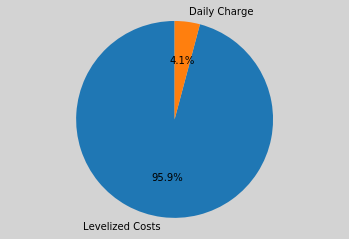

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[151.4888448629003, 139.1217101307101, 159.53476064394016, 55.21659045434987, 26.52877969067338, 37.0395508131886, 0.4116727913055326, 0.5300816968757269, 0.23956748856963545, 3208.67, 309.66083000000003, 0.0, 303.285, 6.37583, {'Levelized Costs': 3075.602, 'Energy Charge': 0.026000000000237833, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60074722017, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (233.33736393563404, 154.70856303996277, 151.7053236329631, 42.93098378675048, 10.810827912120624, 45.45418468903593, 0.4649067408627761, 0.24756837234069762, 0.6172447604678248)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 233
                                           a tilt of 42.9
                                           and a gcr of 0.465


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.814434289932251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 10.8
                                           and a gcr of 0.248


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.670139789581299 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 152
                                           a tilt of 45.5
                                           and a gcr of 0.617


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.698641300201416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 31.6062, 290.781]


ERROR:ga_logger:Cost: 3335.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,335 per year


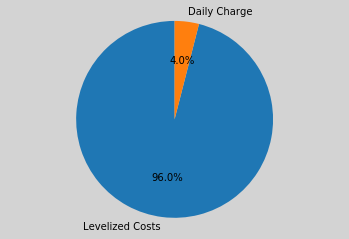

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[233.33736393563404, 154.70856303996277, 151.7053236329631, 42.93098378675048, 10.810827912120624, 45.45418468903593, 0.4649067408627761, 0.24756837234069762, 0.6172447604678248, 3335.07, 322.3872, 0.0, 31.6062, 290.781, {'Levelized Costs': 3202.0119999999997, 'Energy Charge': 0.016000000000531145, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60151751, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (156.57800410129832, 127.00074150024113, 222.93245204549794, 41.53540064414213, 29.88142362236217, 48.61268677758663, 0.7102994869646415, 0.8387220119700767, 0.5028277569227009)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 41.5
                                           and a gcr of 0.710


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.423731803894043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 127
                                           a tilt of 29.9
                                           and a gcr of 0.839


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.41038179397583 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 223
                                           a tilt of 48.6
                                           and a gcr of 0.503


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4166715145111084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [322.454, 0.0, 0.0]


ERROR:ga_logger:Cost: 3335.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,336 per year


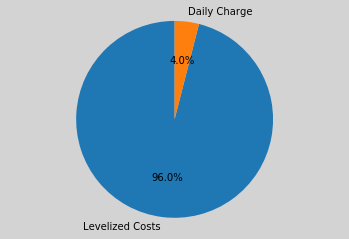

Total roof area of the  building: 599 m2
Total roof area used 454 m2
Percentage: 75.8%
succes
[[156.57800410129832, 127.00074150024113, 222.93245204549794, 41.53540064414213, 29.88142362236217, 48.61268677758663, 0.7102994869646415, 0.8387220119700767, 0.5028277569227009, 3335.73, 322.454, 322.454, 0.0, 0.0, {'Levelized Costs': 3202.675, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60035069994, 61845.7, 453.969]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (198.87808177970152, 178.28770477994215, 204.9543445126972, 10.942699303092605, 22.613988076141585, 11.257488834657323, 0.8524583548059161, 0.34914193400721094, 0.487729829492235)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 10.9
                                           and a gcr of 0.852


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9745070934295654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 22.6
                                           and a gcr of 0.349


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.514183521270752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 11.3
                                           and a gcr of 0.488


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5552103519439697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [167.935, 140.272, 0.0]


ERROR:ga_logger:Cost: 3194.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,194 per year


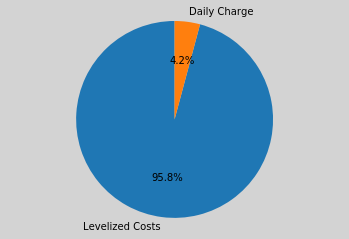

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[198.87808177970152, 178.28770477994215, 204.9543445126972, 10.942699303092605, 22.613988076141585, 11.257488834657323, 0.8524583548059161, 0.34914193400721094, 0.487729829492235, 3194.23, 308.207, 167.935, 140.272, 0.0, {'Levelized Costs': 3061.169, 'Energy Charge': 0.0190000000000623, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599479888675, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (216.73366991075306, 262.6077171438893, 112.00188930441274, 13.809006469171585, 31.995519436687246, 51.890393758042535, 0.8461425758730607, 0.22120201122617666, 0.521258744461213)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 217
                                           a tilt of 13.8
                                           and a gcr of 0.846


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.048346757888794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 32.0
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6507985591888428 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 51.9
                                           and a gcr of 0.521


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.669267177581787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 126s


ERROR:ga_logger:panel relevance: [325.172, 0.0, 0.0]


ERROR:ga_logger:Cost: 3362.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,363 per year


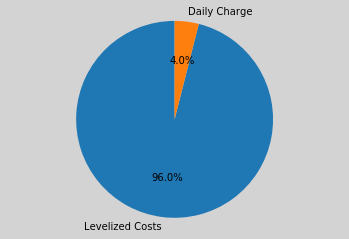

Total roof area of the  building: 599 m2
Total roof area used 384 m2
Percentage: 64.2%
succes
[[216.73366991075306, 262.6077171438893, 112.00188930441274, 13.809006469171585, 31.995519436687246, 51.890393758042535, 0.8461425758730607, 0.22120201122617666, 0.521258744461213, 3362.73, 325.172, 325.172, 0.0, 0.0, {'Levelized Costs': 3229.6699999999996, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60211056472, 61845.7, 384.3]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (218.32806868617857, 258.3938171013243, 198.43258097128407, 24.260185590746453, 43.315642912205846, 26.707709532908325, 0.6659330332725479, 0.5898997518984714, 0.32122964033726925)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 218
                                           a tilt of 24.3
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.607550859451294 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 43.3
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.403508424758911 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 26.7
                                           and a gcr of 0.321


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.40897536277771 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [229.036, 0.0, 81.8585]


ERROR:ga_logger:Cost: 3220.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,221 per year


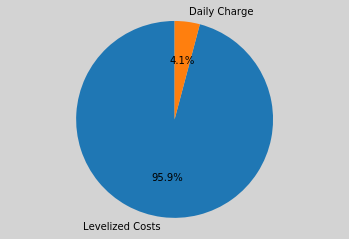

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[218.32806868617857, 258.3938171013243, 198.43258097128407, 24.260185590746453, 43.315642912205846, 26.707709532908325, 0.6659330332725479, 0.5898997518984714, 0.32122964033726925, 3220.93, 310.8945, 229.036, 0.0, 81.8585, {'Levelized Costs': 3087.8759999999997, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601128493334, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (261.5843959749846, 175.92125010900793, 112.10069198699952, 8.912452523606271, 43.68067554093127, 24.360310164693047, 0.5181464653126959, 0.5538658513912771, 0.3079561143414057)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 8.9
                                           and a gcr of 0.518


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.111471891403198 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 43.7
                                           and a gcr of 0.554


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.562272548675537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 24.4
                                           and a gcr of 0.308


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.613358974456787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 126s


ERROR:ga_logger:panel relevance: [0.0, 304.939, 0.0]


ERROR:ga_logger:Cost: 3161.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,162 per year


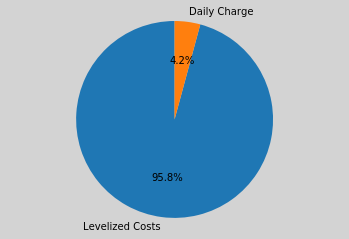

Total roof area of the  building: 599 m2
Total roof area used 551 m2
Percentage: 92.0%
succes
[[261.5843959749846, 175.92125010900793, 112.10069198699952, 8.912452523606271, 43.68067554093127, 24.360310164693047, 0.5181464653126959, 0.5538658513912771, 0.3079561143414057, 3161.77, 304.939, 0.0, 304.939, 0.0, {'Levelized Costs': 3028.7180000000003, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602638860095, 61845.7, 550.565]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (122.75634367231646, 116.76907179992475, 145.83476752800092, 28.79007279339333, 3.5833147643893084, 6.924612746642869, 0.5735943945295605, 0.37758804480853014, 0.4945729853958785)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 123
                                           a tilt of 28.8
                                           and a gcr of 0.574


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4982364177703857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 117
                                           a tilt of 3.6
                                           and a gcr of 0.378


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3569610118865967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 146
                                           a tilt of 6.9
                                           and a gcr of 0.495


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4695520401000977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 160 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [210.035, 0.0, 115.032]


ERROR:ga_logger:Cost: 3361.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,362 per year


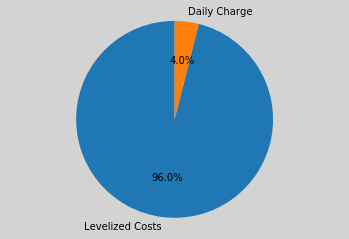

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[122.75634367231646, 116.76907179992475, 145.83476752800092, 28.79007279339333, 3.5833147643893084, 6.924612746642869, 0.5735943945295605, 0.37758804480853014, 0.4945729853958785, 3361.69, 325.067, 210.035, 0.0, 115.032, {'Levelized Costs': 3228.631, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60035169989, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.38538804067218, 252.5995548551838, 159.81286806836258, 15.312909810680244, 40.75777361952612, 40.848762850007674, 0.3986011549877543, 0.7718689943322188, 0.8182818961699347)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 15.3
                                           and a gcr of 0.399


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5218889713287354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 40.8
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.20549750328064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 40.8
                                           and a gcr of 0.818


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4646620750427246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [157.029, 0.0, 167.594]


ERROR:ga_logger:Cost: 3357.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,357 per year


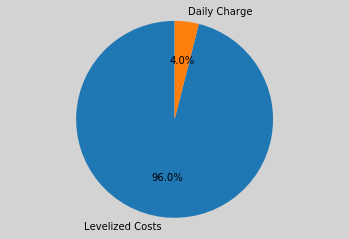

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[120.38538804067218, 252.5995548551838, 159.81286806836258, 15.312909810680244, 40.75777361952612, 40.848762850007674, 0.3986011549877543, 0.7718689943322188, 0.8182818961699347, 3357.27, 324.623, 157.029, 0.0, 167.594, {'Levelized Costs': 3224.214, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602592850046, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (97.8848574863525, 227.82393160523122, 243.27981107035868, 19.90653651240873, 18.847986996603716, 41.28914879283693, 0.7832678977668597, 0.8805930372476991, 0.34206871000420447)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 98
                                           a tilt of 19.9
                                           and a gcr of 0.783


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8637638092041016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 228
                                           a tilt of 18.8
                                           and a gcr of 0.881


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7439424991607666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 243
                                           a tilt of 41.3
                                           and a gcr of 0.342


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.751486301422119 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 338.685, 0.0]


ERROR:ga_logger:Cost: 3496.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,497 per year


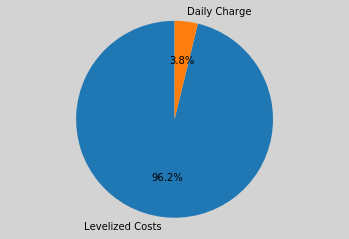

Total roof area of the  building: 599 m2
Total roof area used 385 m2
Percentage: 64.2%
succes
[[97.8848574863525, 227.82393160523122, 243.27981107035868, 19.90653651240873, 18.847986996603716, 41.28914879283693, 0.7832678977668597, 0.8805930372476991, 0.34206871000420447, 3496.94, 338.685, 0.0, 338.685, 0.0, {'Levelized Costs': 3363.888, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600268408016, 61845.7, 384.61]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (198.045337817031, 182.8630525125118, 168.06900454883944, 5.679571045384982, 35.84428240500809, 17.108285888953766, 0.658709908840251, 0.41717844196205045, 0.3809998114607792)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 5.7
                                           and a gcr of 0.659


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.921562910079956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 35.8
                                           and a gcr of 0.417


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7915265560150146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 17.1
                                           and a gcr of 0.381


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.72358775138855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 210 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [156.818, 150.474, 0.0]


ERROR:ga_logger:Cost: 3185.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,185 per year


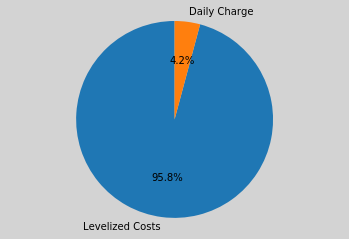

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[198.045337817031, 182.8630525125118, 168.06900454883944, 5.679571045384982, 35.84428240500809, 17.108285888953766, 0.658709908840251, 0.41717844196205045, 0.3809998114607792, 3185.14, 307.29200000000003, 156.818, 150.474, 0.0, {'Levelized Costs': 3052.0779999999995, 'Energy Charge': 0.020000000000436557, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59989655294, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (149.34053150551944, 158.35113739508608, 236.33441970806703, 55.15846473684346, 32.75169134388423, 10.22405890532387, 0.6333775143881011, 0.43612563976390595, 0.7783495616162446)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 55.2
                                           and a gcr of 0.633


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6806447505950928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 158
                                           a tilt of 32.8
                                           and a gcr of 0.436


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5954246520996094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 236
                                           a tilt of 10.2
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.301913022994995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [0.0, 201.676, 106.117]


ERROR:ga_logger:Cost: 3190.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,190 per year


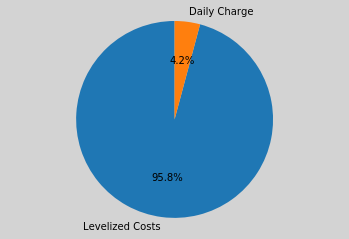

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[149.34053150551944, 158.35113739508608, 236.33441970806703, 55.15846473684346, 32.75169134388423, 10.22405890532387, 0.6333775143881011, 0.43612563976390595, 0.7783495616162446, 3190.12, 307.793, 0.0, 201.676, 106.117, {'Levelized Costs': 3057.067, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60208987452, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (228.4069270305475, 259.5532360796178, 226.33562994561981, 19.731431782373562, 12.35855970727886, 54.67626007099451, 0.5933338155680989, 0.5531576455793399, 0.3230328115967946)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 19.7
                                           and a gcr of 0.593


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.4950408935546875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 12.4
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.400140047073364 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 54.7
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.606609582901001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [318.983, 0.0, 0.0]


ERROR:ga_logger:Cost: 3301.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,301 per year


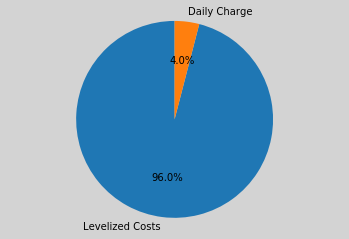

Total roof area of the  building: 599 m2
Total roof area used 538 m2
Percentage: 89.8%
succes
[[228.4069270305475, 259.5532360796178, 226.33562994561981, 19.731431782373562, 12.35855970727886, 54.67626007099451, 0.5933338155680989, 0.5531576455793399, 0.3230328115967946, 3301.25, 318.983, 318.983, 0.0, 0.0, {'Levelized Costs': 3168.1929999999998, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60209618769, 61845.7, 537.611]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (231.56956020036486, 132.72559082970727, 153.64293557697545, 2.8663287869072627, 34.253624074522634, 22.909502657592974, 0.3395833398958832, 0.4093556824639918, 0.35624336579881133)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 232
                                           a tilt of 2.9
                                           and a gcr of 0.340


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5546350479125977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 34.3
                                           and a gcr of 0.409


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6258039474487305 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 22.9
                                           and a gcr of 0.356


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6569674015045166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 193 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 245.106, 0.0]


ERROR:ga_logger:Cost: 4244.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0271 /kWh
Total Cost of the system: $ 4,245 per year


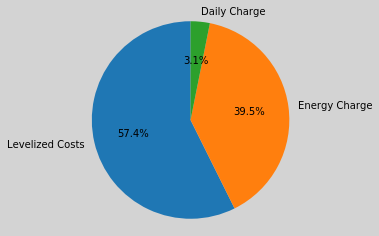

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[231.56956020036486, 132.72559082970727, 153.64293557697545, 2.8663287869072627, 34.253624074522634, 22.909502657592974, 0.3395833398958832, 0.4093556824639918, 0.35624336579881133, 4244.89, 245.106, 0.0, 245.106, 0.0, {'Levelized Costs': 2434.447, 'Energy Charge': 1677.4010000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 48458.63157723987, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160.7774271537883, 93.80723008574326, 231.63411917947485, 10.184507894518266, 8.76466650888918, 16.43570154765067, 0.3650890015893101, 0.20453870033545937, 0.6508512492364241)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 10.2
                                           and a gcr of 0.365


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.089746952056885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 94
                                           a tilt of 8.8
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.796290397644043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 232
                                           a tilt of 16.4
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9039716720581055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 167s


ERROR:ga_logger:panel relevance: [89.3878, 0.0, 230.351]


ERROR:ga_logger:Cost: 3308.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,309 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[160.7774271537883, 93.80723008574326, 231.63411917947485, 10.184507894518266, 8.76466650888918, 16.43570154765067, 0.3650890015893101, 0.20453870033545937, 0.6508512492364241, 3308.77, 319.73879999999997, 89.3878, 0.0, 230.351, {'Levelized Costs': 3175.714, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60256787221, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (142.07684642354937, 217.36282153567848, 246.59307379993362, 35.38043769421384, 13.995400266211327, 21.898349398677276, 0.41162834408829607, 0.42780508970186654, 0.6036442838091908)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 142
                                           a tilt of 35.4
                                           and a gcr of 0.412


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.749279022216797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 14.0
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.636704921722412 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 247
                                           a tilt of 21.9
                                           and a gcr of 0.604


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.605647563934326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [70.0646, 0.0, 258.691]


ERROR:ga_logger:Cost: 3398.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,398 per year


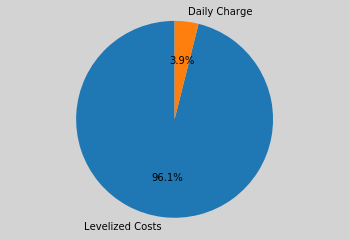

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[142.07684642354937, 217.36282153567848, 246.59307379993362, 35.38043769421384, 13.995400266211327, 21.898349398677276, 0.41162834408829607, 0.42780508970186654, 0.6036442838091908, 3398.32, 328.75559999999996, 70.0646, 0.0, 258.691, {'Levelized Costs': 3265.267, 'Energy Charge': 0.011000000000308319, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60198251087, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175.20713306370155, 132.88651091965218, 202.2260612259094, 36.11816756145525, 30.51557130238453, 40.78130121867224, 0.8171779495517093, 0.3999103320540781, 0.8247396619929557)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 36.1
                                           and a gcr of 0.817


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9619686603546143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 30.5
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8124730587005615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 202
                                           a tilt of 40.8
                                           and a gcr of 0.825


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.816439151763916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [144.767, 168.605, 0.0]


ERROR:ga_logger:Cost: 3245.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,246 per year


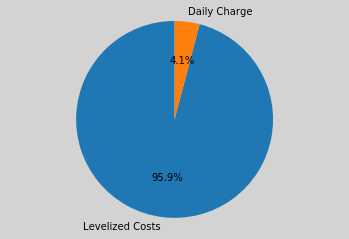

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[175.20713306370155, 132.88651091965218, 202.2260612259094, 36.11816756145525, 30.51557130238453, 40.78130121867224, 0.8171779495517093, 0.3999103320540781, 0.8247396619929557, 3245.53, 313.37199999999996, 144.767, 168.605, 0.0, {'Levelized Costs': 3112.467, 'Energy Charge': 0.021000000000015007, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601404803965, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (112.44844972952698, 207.53444293641795, 156.78727269470244, 20.900067095633837, 34.747481506188514, 50.8772176068575, 0.7720803528255775, 0.7121319337239618, 0.5070731967720052)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 112
                                           a tilt of 20.9
                                           and a gcr of 0.772


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7705864906311035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 34.7
                                           and a gcr of 0.712


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6839280128479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 50.9
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.593935966491699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 319.061, 0.0]


ERROR:ga_logger:Cost: 3302.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,302 per year


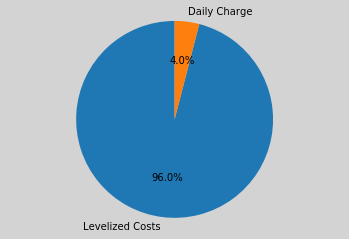

Total roof area of the  building: 599 m2
Total roof area used 448 m2
Percentage: 74.8%
succes
[[112.44844972952698, 207.53444293641795, 156.78727269470244, 20.900067095633837, 34.747481506188514, 50.8772176068575, 0.7720803528255775, 0.7121319337239618, 0.5070731967720052, 3302.03, 319.061, 0.0, 319.061, 0.0, {'Levelized Costs': 3168.9700000000003, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60369267188, 61845.7, 448.036]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (129.51637027860355, 151.922732317895, 256.499747655056, 4.346253297427422, 30.88882899076394, 3.510040218524763, 0.8842978953870142, 0.786965446386235, 0.4894753486839814)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 4.3
                                           and a gcr of 0.884


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9070310592651367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 30.9
                                           and a gcr of 0.787


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8019769191741943 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 256
                                           a tilt of 3.5
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6604669094085693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 154 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [0.0, 322.714, 0.0]


ERROR:ga_logger:Cost: 3338.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,338 per year


Total roof area of the  building: 599 m2
Total roof area used 410 m2
Percentage: 68.5%
succes
[[129.51637027860355, 151.922732317895, 256.499747655056, 4.346253297427422, 30.88882899076394, 3.510040218524763, 0.8842978953870142, 0.786965446386235, 0.4894753486839814, 3338.32, 322.714, 0.0, 322.714, 0.0, {'Levelized Costs': 3205.2670000000003, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60045998502, 61845.7, 410.074]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (107.26393530062592, 101.33131284326001, 131.97571358529436, 32.81573667621851, 17.13852553033111, 17.610967051814608, 0.3825719805810232, 0.8360272371304367, 0.5900554050282056)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 107
                                           a tilt of 32.8
                                           and a gcr of 0.383


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.639583110809326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 101
                                           a tilt of 17.1
                                           and a gcr of 0.836


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.52748966217041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 17.6
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5028324127197266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.097]


ERROR:ga_logger:Cost: 3272.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,273 per year


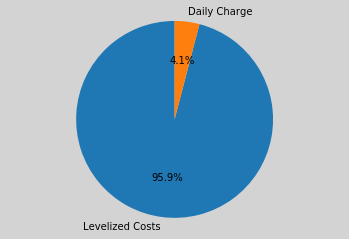

Total roof area of the  building: 599 m2
Total roof area used 536 m2
Percentage: 89.5%
succes
[[107.26393530062592, 101.33131284326001, 131.97571358529436, 32.81573667621851, 17.13852553033111, 17.610967051814608, 0.3825719805810232, 0.8360272371304367, 0.5900554050282056, 3272.6, 316.097, 0.0, 0.0, 316.097, {'Levelized Costs': 3139.5389999999998, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601705117995, 61845.7, 535.708]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (242.10751270963735, 104.27236593186686, 225.65234595302636, 11.569792080142859, 3.7611639772377465, 33.49237296401464, 0.5079573863493382, 0.8295989803870039, 0.8609347381157777)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 11.6
                                           and a gcr of 0.508


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5058064460754395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 104
                                           a tilt of 3.8
                                           and a gcr of 0.830


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.421382188796997 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 33.5
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4498372077941895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [266.091, 62.15, 0.0]


ERROR:ga_logger:Cost: 3393.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,393 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[242.10751270963735, 104.27236593186686, 225.65234595302636, 11.569792080142859, 3.7611639772377465, 33.49237296401464, 0.5079573863493382, 0.8295989803870039, 0.8609347381157777, 3393.22, 328.241, 266.091, 62.15, 0.0, {'Levelized Costs': 3260.1659999999993, 'Energy Charge': 0.012000000000512046, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601912841514, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.00751089724578, 187.25072822426768, 197.3618784473682, 17.215726404659407, 29.621844864486455, 8.89185855089179, 0.8011467825412089, 0.3796586334443742, 0.7180652225613824)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 17.2
                                           and a gcr of 0.801


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5951621532440186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 29.6
                                           and a gcr of 0.380


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4825775623321533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 8.9
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.474135637283325 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [0.0, 139.621, 165.879]


ERROR:ga_logger:Cost: 3167.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,167 per year


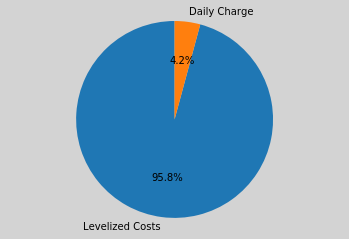

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[120.00751089724578, 187.25072822426768, 197.3618784473682, 17.215726404659407, 29.621844864486455, 8.89185855089179, 0.8011467825412089, 0.3796586334443742, 0.7180652225613824, 3167.34, 305.5, 0.0, 139.621, 165.879, {'Levelized Costs': 3034.2819999999997, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603970336044, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.00020820152145, 100.90363457967715, 176.32909698424402, 20.359538605965955, 31.00147655013061, 31.649635553920728, 0.23639323161453074, 0.721379321187757, 0.6684115392948906)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 20.4
                                           and a gcr of 0.236


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8547778129577637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 101
                                           a tilt of 31.0
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6362173557281494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 31.6
                                           and a gcr of 0.668


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.711214542388916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.298]


ERROR:ga_logger:Cost: 3145.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,145 per year


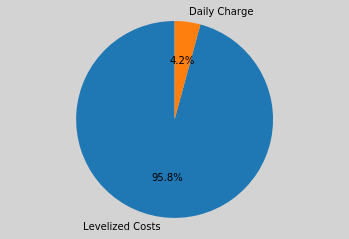

Total roof area of the  building: 599 m2
Total roof area used 454 m2
Percentage: 75.8%
succes
[[139.00020820152145, 100.90363457967715, 176.32909698424402, 20.359538605965955, 31.00147655013061, 31.649635553920728, 0.23639323161453074, 0.721379321187757, 0.6684115392948906, 3145.47, 303.298, 0.0, 0.0, 303.298, {'Levelized Costs': 3012.4089999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6020732892, 61845.7, 453.76]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (93.88889568687473, 165.92762585579413, 177.39383567925194, 12.520946767676982, 37.574580510295746, 16.56443605449244, 0.4219951453884454, 0.42691908103102544, 0.5270200315865505)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 12.5
                                           and a gcr of 0.422


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.784839630126953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 37.6
                                           and a gcr of 0.427


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6924867630004883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 16.6
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.644705057144165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 58.8545, 242.905]


ERROR:ga_logger:Cost: 3130.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,130 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[93.88889568687473, 165.92762585579413, 177.39383567925194, 12.520946767676982, 37.574580510295746, 16.56443605449244, 0.4219951453884454, 0.42691908103102544, 0.5270200315865505, 3130.19, 301.7595, 0.0, 58.8545, 242.905, {'Levelized Costs': 2997.132, 'Energy Charge': 0.016000000000019554, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600227938165, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (129.19006974820726, 138.49803550490793, 223.48556300011828, 25.029297201654344, 8.92343175902918, 40.522145628995126, 0.4836790708471974, 0.5771990058531578, 0.42457382143088784)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 25.0
                                           and a gcr of 0.484


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6072592735290527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 138
                                           a tilt of 8.9
                                           and a gcr of 0.577


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.471973419189453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 223
                                           a tilt of 40.5
                                           and a gcr of 0.425


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5533573627471924 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [147.717, 169.326, 0.0]


ERROR:ga_logger:Cost: 3281.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,282 per year


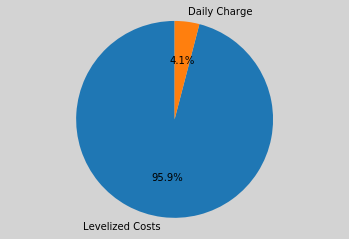

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[129.19006974820726, 138.49803550490793, 223.48556300011828, 25.029297201654344, 8.92343175902918, 40.522145628995126, 0.4836790708471974, 0.5771990058531578, 0.42457382143088784, 3281.99, 317.043, 147.717, 169.326, 0.0, {'Levelized Costs': 3148.9249999999997, 'Energy Charge': 0.02299999999991087, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602389710984, 61845.7, 598.762]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (213.80264680320926, 191.02257188119654, 213.7758538107239, 33.010465704377786, 36.14865295223836, 41.99749012772965, 0.7345815419592475, 0.6578741057329283, 0.8864589023792049)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 33.0
                                           and a gcr of 0.735


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5432026386260986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 36.1
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.476041793823242 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 42.0
                                           and a gcr of 0.886


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5021896362304688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 305.571, 0.0]


ERROR:ga_logger:Cost: 3168.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,168 per year


Total roof area of the  building: 599 m2
Total roof area used 464 m2
Percentage: 77.6%
succes
[[213.80264680320926, 191.02257188119654, 213.7758538107239, 33.010465704377786, 36.14865295223836, 41.99749012772965, 0.7345815419592475, 0.6578741057329283, 0.8864589023792049, 3168.05, 305.571, 0.0, 305.571, 0.0, {'Levelized Costs': 3035.0000000000005, 'Energy Charge': 0.007999999999924512, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600235853104, 61845.7, 464.483]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (196.60984268390285, 132.33491331854583, 215.6812906864934, 11.234430001673704, 32.32457513560066, 13.707115955000145, 0.459006821431559, 0.4154765251295656, 0.8546564755474123)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 11.2
                                           and a gcr of 0.459


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.898314952850342 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 132
                                           a tilt of 32.3
                                           and a gcr of 0.415


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.434695243835449 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 216
                                           a tilt of 13.7
                                           and a gcr of 0.855


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.49300479888916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [228.111, 0.0, 87.0009]


ERROR:ga_logger:Cost: 3262.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,263 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[196.60984268390285, 132.33491331854583, 215.6812906864934, 11.234430001673704, 32.32457513560066, 13.707115955000145, 0.459006821431559, 0.4154765251295656, 0.8546564755474123, 3262.81, 315.1119, 228.111, 0.0, 87.0009, {'Levelized Costs': 3129.756, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59884385891, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205.7484290350551, 239.44121156581846, 196.91487683916534, 19.372287270458536, 43.04786774175353, 32.5801261502427, 0.5364989305542565, 0.7419367762976575, 0.39034756157848866)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 19.4
                                           and a gcr of 0.536


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.818899393081665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 239
                                           a tilt of 43.0
                                           and a gcr of 0.742


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.668144941329956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 32.6
                                           and a gcr of 0.390


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.612595796585083 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 142s


ERROR:ga_logger:panel relevance: [258.261, 0.0, 45.8188]


ERROR:ga_logger:Cost: 3153.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,153 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[205.7484290350551, 239.44121156581846, 196.91487683916534, 19.372287270458536, 43.04786774175353, 32.5801261502427, 0.5364989305542565, 0.7419367762976575, 0.39034756157848866, 3153.24, 304.07980000000003, 258.261, 0.0, 45.8188, {'Levelized Costs': 3020.1879999999996, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60060494238, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.8873788675532, 160.4792211494423, 166.0599005141066, 29.086260700304607, 49.39729851601027, 26.950752140207197, 0.3204166907387117, 0.5898997518984714, 0.2835449256649937)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 163
                                           a tilt of 29.1
                                           and a gcr of 0.320


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4651317596435547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 49.4
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.430272102355957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 27.0
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.46268367767334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [43.5307, 273.068, 0.0]


ERROR:ga_logger:Cost: 3277.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,278 per year


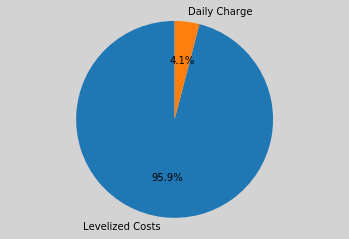

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[162.8873788675532, 160.4792211494423, 166.0599005141066, 29.086260700304607, 49.39729851601027, 26.950752140207197, 0.3204166907387117, 0.5898997518984714, 0.2835449256649937, 3277.57, 316.5987, 43.5307, 273.068, 0.0, {'Levelized Costs': 3144.514, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59968850001, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (220.65482473260283, 187.1153484340172, 157.99863015576722, 17.694236011322257, 45.304873653425524, 55.63696206297344, 0.8228061927144086, 0.3661228971319051, 0.5140762907310525)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 221
                                           a tilt of 17.7
                                           and a gcr of 0.823


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.541679620742798 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 45.3
                                           and a gcr of 0.366


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4674770832061768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 158
                                           a tilt of 55.6
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.440441608428955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 121s


ERROR:ga_logger:panel relevance: [168.644, 144.179, 0.0]


ERROR:ga_logger:Cost: 3240.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,240 per year


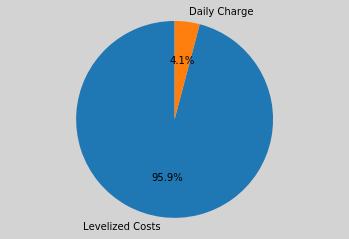

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[220.65482473260283, 187.1153484340172, 157.99863015576722, 17.694236011322257, 45.304873653425524, 55.63696206297344, 0.8228061927144086, 0.3661228971319051, 0.5140762907310525, 3240.08, 312.823, 168.644, 144.179, 0.0, {'Levelized Costs': 3107.031, 'Energy Charge': 0.007000000000232376, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60207001497, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90.7321453994443, 255.38057792347104, 105.96064761818015, 12.390736117902323, 34.08604176258515, 22.25079043085632, 0.29839287236120093, 0.26665671239496946, 0.5091467240312854)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 12.4
                                           and a gcr of 0.298


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3866636753082275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 34.1
                                           and a gcr of 0.267


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.435901403427124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 106
                                           a tilt of 22.3
                                           and a gcr of 0.509


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.441005229949951 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 200 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 304.858]


ERROR:ga_logger:Cost: 3856.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0112 /kWh
Total Cost of the system: $ 3,857 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[90.7321453994443, 255.38057792347104, 105.96064761818015, 12.390736117902323, 34.08604176258515, 22.25079043085632, 0.29839287236120093, 0.26665671239496946, 0.5091467240312854, 3856.71, 304.858, 0.0, 0.0, 304.858, {'Levelized Costs': 3027.907, 'Energy Charge': 695.7609999999999, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56292.97205244999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160.63519570606465, 202.59012602338964, 161.6248991154933, 27.273040689608365, 54.108358356049095, 16.812860462528075, 0.7299096554227228, 0.7548577938536107, 0.2818813516363275)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 27.3
                                           and a gcr of 0.730


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4196994304656982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 54.1
                                           and a gcr of 0.755


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3886022567749023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 16.8
                                           and a gcr of 0.282


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.584181070327759 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 185 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 158s


ERROR:ga_logger:panel relevance: [227.233, 0.0, 81.0252]


ERROR:ga_logger:Cost: 3194.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,195 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[160.63519570606465, 202.59012602338964, 161.6248991154933, 27.273040689608365, 54.108358356049095, 16.812860462528075, 0.7299096554227228, 0.7548577938536107, 0.2818813516363275, 3194.74, 308.2582, 227.233, 0.0, 81.0252, {'Levelized Costs': 3061.682, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601461699946, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.37136424868152, 170.2700064036348, 96.14003684718261, 7.441325670049302, 45.8620493038258, 12.281343250907868, 0.4617211562116985, 0.7079020152933156, 0.3026478932515095)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 7.4
                                           and a gcr of 0.462


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7211639881134033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 45.9
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4727821350097656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 12.3
                                           and a gcr of 0.303


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5564303398132324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [195.578, 124.008, 0.0]


ERROR:ga_logger:Cost: 3307.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,307 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.37136424868152, 170.2700064036348, 96.14003684718261, 7.441325670049302, 45.8620493038258, 12.281343250907868, 0.4617211562116985, 0.7079020152933156, 0.3026478932515095, 3307.25, 319.586, 195.578, 124.008, 0.0, {'Levelized Costs': 3174.194, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60069989986, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (257.68022244909776, 174.86089598698004, 190.3379437727426, 52.04799521902414, 53.85336430349474, 53.36226513540879, 0.8101952645517547, 0.5096766087437158, 0.8898359731311785)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 52.0
                                           and a gcr of 0.810


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4006874561309814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 53.9
                                           and a gcr of 0.510


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4395363330841064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 53.4
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4427731037139893 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 185 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [0.0, 285.964, 33.5399]


ERROR:ga_logger:Cost: 3306.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,306 per year


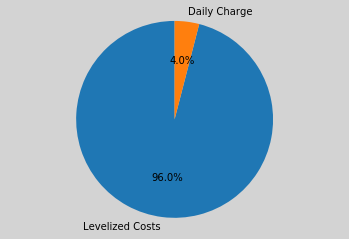

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[257.68022244909776, 174.86089598698004, 190.3379437727426, 52.04799521902414, 53.85336430349474, 53.36226513540879, 0.8101952645517547, 0.5096766087437158, 0.8898359731311785, 3306.43, 319.5039, 0.0, 285.964, 33.5399, {'Levelized Costs': 3173.3689999999997, 'Energy Charge': 0.0190000000000623, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60128869128, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (227.68648389845077, 124.63907119921431, 130.53808265197137, 19.85323206074332, 48.41960313753006, 45.21861900952151, 0.427187444908487, 0.24497251485481464, 0.8628663591425355)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 19.9
                                           and a gcr of 0.427


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.982961893081665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 48.4
                                           and a gcr of 0.245


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7044179439544678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 131
                                           a tilt of 45.2
                                           and a gcr of 0.863


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.708366632461548 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [168.522, 0.0, 176.258]


ERROR:ga_logger:Cost: 3557.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,557 per year


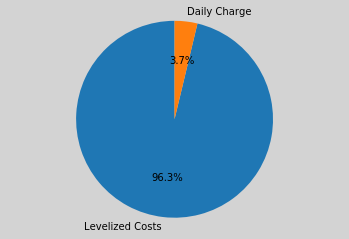

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[227.68648389845077, 124.63907119921431, 130.53808265197137, 19.85323206074332, 48.41960313753006, 45.21861900952151, 0.427187444908487, 0.24497251485481464, 0.8628663591425355, 3557.48, 344.78, 168.522, 0.0, 176.258, {'Levelized Costs': 3424.425, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60221363979, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (202.71492913320304, 181.8731074563894, 221.36728402301014, 29.603808171223857, 33.83600574813331, 34.183375101526806, 0.8994716067041724, 0.49354236018809194, 0.37584256079344547)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 203
                                           a tilt of 29.6
                                           and a gcr of 0.899


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.593766927719116 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 33.8
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.495709180831909 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 221
                                           a tilt of 34.2
                                           and a gcr of 0.376


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.497690200805664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 294.463, 0.0]


ERROR:ga_logger:Cost: 3057.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,058 per year


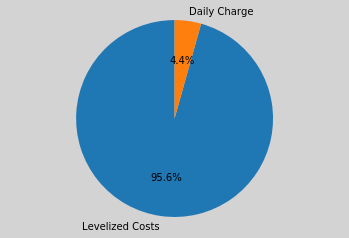

Total roof area of the  building: 599 m2
Total roof area used 597 m2
Percentage: 99.6%
succes
[[202.71492913320304, 181.8731074563894, 221.36728402301014, 29.603808171223857, 33.83600574813331, 34.183375101526806, 0.8994716067041724, 0.49354236018809194, 0.37584256079344547, 3057.73, 294.463, 0.0, 294.463, 0.0, {'Levelized Costs': 2924.676, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598525163834, 61845.7, 596.632]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.24054859285467, 106.83412756988105, 166.38484189940948, 5.679571045384982, 28.896475670621555, 17.81263712374364, 0.657958392550757, 0.41717844196205045, 0.2690653051453548)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 108
                                           a tilt of 5.7
                                           and a gcr of 0.658


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.508542776107788 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 107
                                           a tilt of 28.9
                                           and a gcr of 0.417


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.581960916519165 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 17.8
                                           and a gcr of 0.269


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5671603679656982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [278.922, 0.0, 47.0439]


ERROR:ga_logger:Cost: 3370.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,371 per year


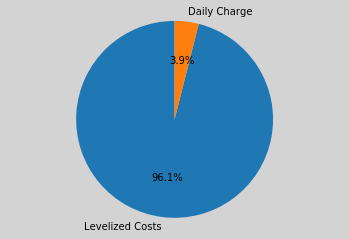

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[108.24054859285467, 106.83412756988105, 166.38484189940948, 5.679571045384982, 28.896475670621555, 17.81263712374364, 0.657958392550757, 0.41717844196205045, 0.2690653051453548, 3370.61, 325.96590000000003, 278.922, 0.0, 47.0439, {'Levelized Costs': 3237.554, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60213868402, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.79482093437625, 245.4624517475914, 216.9697967787477, 15.338040264167123, 39.54982528842854, 35.6713369537814, 0.4274856376045109, 0.8214469026127811, 0.7967790192350752)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 15.3
                                           and a gcr of 0.427


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.501835584640503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 39.5
                                           and a gcr of 0.821


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3864922523498535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 217
                                           a tilt of 35.7
                                           and a gcr of 0.797


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4004428386688232 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 187 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 141s


ERROR:ga_logger:panel relevance: [185.799, 0.0, 130.774]


ERROR:ga_logger:Cost: 3277.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,277 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[172.79482093437625, 245.4624517475914, 216.9697967787477, 15.338040264167123, 39.54982528842854, 35.6713369537814, 0.4274856376045109, 0.8214469026127811, 0.7967790192350752, 3277.33, 316.573, 185.799, 0.0, 130.774, {'Levelized Costs': 3144.2729999999997, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60181841425, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (122.62070843677128, 179.99350361617346, 185.57764904732005, 11.01792749393793, 21.78427779695044, 23.23538316084573, 0.35780934899222305, 0.3723124509945748, 0.7790737474383156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 123
                                           a tilt of 11.0
                                           and a gcr of 0.358


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.584625720977783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 21.8
                                           and a gcr of 0.372


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4578921794891357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 23.2
                                           and a gcr of 0.779


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0227882862091064 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 208 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [0.0, 150.419, 151.724]


ERROR:ga_logger:Cost: 3134.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,134 per year


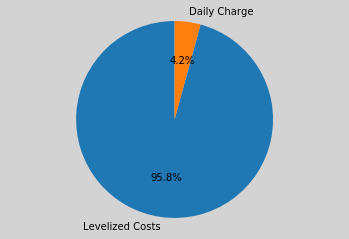

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[122.62070843677128, 179.99350361617346, 185.57764904732005, 11.01792749393793, 21.78427779695044, 23.23538316084573, 0.35780934899222305, 0.3723124509945748, 0.7790737474383156, 3134.0, 302.14300000000003, 0.0, 150.419, 151.724, {'Levelized Costs': 3000.9500000000003, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60376360875, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.04601925672424, 258.0800433143168, 227.57108087039154, 39.93447475180433, 15.836275175146385, 54.12360643397267, 0.5834721520245336, 0.531592580558985, 0.4974312756078419)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 239
                                           a tilt of 39.9
                                           and a gcr of 0.583


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8611204624176025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 15.8
                                           and a gcr of 0.532


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8372201919555664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 228
                                           a tilt of 54.1
                                           and a gcr of 0.497


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4629831314086914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [349.361, 0.0, 0.0]


ERROR:ga_logger:Cost: 3607.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0001 /kWh
Total Cost of the system: $ 3,608 per year


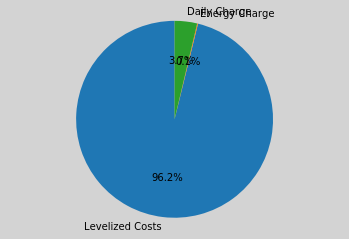

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[239.04601925672424, 258.0800433143168, 227.57108087039154, 39.93447475180433, 15.836275175146385, 54.12360643397267, 0.5834721520245336, 0.531592580558985, 0.4974312756078419, 3607.99, 349.361, 349.361, 0.0, 0.0, {'Levelized Costs': 3469.921, 'Energy Charge': 5.027000000000214, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61805.572107019, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (208.51271010674432, 145.48468412810422, 150.4698272488905, 19.731431782373562, 14.80647491091791, 42.02165095499542, 0.4827987687628451, 0.21717813370970684, 0.31541271680478117)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 209
                                           a tilt of 19.7
                                           and a gcr of 0.483


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4015159606933594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 14.8
                                           and a gcr of 0.217


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.339237928390503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 42.0
                                           and a gcr of 0.315


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4325337409973145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 198 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [289.081, 0.0, 0.0]


ERROR:ga_logger:Cost: 3423.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0068 /kWh
Total Cost of the system: $ 3,423 per year


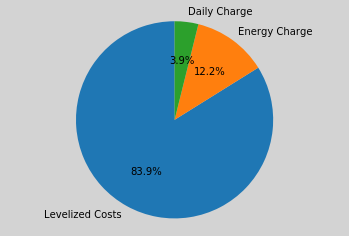

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[208.51271010674432, 145.48468412810422, 150.4698272488905, 19.731431782373562, 14.80647491091791, 42.02165095499542, 0.4827987687628451, 0.21717813370970684, 0.31541271680478117, 3423.34, 289.081, 289.081, 0.0, 0.0, {'Levelized Costs': 2871.22, 'Energy Charge': 419.0780000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58501.089378512384, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (221.31846143865081, 191.7489694357627, 193.90781614554015, 31.44793401826347, 29.49317679703246, 54.33621470522776, 0.3867938915538044, 0.7051075743718493, 0.6737090489449498)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 221
                                           a tilt of 31.4
                                           and a gcr of 0.387


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8529105186462402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 29.5
                                           and a gcr of 0.705


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6745059490203857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 54.3
                                           and a gcr of 0.674


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.78458571434021 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [0.0, 306.089, 0.0]


ERROR:ga_logger:Cost: 3173.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,173 per year


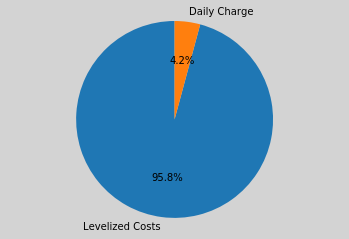

Total roof area of the  building: 599 m2
Total roof area used 434 m2
Percentage: 72.5%
succes
[[221.31846143865081, 191.7489694357627, 193.90781614554015, 31.44793401826347, 29.49317679703246, 54.33621470522776, 0.3867938915538044, 0.7051075743718493, 0.6737090489449498, 3173.2, 306.089, 0.0, 306.089, 0.0, {'Levelized Costs': 3040.1369999999997, 'Energy Charge': 0.02100000000024238, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60044826326, 61845.7, 434.103]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (137.38639899956527, 98.98361359737972, 176.32909698424402, 19.539799212445754, 2.6027332726331114, 31.326913904786817, 0.22549140946071425, 0.5653438349223632, 0.4377630138602326)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 19.5
                                           and a gcr of 0.225


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.801811695098877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 2.6
                                           and a gcr of 0.565


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.300973892211914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 31.3
                                           and a gcr of 0.438


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3903744220733643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 302.235, 28.0863]


ERROR:ga_logger:Cost: 3413.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,414 per year


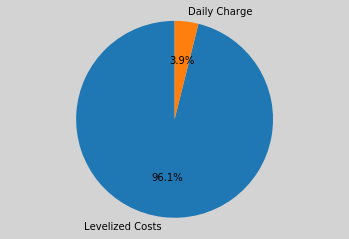

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[137.38639899956527, 98.98361359737972, 176.32909698424402, 19.539799212445754, 2.6027332726331114, 31.326913904786817, 0.22549140946071425, 0.5653438349223632, 0.4377630138602326, 3413.87, 330.3213, 0.0, 302.235, 28.0863, {'Levelized Costs': 3280.8179999999998, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601909803925, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (216.68995517250002, 240.02230067258517, 214.09080776677064, 8.454380544602888, 41.12058607564153, 47.08194087585489, 0.4925927925722616, 0.7864498090306231, 0.8410888365956795)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 217
                                           a tilt of 8.5
                                           and a gcr of 0.493


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8082528114318848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 41.1
                                           and a gcr of 0.786


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6860036849975586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 47.1
                                           and a gcr of 0.841


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.734388828277588 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [247.3, 0.0, 81.3544]


ERROR:ga_logger:Cost: 3397.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,397 per year


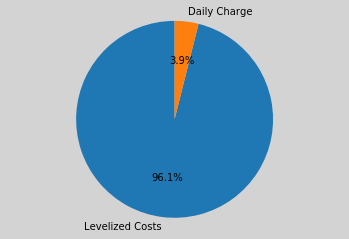

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[216.68995517250002, 240.02230067258517, 214.09080776677064, 8.454380544602888, 41.12058607564153, 47.08194087585489, 0.4925927925722616, 0.7864498090306231, 0.8410888365956795, 3397.31, 328.6544, 247.3, 0.0, 81.3544, {'Levelized Costs': 3264.2539999999995, 'Energy Charge': 0.014000000000464752, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60052941102, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (109.73205778387991, 179.23279875666702, 158.6241398733332, 7.99919968656889, 35.26305478092354, 3.9115437081816604, 0.3483249744718663, 0.7449226067885453, 0.8182818961699347)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 8.0
                                           and a gcr of 0.348


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.492650032043457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 35.3
                                           and a gcr of 0.745


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4903485774993896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 3.9
                                           and a gcr of 0.818


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4822027683258057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 309.531, 0.0]


ERROR:ga_logger:Cost: 3207.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,207 per year


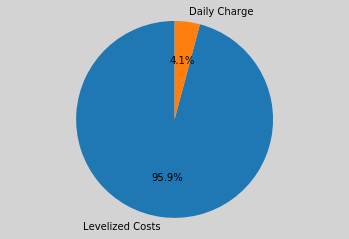

Total roof area of the  building: 599 m2
Total roof area used 416 m2
Percentage: 69.4%
succes
[[109.73205778387991, 179.23279875666702, 158.6241398733332, 7.99919968656889, 35.26305478092354, 3.9115437081816604, 0.3483249744718663, 0.7449226067885453, 0.8182818961699347, 3207.38, 309.531, 0.0, 309.531, 0.0, {'Levelized Costs': 3074.3269999999998, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59956489732, 61845.7, 415.52]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.5128706326744, 157.52352304105827, 232.67571923194473, 14.320865695291669, 6.6743664813937515, 54.08341165704421, 0.34633983155338527, 0.7745782410876045, 0.8276732620073881)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 14.3
                                           and a gcr of 0.346


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5947906970977783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 158
                                           a tilt of 6.7
                                           and a gcr of 0.775


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4352428913116455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 54.1
                                           and a gcr of 0.828


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.422659158706665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 167 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [0.0, 321.404, 0.0]


ERROR:ga_logger:Cost: 3325.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,325 per year


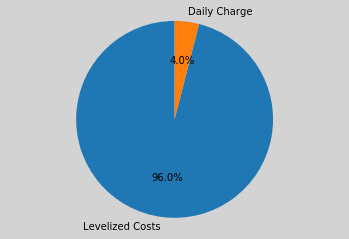

Total roof area of the  building: 599 m2
Total roof area used 415 m2
Percentage: 69.3%
succes
[[261.5128706326744, 157.52352304105827, 232.67571923194473, 14.320865695291669, 6.6743664813937515, 54.08341165704421, 0.34633983155338527, 0.7745782410876045, 0.8276732620073881, 3325.3, 321.404, 0.0, 321.404, 0.0, {'Levelized Costs': 3192.248, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60208052584, 61845.7, 414.94]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (157.3089264583839, 102.81163332763981, 228.87984268153096, 7.276564935307137, 8.773342223510046, 17.3605152106016, 0.305719374651765, 0.20453870033545937, 0.720891635642468)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 7.3
                                           and a gcr of 0.306


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6337897777557373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 8.8
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6249403953552246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 229
                                           a tilt of 17.4
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6678779125213623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 138s


ERROR:ga_logger:panel relevance: [80.1089, 0.0, 242.744]


ERROR:ga_logger:Cost: 3339.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,340 per year


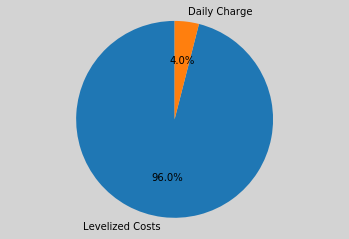

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[157.3089264583839, 102.81163332763981, 228.87984268153096, 7.276564935307137, 8.773342223510046, 17.3605152106016, 0.305719374651765, 0.20453870033545937, 0.720891635642468, 3339.7, 322.8529, 80.1089, 0.0, 242.744, {'Levelized Costs': 3206.6459999999997, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59994802053, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (236.24503773222537, 211.5592718547999, 228.13631402928982, 41.45259136241093, 31.12998708833454, 53.91790063911724, 0.4352410376510846, 0.8044961288467618, 0.7190285146203292)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 236
                                           a tilt of 41.5
                                           and a gcr of 0.435


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5151548385620117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 212
                                           a tilt of 31.1
                                           and a gcr of 0.804


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5028507709503174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 228
                                           a tilt of 53.9
                                           and a gcr of 0.719


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.613553762435913 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 132s


ERROR:ga_logger:panel relevance: [0.0, 327.956, 0.0]


ERROR:ga_logger:Cost: 3390.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,390 per year


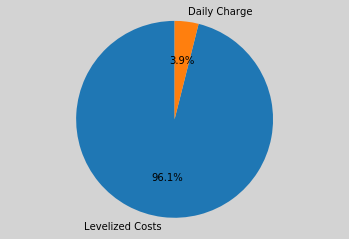

Total roof area of the  building: 599 m2
Total roof area used 408 m2
Percentage: 68.1%
succes
[[236.24503773222537, 211.5592718547999, 228.13631402928982, 41.45259136241093, 31.12998708833454, 53.91790063911724, 0.4352410376510846, 0.8044961288467618, 0.7190285146203292, 3390.38, 327.956, 0.0, 327.956, 0.0, {'Levelized Costs': 3257.3239999999996, 'Energy Charge': 0.014000000000407908, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60162602315, 61845.7, 407.654]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (181.3307305290765, 176.6875144916969, 128.77101026474574, 16.90795432741136, 5.926213538299915, 7.022327858534286, 0.35275392311006104, 0.45971708382509585, 0.4633585753488457)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 16.9
                                           and a gcr of 0.353


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6990463733673096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 5.9
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.377131938934326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 129
                                           a tilt of 7.0
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.386028528213501 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 275.261, 0.0]


ERROR:ga_logger:Cost: 3956.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0176 /kWh
Total Cost of the system: $ 3,956 per year


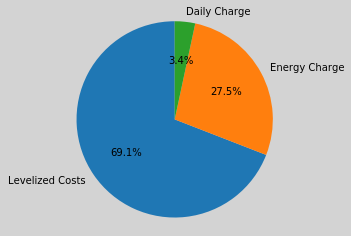

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[181.3307305290765, 176.6875144916969, 128.77101026474574, 16.90795432741136, 5.926213538299915, 7.022327858534286, 0.35275392311006104, 0.45971708382509585, 0.4633585753488457, 3956.39, 275.261, 0.0, 275.261, 0.0, {'Levelized Costs': 2733.9539999999997, 'Energy Charge': 1089.3940000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53151.385015200205, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (253.09411258340734, 141.54334060438302, 223.2943989039636, 22.507130188295402, 46.141939778941946, 51.436256461950535, 0.7344355158693763, 0.46414817528677665, 0.7266345203194163)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 253
                                           a tilt of 22.5
                                           and a gcr of 0.734


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6700034141540527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 142
                                           a tilt of 46.1
                                           and a gcr of 0.464


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.629542350769043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 223
                                           a tilt of 51.4
                                           and a gcr of 0.727


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5841188430786133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [153.727, 180.762, 0.0]


ERROR:ga_logger:Cost: 3455.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,455 per year


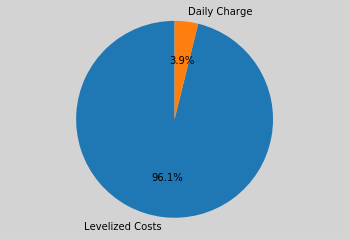

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[253.09411258340734, 141.54334060438302, 223.2943989039636, 22.507130188295402, 46.141939778941946, 51.436256461950535, 0.7344355158693763, 0.46414817528677665, 0.7266345203194163, 3455.27, 334.48900000000003, 153.727, 180.762, 0.0, {'Levelized Costs': 3322.219, 'Energy Charge': 0.008999999999900865, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603725571316, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (197.5018715634456, 143.27116972793442, 182.0344632989631, 19.28521734280218, 8.513575331344708, 47.71245407955948, 0.4669280607093526, 0.3855415840731971, 0.6644531989588524)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 19.3
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.745952844619751 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 143
                                           a tilt of 8.5
                                           and a gcr of 0.386


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.562366247177124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 47.7
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.567667007446289 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 160 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [219.385, 0.0, 85.6568]


ERROR:ga_logger:Cost: 3162.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,163 per year


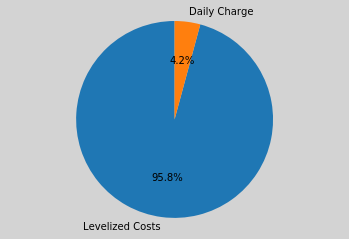

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[197.5018715634456, 143.27116972793442, 182.0344632989631, 19.28521734280218, 8.513575331344708, 47.71245407955948, 0.4669280607093526, 0.3855415840731971, 0.6644531989588524, 3162.8, 305.04179999999997, 219.385, 0.0, 85.6568, {'Levelized Costs': 3029.7450000000003, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601747831184, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.7211086228458, 176.19675924604167, 225.2626875460856, 22.337180770611347, 28.849171539825388, 30.31659900231069, 0.4193466019557283, 0.7517411988189715, 0.8327513618837293)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 22.3
                                           and a gcr of 0.419


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4892404079437256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 28.8
                                           and a gcr of 0.752


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.356907606124878 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 30.3
                                           and a gcr of 0.833


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3832626342773438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 307.837, 0.0]


ERROR:ga_logger:Cost: 3190.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,191 per year


Total roof area of the  building: 599 m2
Total roof area used 409 m2
Percentage: 68.4%
succes
[[135.7211086228458, 176.19675924604167, 225.2626875460856, 22.337180770611347, 28.849171539825388, 30.31659900231069, 0.4193466019557283, 0.7517411988189715, 0.8327513618837293, 3190.56, 307.837, 0.0, 307.837, 0.0, {'Levelized Costs': 3057.5080000000003, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60064616811, 61845.7, 409.499]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.62705865052885, 109.81488927394746, 173.00009035423594, 10.613869572360473, 22.07625938622669, 17.026352857006387, 0.23639323161453074, 0.39118159710394196, 0.6577463643558004)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 10.6
                                           and a gcr of 0.236


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.497925281524658 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 22.1
                                           and a gcr of 0.391


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3888630867004395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 17.0
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.508514165878296 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 799 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 426s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.675]


ERROR:ga_logger:Cost: 3169.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,169 per year


Total roof area of the  building: 599 m2
Total roof area used 465 m2
Percentage: 77.6%
succes
[[135.62705865052885, 109.81488927394746, 173.00009035423594, 10.613869572360473, 22.07625938622669, 17.026352857006387, 0.23639323161453074, 0.39118159710394196, 0.6577463643558004, 3169.09, 305.675, 0.0, 0.0, 305.675, {'Levelized Costs': 3036.027, 'Energy Charge': 0.02100000000007185, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60230547931, 61845.7, 464.731]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (222.6480231841756, 263.60779970416183, 186.67279583270897, 36.029889867503094, 39.6109709809328, 47.203235661205916, 0.7319715139067499, 0.7930900161294505, 0.8751687356105735)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 223
                                           a tilt of 36.0
                                           and a gcr of 0.732


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.330703973770142 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 39.6
                                           and a gcr of 0.793


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.124382257461548 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 47.2
                                           and a gcr of 0.875


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.063592433929443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  43 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 866 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 575s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 332.041]


ERROR:ga_logger:Cost: 3430.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,431 per year


Total roof area of the  building: 599 m2
Total roof area used 379 m2
Percentage: 63.4%
succes
[[222.6480231841756, 263.60779970416183, 186.67279583270897, 36.029889867503094, 39.6109709809328, 47.203235661205916, 0.7319715139067499, 0.7930900161294505, 0.8751687356105735, 3430.96, 332.041, 0.0, 0.0, 332.041, {'Levelized Costs': 3297.9060000000004, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601367482894, 61845.7, 379.403]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.16592372511144, 165.2920077050366, 93.20071337354338, 16.805190738499995, 8.371553440839545, 32.93942082028783, 0.3908840186276135, 0.6607395753137495, 0.5153118053479007)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 16.8
                                           and a gcr of 0.391


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.138809204101562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 8.4
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.839158773422241 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 32.9
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.163787126541138 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  47 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 961 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 428s


ERROR:ga_logger:panel relevance: [0.0, 316.491, 0.0]


ERROR:ga_logger:Cost: 3276.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,277 per year


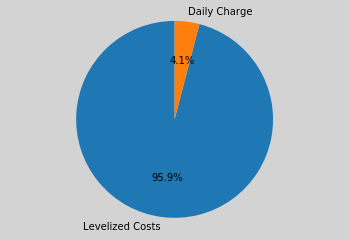

Total roof area of the  building: 599 m2
Total roof area used 479 m2
Percentage: 80.0%
succes
[[261.16592372511144, 165.2920077050366, 93.20071337354338, 16.805190738499995, 8.371553440839545, 32.93942082028783, 0.3908840186276135, 0.6607395753137495, 0.5153118053479007, 3276.51, 316.491, 0.0, 316.491, 0.0, {'Levelized Costs': 3143.4500000000003, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601832654575, 61845.7, 478.995]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.5128706326744, 180.48974663836626, 201.13427687144716, 16.617938287182604, 41.59666546571461, 46.69302033889875, 0.6732781177423873, 0.8387096723910187, 0.7706590297638626)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 16.6
                                           and a gcr of 0.673


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.994765281677246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 41.6
                                           and a gcr of 0.839


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.124845027923584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 201
                                           a tilt of 46.7
                                           and a gcr of 0.771


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.876946687698364 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  46 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 903 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 481s


ERROR:ga_logger:panel relevance: [0.0, 319.342, 0.0]


ERROR:ga_logger:Cost: 3304.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,305 per year


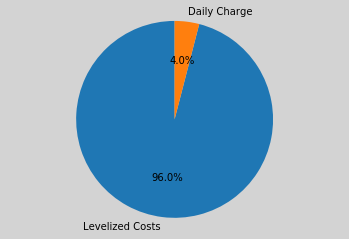

Total roof area of the  building: 599 m2
Total roof area used 381 m2
Percentage: 63.6%
succes
[[261.5128706326744, 180.48974663836626, 201.13427687144716, 16.617938287182604, 41.59666546571461, 46.69302033889875, 0.6732781177423873, 0.8387096723910187, 0.7706590297638626, 3304.82, 319.342, 0.0, 319.342, 0.0, {'Levelized Costs': 3171.7659999999996, 'Energy Charge': 0.012000000000568889, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60210231807, 61845.7, 380.754]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (206.93627079982664, 187.9660409244859, 164.8922857734881, 5.679571045384982, 3.1686808864730907, 17.108285888953766, 0.21398758531126066, 0.4225255494382772, 0.3809998114607792)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 207
                                           a tilt of 5.7
                                           and a gcr of 0.214


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.53078818321228 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 3.2
                                           and a gcr of 0.423


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.295797348022461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 17.1
                                           and a gcr of 0.381


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.471104145050049 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  44 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 828 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 479s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 228.128]


ERROR:ga_logger:Cost: 4286.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 46,643 kWh
At a cost of $ 0.0405 /kWh
Total Cost of the system: $ 4,286 per year


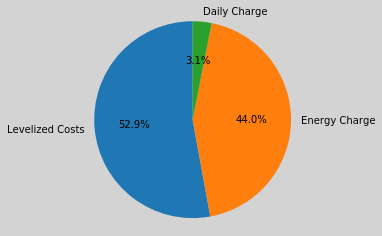

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[206.93627079982664, 187.9660409244859, 164.8922857734881, 5.679571045384982, 3.1686808864730907, 17.108285888953766, 0.21398758531126066, 0.4225255494382772, 0.3809998114607792, 4286.0, 228.128, 0.0, 0.0, 228.128, {'Levelized Costs': 2265.8138, 'Energy Charge': 1887.1442000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 46784.69594462008, 46642.6, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.59720889354486, 210.76328723896083, 177.39383567925194, 50.0286000821832, 35.16449659638504, 19.703043187132497, 0.38025155497201546, 0.6087363594799935, 0.5270200315865505)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 50.0
                                           and a gcr of 0.380


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.9192373752594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 211
                                           a tilt of 35.2
                                           and a gcr of 0.609


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.451099395751953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 177
                                           a tilt of 19.7
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.47018575668335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  44 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 897 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 603s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 300.14]


ERROR:ga_logger:Cost: 3114.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,114 per year


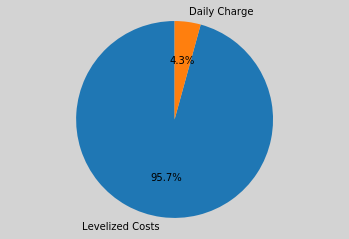

Total roof area of the  building: 599 m2
Total roof area used 570 m2
Percentage: 95.1%
succes
[[169.59720889354486, 210.76328723896083, 177.39383567925194, 50.0286000821832, 35.16449659638504, 19.703043187132497, 0.38025155497201546, 0.6087363594799935, 0.5270200315865505, 3114.11, 300.14, 0.0, 0.0, 300.14, {'Levelized Costs': 2981.061, 'Energy Charge': 0.006999999999891315, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60325217653, 61845.7, 569.504]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (91.09293170827765, 167.35550488556711, 101.1768538502988, 8.785910410893674, 28.505083243476577, 7.492464357615269, 0.2644850419636225, 0.4543628927789239, 0.46309974572908075)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 8.8
                                           and a gcr of 0.264


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.487553834915161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 28.5
                                           and a gcr of 0.454


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.429356813430786 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 7.5
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.436210870742798 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  45 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 504 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 272.055, 0.0]


ERROR:ga_logger:Cost: 3447.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0099 /kWh
Total Cost of the system: $ 3,447 per year


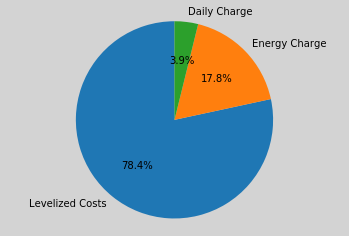

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[91.09293170827765, 167.35550488556711, 101.1768538502988, 8.785910410893674, 28.505083243476577, 7.492464357615269, 0.2644850419636225, 0.4543628927789239, 0.46309974572908075, 3447.3, 272.055, 0.0, 272.055, 0.0, {'Levelized Costs': 2702.1070000000004, 'Energy Charge': 612.1510000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56960.242003299936, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.02317932322636, 215.78280941179446, 204.48112019919884, 32.81573667621851, 28.045400939323397, 11.87719482331034, 0.8967596031813795, 0.8419665445775398, 0.6319051246992692)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 32.8
                                           and a gcr of 0.897


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.008461952209473 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 28.0
                                           and a gcr of 0.842


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.301466464996338 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 204
                                           a tilt of 11.9
                                           and a gcr of 0.632


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.431893348693848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  27 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 999 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 437s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.361]


ERROR:ga_logger:Cost: 3245.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,245 per year


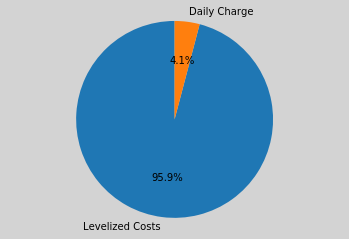

Total roof area of the  building: 599 m2
Total roof area used 496 m2
Percentage: 82.8%
succes
[[120.02317932322636, 215.78280941179446, 204.48112019919884, 32.81573667621851, 28.045400939323397, 11.87719482331034, 0.8967596031813795, 0.8419665445775398, 0.6319051246992692, 3245.42, 313.361, 0.0, 0.0, 313.361, {'Levelized Costs': 3112.3700000000003, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59995741945, 61845.7, 495.899]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (112.94147777948797, 90.1089607703127, 143.5070451237719, 17.215726404659407, 19.781155199709257, 11.386306695033422, 0.3471107452411494, 0.3796586334443742, 0.5984443173367381)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 17.2
                                           and a gcr of 0.347


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.496328830718994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 19.8
                                           and a gcr of 0.380


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.236263513565063 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 11.4
                                           and a gcr of 0.598


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.009753704071045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  41 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 981 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 448s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.22]


ERROR:ga_logger:Cost: 3263.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,264 per year


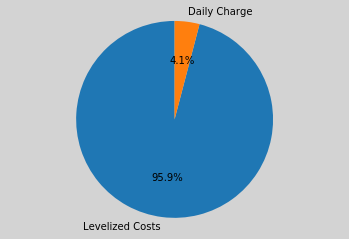

Total roof area of the  building: 599 m2
Total roof area used 527 m2
Percentage: 88.0%
succes
[[112.94147777948797, 90.1089607703127, 143.5070451237719, 17.215726404659407, 19.781155199709257, 11.386306695033422, 0.3471107452411494, 0.3796586334443742, 0.5984443173367381, 3263.88, 315.22, 0.0, 0.0, 315.22, {'Levelized Costs': 3130.828, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60209855482, 61845.7, 526.732]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.45335544162765, 136.21337851756195, 229.09960705929348, 47.34848958761205, 55.79129859365295, 4.374911964166873, 0.7780115896129776, 0.6513729110664339, 0.6521425366832078)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 47.3
                                           and a gcr of 0.778


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.496354818344116 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 136
                                           a tilt of 55.8
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4004018306732178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 229
                                           a tilt of 4.4
                                           and a gcr of 0.652


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4550459384918213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 159 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 375s


ERROR:ga_logger:panel relevance: [323.339, 0.0, 0.0]


ERROR:ga_logger:Cost: 3344.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,345 per year


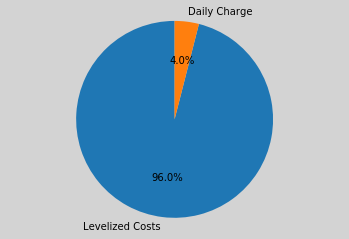

Total roof area of the  building: 599 m2
Total roof area used 416 m2
Percentage: 69.4%
succes
[[186.45335544162765, 136.21337851756195, 229.09960705929348, 47.34848958761205, 55.79129859365295, 4.374911964166873, 0.7780115896129776, 0.6513729110664339, 0.6521425366832078, 3344.53, 323.339, 323.339, 0.0, 0.0, {'Levelized Costs': 3211.474, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599755001225, 61845.7, 415.597]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (99.46443790727781, 118.9279576117038, 222.03883735820784, 45.70505688461133, 43.645001380227754, 1.7791872003233928, 0.4552988133600592, 0.6472242524238295, 0.39246015895591047)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 99
                                           a tilt of 45.7
                                           and a gcr of 0.455


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.660101175308228 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 119
                                           a tilt of 43.6
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.648852586746216 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 1.8
                                           and a gcr of 0.392


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.159663915634155 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  46 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 925 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 418s


ERROR:ga_logger:panel relevance: [0.0, 319.943, 40.9846]


ERROR:ga_logger:Cost: 3717.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,718 per year


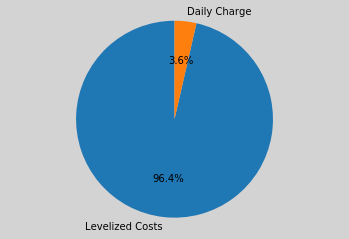

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[99.46443790727781, 118.9279576117038, 222.03883735820784, 45.70505688461133, 43.645001380227754, 1.7791872003233928, 0.4552988133600592, 0.6472242524238295, 0.39246015895591047, 3717.87, 360.9276, 0.0, 319.943, 40.9846, {'Levelized Costs': 3584.819, 'Energy Charge': 0.009000000000241926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59984170003, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.7033649838731, 203.3602425866278, 181.45616213901232, 12.166830777931876, 51.11107512429667, 32.4583161275964, 0.45761872040330076, 0.6573016833192566, 0.5497465145294529)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 12.2
                                           and a gcr of 0.458


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 52.079750061035156 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 51.1
                                           and a gcr of 0.657


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.264820575714111 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 32.5
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.965202331542969 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  83 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 843 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 448s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.957]


ERROR:ga_logger:Cost: 3072.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,073 per year


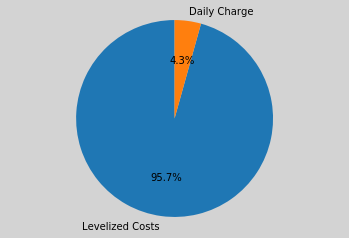

Total roof area of the  building: 599 m2
Total roof area used 538 m2
Percentage: 89.9%
succes
[[108.7033649838731, 203.3602425866278, 181.45616213901232, 12.166830777931876, 51.11107512429667, 32.4583161275964, 0.45761872040330076, 0.6573016833192566, 0.5497465145294529, 3072.56, 295.957, 0.0, 0.0, 295.957, {'Levelized Costs': 2939.5089999999996, 'Energy Charge': 0.009000000000298769, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60244824268, 61845.7, 538.352]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (91.7481829670867, 171.77410245432154, 92.65674850390113, 5.693787035706574, 48.76300461924855, 19.161774017363012, 0.4187969025872696, 0.42691908103102544, 0.48563768080616165)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 5.7
                                           and a gcr of 0.419


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.279200553894043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 48.8
                                           and a gcr of 0.427


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.389095067977905 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 19.2
                                           and a gcr of 0.486


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 12.50243091583252 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  42 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 1011 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 449s


ERROR:ga_logger:panel relevance: [0.0, 255.623, 0.0]


ERROR:ga_logger:Cost: 3928.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0203 /kWh
Total Cost of the system: $ 3,928 per year


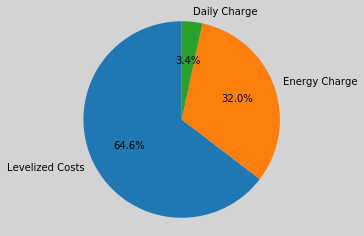

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[91.7481829670867, 171.77410245432154, 92.65674850390113, 5.693787035706574, 48.76300461924855, 19.161774017363012, 0.4187969025872696, 0.42691908103102544, 0.48563768080616165, 3928.2, 255.623, 0.0, 255.623, 0.0, {'Levelized Costs': 2538.899, 'Energy Charge': 1256.259, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51819.68988830015, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (109.43103979595932, 264.230175113645, 251.27355889548474, 43.05035793773096, 14.27728779469928, 55.15766364235149, 0.8887230350236821, 0.5084980313746289, 0.7835152171614266)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 43.1
                                           and a gcr of 0.889


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.734612464904785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 14.3
                                           and a gcr of 0.508


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.11715579032898 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 251
                                           a tilt of 55.2
                                           and a gcr of 0.784


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 13.479322910308838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  45 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 888 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 280s


ERROR:ga_logger:panel relevance: [157.21, 214.519, 0.0]


ERROR:ga_logger:Cost: 3825.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,825 per year


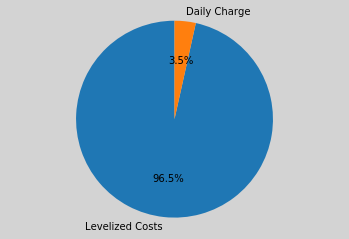

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[109.43103979595932, 264.230175113645, 251.27355889548474, 43.05035793773096, 14.27728779469928, 55.15766364235149, 0.8887230350236821, 0.5084980313746289, 0.7835152171614266, 3825.14, 371.72900000000004, 157.21, 214.519, 0.0, {'Levelized Costs': 3692.0849999999996, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601483359926, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (96.88376536377322, 251.18814309288834, 134.18880856011913, 41.63610569012581, 1.2114354270595102, 1.7733799904888805, 0.3529444232906578, 0.27586670550323306, 0.5943505070130386)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 97
                                           a tilt of 41.6
                                           and a gcr of 0.353


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7049787044525146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 251
                                           a tilt of 1.2
                                           and a gcr of 0.276


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4756364822387695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 134
                                           a tilt of 1.8
                                           and a gcr of 0.594


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4038782119750977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  16 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 332.173]


ERROR:ga_logger:Cost: 3432.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,432 per year


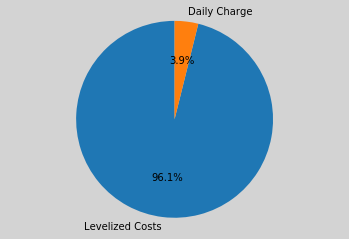

Total roof area of the  building: 599 m2
Total roof area used 559 m2
Percentage: 93.3%
succes
[[96.88376536377322, 251.18814309288834, 134.18880856011913, 41.63610569012581, 1.2114354270595102, 1.7733799904888805, 0.3529444232906578, 0.27586670550323306, 0.5943505070130386, 3432.26, 332.173, 0.0, 0.0, 332.173, {'Levelized Costs': 3299.2000000000003, 'Energy Charge': 0.017999999999915417, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60118599715, 61845.7, 558.883]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.30147125502344, 115.41711748180242, 200.23709757108654, 26.500613496174388, 37.28958071280542, 26.672876884872316, 0.7391646872091246, 0.5457979261325746, 0.7370656990903668)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 26.5
                                           and a gcr of 0.739


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5837764739990234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 37.3
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3910176753997803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 26.7
                                           and a gcr of 0.737


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3790555000305176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 170 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.327]


ERROR:ga_logger:Cost: 3225.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,225 per year


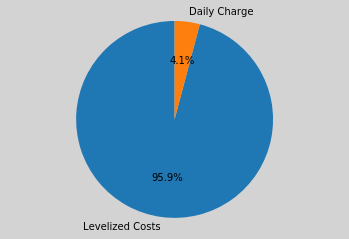

Total roof area of the  building: 599 m2
Total roof area used 422 m2
Percentage: 70.5%
succes
[[241.30147125502344, 115.41711748180242, 200.23709757108654, 26.500613496174388, 37.28958071280542, 26.672876884872316, 0.7391646872091246, 0.5457979261325746, 0.7370656990903668, 3225.22, 311.327, 0.0, 0.0, 311.327, {'Levelized Costs': 3092.169, 'Energy Charge': 0.009000000000071395, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60003048334, 61845.7, 422.388]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (235.25776136785706, 95.9703461323725, 153.00226974848647, 47.14912997042204, 32.8097695449151, 1.5809262769972254, 0.6155932075487004, 0.5070555337542694, 0.276062773727214)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 47.1
                                           and a gcr of 0.616


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.443856239318848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 32.8
                                           and a gcr of 0.507


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7250757217407227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 153
                                           a tilt of 1.6
                                           and a gcr of 0.276


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6232457160949707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [354.345, 0.0, 6.38961]


ERROR:ga_logger:Cost: 3715.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,716 per year


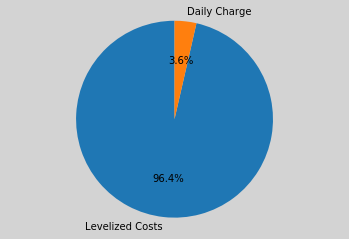

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[235.25776136785706, 95.9703461323725, 153.00226974848647, 47.14912997042204, 32.8097695449151, 1.5809262769972254, 0.6155932075487004, 0.5070555337542694, 0.276062773727214, 3715.95, 360.73461000000003, 354.345, 0.0, 6.38961, {'Levelized Costs': 3582.895, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60099485091, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.9099814949507, 189.55430546385807, 208.19203761562486, 11.871148290250897, 52.627530802461465, 43.443009811042, 0.6298211623571042, 0.5714952075801019, 0.8998317252226835)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 11.9
                                           and a gcr of 0.630


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.776588201522827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 52.6
                                           and a gcr of 0.571


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5408148765563965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 43.4
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.486483097076416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 221 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [312.26, 0.0, 0.0]


ERROR:ga_logger:Cost: 3234.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,234 per year


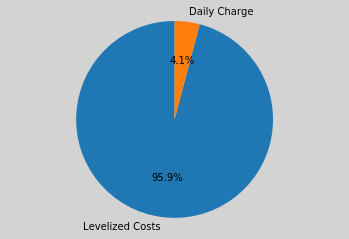

Total roof area of the  building: 599 m2
Total roof area used 496 m2
Percentage: 82.8%
succes
[[199.9099814949507, 189.55430546385807, 208.19203761562486, 11.871148290250897, 52.627530802461465, 43.443009811042, 0.6298211623571042, 0.5714952075801019, 0.8998317252226835, 3234.48, 312.26, 312.26, 0.0, 0.0, {'Levelized Costs': 3101.424, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60252347558, 61845.7, 495.791]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.7918176272089, 182.82661721352483, 169.61683417354095, 1.970344401664235, 39.43724040388732, 17.38917537778122, 0.40687083986369865, 0.42183725658735316, 0.3895675880673374)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 2.0
                                           and a gcr of 0.407


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4703867435455322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 39.4
                                           and a gcr of 0.422


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.471043586730957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 17.4
                                           and a gcr of 0.390


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6638758182525635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 195 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 252.58, 0.0]


ERROR:ga_logger:Cost: 3745.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0178 /kWh
Total Cost of the system: $ 3,745 per year


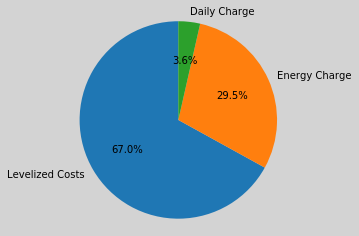

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[261.7918176272089, 182.82661721352483, 169.61683417354095, 1.970344401664235, 39.43724040388732, 17.38917537778122, 0.40687083986369865, 0.42183725658735316, 0.3895675880673374, 3745.29, 252.58, 0.0, 252.58, 0.0, {'Levelized Costs': 2508.6789999999996, 'Energy Charge': 1103.5690000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53038.29577312107, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.4951400729515, 170.79041381967284, 168.04235335087486, 50.40539120696543, 44.047850553711186, 39.613533219161056, 0.4670122195415047, 0.8443121515898299, 0.31873351392223737)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 50.4
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6515378952026367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 44.0
                                           and a gcr of 0.844


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5148816108703613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 39.6
                                           and a gcr of 0.319


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4358835220336914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 193 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [236.508, 77.9583, 0.0]


ERROR:ga_logger:Cost: 3256.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,256 per year


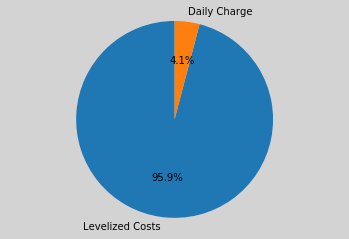

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[169.4951400729515, 170.79041381967284, 168.04235335087486, 50.40539120696543, 44.047850553711186, 39.613533219161056, 0.4670122195415047, 0.8443121515898299, 0.31873351392223737, 3256.4, 314.4663, 236.508, 77.9583, 0.0, {'Levelized Costs': 3123.344, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599838500166, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (148.95639710617326, 184.47546925393394, 123.93253805682117, 13.244925620205333, 40.79540798500502, 18.782455215339436, 0.25369576890055767, 0.7573832943727041, 0.25490819276315935)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 13.2
                                           and a gcr of 0.254


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5354843139648438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 184
                                           a tilt of 40.8
                                           and a gcr of 0.757


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4509029388427734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 18.8
                                           and a gcr of 0.255


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.454169273376465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 225 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 145s


ERROR:ga_logger:panel relevance: [71.0887, 241.264, 0.0]


ERROR:ga_logger:Cost: 3235.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,235 per year


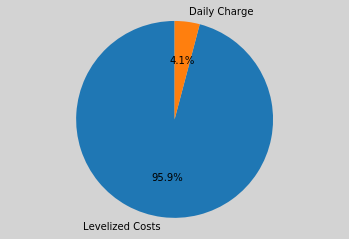

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[148.95639710617326, 184.47546925393394, 123.93253805682117, 13.244925620205333, 40.79540798500502, 18.782455215339436, 0.25369576890055767, 0.7573832943727041, 0.25490819276315935, 3235.41, 312.3527, 71.0887, 241.264, 0.0, {'Levelized Costs': 3102.352, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601644209964, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (246.0247432576115, 212.92846368215064, 260.7942734391622, 43.16236779148039, 39.81833909252509, 23.116266513750833, 0.5568570553933917, 0.6751819479383012, 0.585394606315137)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 246
                                           a tilt of 43.2
                                           and a gcr of 0.557


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.93442702293396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 39.8
                                           and a gcr of 0.675


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.702721357345581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 23.1
                                           and a gcr of 0.585


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7660696506500244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 122s


ERROR:ga_logger:panel relevance: [0.0, 325.675, 0.0]


ERROR:ga_logger:Cost: 3367.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,368 per year


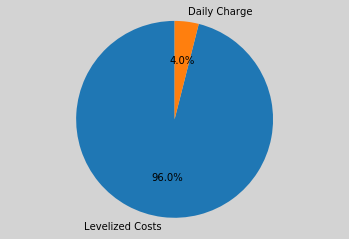

Total roof area of the  building: 599 m2
Total roof area used 482 m2
Percentage: 80.6%
succes
[[246.0247432576115, 212.92846368215064, 260.7942734391622, 43.16236779148039, 39.81833909252509, 23.116266513750833, 0.5568570553933917, 0.6751819479383012, 0.585394606315137, 3367.73, 325.675, 0.0, 325.675, 0.0, {'Levelized Costs': 3234.674, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60010803243, 61845.7, 482.352]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (149.1640297387128, 183.40056660460192, 90.51892227150992, 1.2584160971595195, 34.55245812086566, 18.21938872123087, 0.4288550837022299, 0.45268681818179446, 0.43538008010167273)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 1.3
                                           and a gcr of 0.429


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2858469486236572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 34.6
                                           and a gcr of 0.453


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.479247808456421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 18.2
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.483613967895508 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 271.052, 0.0]


ERROR:ga_logger:Cost: 3423.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0097 /kWh
Total Cost of the system: $ 3,424 per year


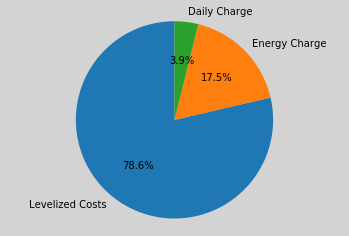

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[149.1640297387128, 183.40056660460192, 90.51892227150992, 1.2584160971595195, 34.55245812086566, 18.21938872123087, 0.4288550837022299, 0.45268681818179446, 0.43538008010167273, 3423.6, 271.052, 0.0, 271.052, 0.0, {'Levelized Costs': 2692.144, 'Energy Charge': 598.4140000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57069.852777672895, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225.07866632916247, 263.6851964705484, 198.43258097128407, 34.977052903008094, 53.70087052684104, 26.707709532908325, 0.6659330332725479, 0.6156055774069635, 0.3415660636292526)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 35.0
                                           and a gcr of 0.666


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9243152141571045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 53.7
                                           and a gcr of 0.616


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6950180530548096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 26.7
                                           and a gcr of 0.342


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7112317085266113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 155s


ERROR:ga_logger:panel relevance: [240.851, 0.0, 80.9811]


ERROR:ga_logger:Cost: 3329.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,330 per year


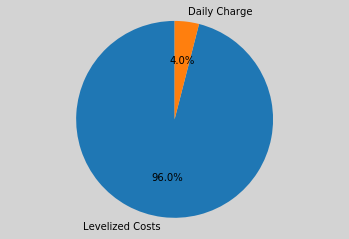

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[225.07866632916247, 263.6851964705484, 198.43258097128407, 34.977052903008094, 53.70087052684104, 26.707709532908325, 0.6659330332725479, 0.6156055774069635, 0.3415660636292526, 3329.55, 321.83209999999997, 240.851, 0.0, 80.9811, {'Levelized Costs': 3196.4950000000003, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60134851688, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (196.259674544969, 124.34893392334953, 92.09306589704761, 34.09252010645834, 43.68289450753693, 2.3138276745942017, 0.33722823400697677, 0.5911154535148451, 0.8756278094802046)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 196
                                           a tilt of 34.1
                                           and a gcr of 0.337


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4704856872558594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 124
                                           a tilt of 43.7
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.475386619567871 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 2.3
                                           and a gcr of 0.876


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.408390522003174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 213 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [129.489, 0.0, 188.067]


ERROR:ga_logger:Cost: 3287.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,287 per year


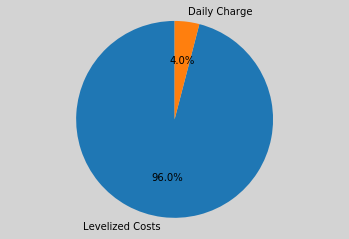

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[196.259674544969, 124.34893392334953, 92.09306589704761, 34.09252010645834, 43.68289450753693, 2.3138276745942017, 0.33722823400697677, 0.5911154535148451, 0.8756278094802046, 3287.1, 317.55600000000004, 129.489, 0.0, 188.067, {'Levelized Costs': 3154.053, 'Energy Charge': 0.005000000000109139, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601601565366, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (129.58268981704984, 137.7457662512064, 225.51221349900163, 48.33313012418461, 5.080353820240689, 40.31428555633058, 0.5537295435534381, 0.35648956719487285, 0.6967922270211205)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 48.3
                                           and a gcr of 0.554


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5215554237365723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 138
                                           a tilt of 5.1
                                           and a gcr of 0.356


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.861046075820923 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 40.3
                                           and a gcr of 0.697


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4490609169006348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 213 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 82.324, 256.303]


ERROR:ga_logger:Cost: 3496.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,496 per year


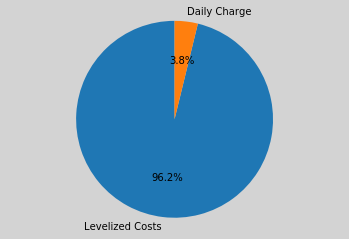

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[129.58268981704984, 137.7457662512064, 225.51221349900163, 48.33313012418461, 5.080353820240689, 40.31428555633058, 0.5537295435534381, 0.35648956719487285, 0.6967922270211205, 3496.36, 338.627, 0.0, 82.324, 256.303, {'Levelized Costs': 3363.301, 'Energy Charge': 0.017000000000336968, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60027127151, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (107.48697509424765, 121.13615583316009, 124.174958259408, 25.029297201654344, 3.1502863670600045, 36.833762129085365, 0.2415086662940053, 0.4913615789599954, 0.42457382143088784)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 107
                                           a tilt of 25.0
                                           and a gcr of 0.242


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.557512044906616 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 3.2
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3680777549743652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 36.8
                                           and a gcr of 0.425


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.981878757476807 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 171 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 294.208, 0.0]


ERROR:ga_logger:Cost: 3910.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0138 /kWh
Total Cost of the system: $ 3,910 per year


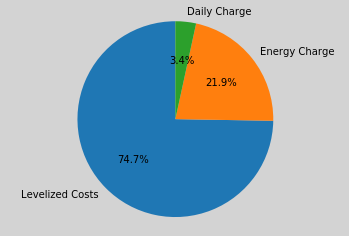

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[107.48697509424765, 121.13615583316009, 124.174958259408, 25.029297201654344, 3.1502863670600045, 36.833762129085365, 0.2415086662940053, 0.4913615789599954, 0.42457382143088784, 3910.04, 294.208, 0.0, 294.208, 0.0, {'Levelized Costs': 2922.1349999999998, 'Energy Charge': 854.863, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55023.194248829765, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (183.1545658291429, 122.09144049156593, 233.787506909625, 41.43625935923189, 55.995979090495354, 35.05006371032652, 0.5534126858754377, 0.6698033842854922, 0.6514041234561285)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 41.4
                                           and a gcr of 0.553


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.500281810760498 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 122
                                           a tilt of 56.0
                                           and a gcr of 0.670


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5264639854431152 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 35.1
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.553429126739502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 213 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [300.793, 0.0, 0.0]


ERROR:ga_logger:Cost: 3120.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,121 per year


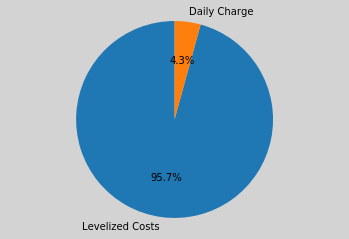

Total roof area of the  building: 599 m2
Total roof area used 544 m2
Percentage: 90.8%
succes
[[183.1545658291429, 122.09144049156593, 233.787506909625, 41.43625935923189, 55.995979090495354, 35.05006371032652, 0.5534126858754377, 0.6698033842854922, 0.6514041234561285, 3120.59, 300.793, 300.793, 0.0, 0.0, {'Levelized Costs': 2987.538, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602126774815, 61845.7, 543.524]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (182.88329780249697, 115.95493007810528, 157.51512972124323, 38.418042011194245, 19.03139689808749, 3.0039234351393542, 0.46111290396832955, 0.5272084194881445, 0.6268243002743573)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 38.4
                                           and a gcr of 0.461


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.631854295730591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 116
                                           a tilt of 19.0
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8654749393463135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 158
                                           a tilt of 3.0
                                           and a gcr of 0.627


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.694535970687866 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 203 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [190.602, 0.0, 116.22]


ERROR:ga_logger:Cost: 3180.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,180 per year


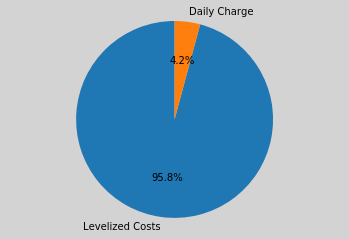

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[182.88329780249697, 115.95493007810528, 157.51512972124323, 38.418042011194245, 19.03139689808749, 3.0039234351393542, 0.46111290396832955, 0.5272084194881445, 0.6268243002743573, 3180.47, 306.822, 190.602, 0.0, 116.22, {'Levelized Costs': 3047.4159999999997, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60111147387, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (202.97698038046218, 178.43812607360036, 167.03932632364746, 22.434355517621455, 43.51874502324504, 17.19642128368332, 0.6243163584383683, 0.5009076719932213, 0.3805554162273144)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 203
                                           a tilt of 22.4
                                           and a gcr of 0.624


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4922120571136475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 43.5
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.512795925140381 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 17.2
                                           and a gcr of 0.381


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5265042781829834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 231 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 114s


ERROR:ga_logger:panel relevance: [9.87948, 291.998, 0.0]


ERROR:ga_logger:Cost: 3131.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,131 per year


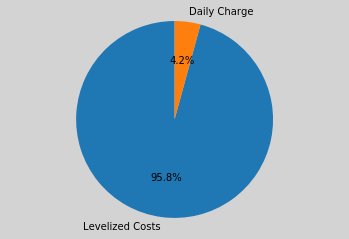

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[202.97698038046218, 178.43812607360036, 167.03932632364746, 22.434355517621455, 43.51874502324504, 17.19642128368332, 0.6243163584383683, 0.5009076719932213, 0.3805554162273144, 3131.36, 301.87748, 9.87948, 291.998, 0.0, {'Levelized Costs': 2998.304, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60039596395, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.62303118520465, 168.086051683015, 147.34445767178, 5.679571045384982, 10.213481923480595, 8.319366262563632, 0.7069306256609746, 0.22208791551151014, 0.27023776445125547)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 5.7
                                           and a gcr of 0.707


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.492048501968384 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 168
                                           a tilt of 10.2
                                           and a gcr of 0.222


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.622236967086792 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 147
                                           a tilt of 8.3
                                           and a gcr of 0.270


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6168270111083984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [279.927, 45.0364, 0.0]


ERROR:ga_logger:Cost: 3360.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,361 per year


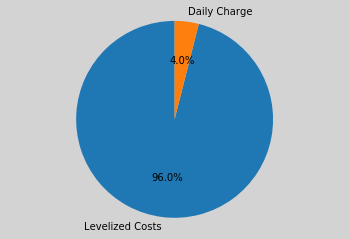

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.62303118520465, 168.086051683015, 147.34445767178, 5.679571045384982, 10.213481923480595, 8.319366262563632, 0.7069306256609746, 0.22208791551151014, 0.27023776445125547, 3360.66, 324.96340000000004, 279.927, 45.0364, 0.0, {'Levelized Costs': 3227.6069999999995, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60126257582, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225.64106747595648, 202.8992327863945, 254.7897644091769, 47.27495474647814, 51.633482528197085, 14.984020303239408, 0.4555180852041893, 0.6412747875346029, 0.6578447839191066)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 47.3
                                           and a gcr of 0.456


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9017443656921387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 51.6
                                           and a gcr of 0.641


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7591943740844727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 15.0
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.776010274887085 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 187 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [0.0, 330.747, 0.0]


ERROR:ga_logger:Cost: 3418.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,418 per year


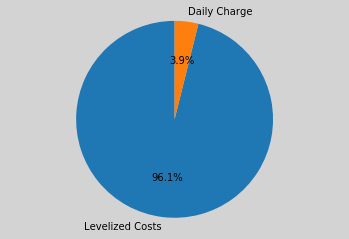

Total roof area of the  building: 599 m2
Total roof area used 516 m2
Percentage: 86.1%
succes
[[225.64106747595648, 202.8992327863945, 254.7897644091769, 47.27495474647814, 51.633482528197085, 14.984020303239408, 0.4555180852041893, 0.6412747875346029, 0.6578447839191066, 3418.1, 330.747, 0.0, 330.747, 0.0, {'Levelized Costs': 3285.0429999999997, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60024623087, 61845.7, 515.764]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (182.88337920354584, 114.89689490710401, 231.2574538416934, 46.45551536196767, 35.559586580405764, 2.7831006924088593, 0.31893880418334697, 0.6329474618118728, 0.5144157394800367)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 46.5
                                           and a gcr of 0.319


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.506093740463257 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 35.6
                                           and a gcr of 0.633


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.413381338119507 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 2.8
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2491703033447266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 186.175, 156.702]


ERROR:ga_logger:Cost: 3538.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,539 per year


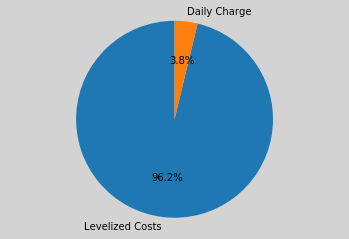

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[182.88337920354584, 114.89689490710401, 231.2574538416934, 46.45551536196767, 35.559586580405764, 2.7831006924088593, 0.31893880418334697, 0.6329474618118728, 0.5144157394800367, 3538.58, 342.877, 0.0, 186.175, 156.702, {'Levelized Costs': 3405.529, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598869239824, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (262.96821657711564, 259.1312916613375, 221.64438417245998, 16.617938287182604, 38.953729824217476, 49.67149135249687, 0.809265566271167, 0.7956374542823714, 0.763778274758419)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 16.6
                                           and a gcr of 0.809


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.954637289047241 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 39.0
                                           and a gcr of 0.796


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.598337411880493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 49.7
                                           and a gcr of 0.764


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.566408634185791 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [357.589, 0.0, 0.0]


ERROR:ga_logger:Cost: 3684.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,685 per year


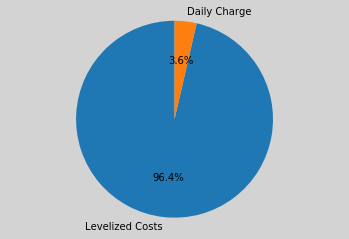

Total roof area of the  building: 599 m2
Total roof area used 442 m2
Percentage: 73.8%
succes
[[262.96821657711564, 259.1312916613375, 221.64438417245998, 16.617938287182604, 38.953729824217476, 49.67149135249687, 0.809265566271167, 0.7956374542823714, 0.763778274758419, 3684.7, 357.589, 357.589, 0.0, 0.0, {'Levelized Costs': 3551.6459999999997, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60410649047, 61845.7, 441.868]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240.09303772568103, 165.85849896871972, 112.00188930441274, 3.231077136580514, 2.3425925682032744, 52.13115117716822, 0.29092905661368834, 0.20488621250037947, 0.523809018865293)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 3.2
                                           and a gcr of 0.291


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.550715684890747 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 2.3
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.533148765563965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 112
                                           a tilt of 52.1
                                           and a gcr of 0.524


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.41421103477478 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 181 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.637]


ERROR:ga_logger:Cost: 4643.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0226 /kWh
Total Cost of the system: $ 4,643 per year


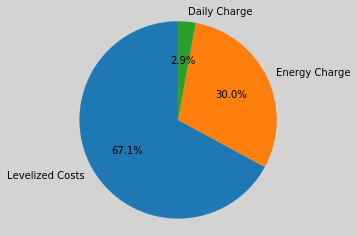

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[240.09303772568103, 165.85849896871972, 112.00188930441274, 3.231077136580514, 2.3425925682032744, 52.13115117716822, 0.29092905661368834, 0.20488621250037947, 0.523809018865293, 4643.06, 313.637, 0.0, 0.0, 313.637, {'Levelized Costs': 3115.105000000001, 'Energy Charge': 1394.9129999999998, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 50713.13878619997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (251.6233626034853, 129.6064811636346, 182.84993514660715, 19.958079256233948, 50.52358559609928, 47.87058058695515, 0.4669280607093526, 0.4984649033305619, 0.6611960740810764)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 20.0
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4811413288116455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 50.5
                                           and a gcr of 0.498


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.439833879470825 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 47.9
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.312551498413086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 213 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.681]


ERROR:ga_logger:Cost: 3248.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,249 per year


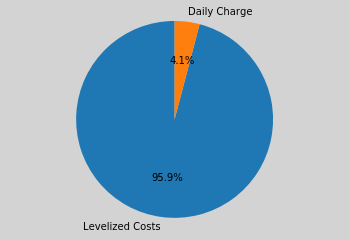

Total roof area of the  building: 599 m2
Total roof area used 474 m2
Percentage: 79.2%
succes
[[251.6233626034853, 129.6064811636346, 182.84993514660715, 19.958079256233948, 50.52358559609928, 47.87058058695515, 0.4669280607093526, 0.4984649033305619, 0.6611960740810764, 3248.6, 313.681, 0.0, 0.0, 313.681, {'Levelized Costs': 3115.546, 'Energy Charge': 0.012000000000000455, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6020843413, 61845.7, 474.415]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (251.6233626034853, 151.95857320173917, 182.78169097826665, 19.58059810653548, 50.52358559609928, 44.98928477895776, 0.4666997002599707, 0.4984649033305619, 0.6611960740810764)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 19.6
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7177655696868896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 50.5
                                           and a gcr of 0.498


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.663217544555664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 45.0
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5841751098632812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 184 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.183]


ERROR:ga_logger:Cost: 3213.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,214 per year


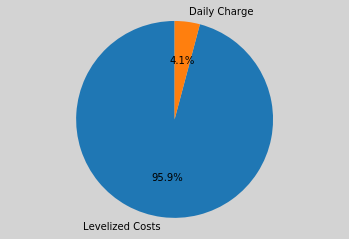

Total roof area of the  building: 599 m2
Total roof area used 469 m2
Percentage: 78.3%
succes
[[251.6233626034853, 151.95857320173917, 182.78169097826665, 19.58059810653548, 50.52358559609928, 44.98928477895776, 0.4666997002599707, 0.4984649033305619, 0.6611960740810764, 3213.85, 310.183, 0.0, 0.0, 310.183, {'Levelized Costs': 3080.794, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601158354715, 61845.7, 469.124]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230.2544830164121, 227.34023543831617, 212.98042550188467, 19.343240672600345, 51.47169919525945, 26.707709532908325, 0.4958928158484472, 0.786429051235885, 0.7973232493799856)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 19.3
                                           and a gcr of 0.496


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4960973262786865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 227
                                           a tilt of 51.5
                                           and a gcr of 0.786


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.464492082595825 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 213
                                           a tilt of 26.7
                                           and a gcr of 0.797


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.677016019821167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 210 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [260.796, 0.0, 58.0841]


ERROR:ga_logger:Cost: 3300.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,300 per year


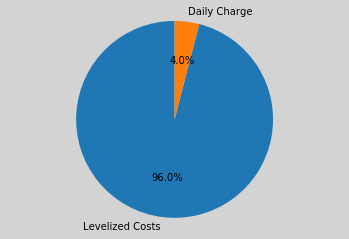

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[230.2544830164121, 227.34023543831617, 212.98042550188467, 19.343240672600345, 51.47169919525945, 26.707709532908325, 0.4958928158484472, 0.786429051235885, 0.7973232493799856, 3300.24, 318.88009999999997, 260.796, 0.0, 58.0841, {'Levelized Costs': 3167.185, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60111274993, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (216.68995517250002, 179.25785507606503, 197.79726613715974, 11.234430001673704, 34.92525749379878, 2.3428297853732523, 0.5079652322319002, 0.5281627754001764, 0.3050977423174194)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 217
                                           a tilt of 11.2
                                           and a gcr of 0.508


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.848401784896851 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 34.9
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.43868350982666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 2.3
                                           and a gcr of 0.305


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3990747928619385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


succes
[[216.68995517250002, 179.25785507606503, 197.79726613715974, 11.234430001673704, 34.92525749379878, 2.3428297853732523, 0.5079652322319002, 0.5281627754001764, 0.3050977423174194, 90000000000, 0, 0.0, 0.0, 0.0, {'Levelized Costs': 0, 'Energy Charge': 10000000000, 'Demand Charge': 0, 'Daily Charge': 0}, 90000000000, 90000000000, 0]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (262.87321712539614, 190.43452508324287, 206.48896171201883, 16.873330412579936, 47.360320982652034, 45.81808210024268, 0.5495483098989872, 0.6258461834880785, 0.8809559747370135)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 16.9
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6356523036956787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 47.4
                                           and a gcr of 0.626


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.549880266189575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 45.8
                                           and a gcr of 0.881


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.551788568496704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 314.06, 0.0]


ERROR:ga_logger:Cost: 3252.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,252 per year


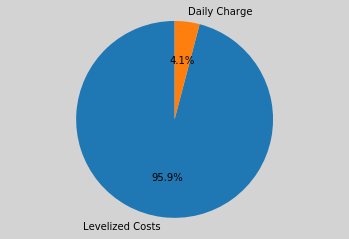

Total roof area of the  building: 599 m2
Total roof area used 502 m2
Percentage: 83.8%
succes
[[262.87321712539614, 190.43452508324287, 206.48896171201883, 16.873330412579936, 47.360320982652034, 45.81808210024268, 0.5495483098989872, 0.6258461834880785, 0.8809559747370135, 3252.37, 314.06, 0.0, 314.06, 0.0, {'Levelized Costs': 3119.313, 'Energy Charge': 0.014999999999929514, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600587944435, 61845.7, 501.817]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.23711792586087, 173.0398899599673, 184.65216904332416, 13.700533596123439, 1.173876768394132, 1.927363332369584, 0.4096769128695162, 0.5262417820061922, 0.853105886897732)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 13.7
                                           and a gcr of 0.410


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5597586631774902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 1.2
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.993058919906616 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 1.9
                                           and a gcr of 0.853


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2626988887786865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 206 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 103s


ERROR:ga_logger:panel relevance: [174.458, 0.0, 147.518]


ERROR:ga_logger:Cost: 3330.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,331 per year


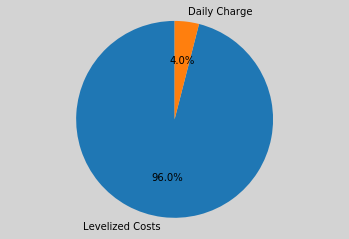

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.23711792586087, 173.0398899599673, 184.65216904332416, 13.700533596123439, 1.173876768394132, 1.927363332369584, 0.4096769128695162, 0.5262417820061922, 0.853105886897732, 3330.99, 321.976, 174.458, 0.0, 147.518, {'Levelized Costs': 3197.9379999999996, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602077019095, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (237.64955447183405, 255.1151495141479, 225.65234595302636, 23.99070854956369, 41.87344930151477, 33.49237296401464, 0.7179848928890611, 0.8420339101125639, 0.8609347381157777)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 238
                                           a tilt of 24.0
                                           and a gcr of 0.718


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.0105414390563965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.9
                                           and a gcr of 0.842


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6961824893951416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 33.5
                                           and a gcr of 0.861


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.736576557159424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 141s


ERROR:ga_logger:panel relevance: [336.766, 0.0, 0.0]


ERROR:ga_logger:Cost: 3477.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,478 per year


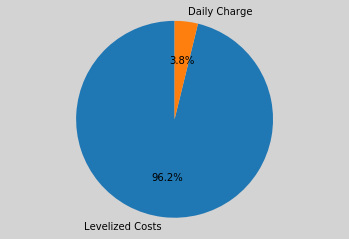

Total roof area of the  building: 599 m2
Total roof area used 469 m2
Percentage: 78.3%
succes
[[237.64955447183405, 255.1151495141479, 225.65234595302636, 23.99070854956369, 41.87344930151477, 33.49237296401464, 0.7179848928890611, 0.8420339101125639, 0.8609347381157777, 3477.89, 336.766, 336.766, 0.0, 0.0, {'Levelized Costs': 3344.8349999999996, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60170760279, 61845.7, 469.044]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215.70875798511327, 113.54517473190042, 198.43258097128407, 3.478987264381738, 4.889864570565095, 28.764245229448, 0.5034978068036801, 0.5898997518984714, 0.340025638349383)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 3.5
                                           and a gcr of 0.503


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.543656826019287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 4.9
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.363875150680542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 28.8
                                           and a gcr of 0.340


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6631696224212646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 287.664, 37.7814]


ERROR:ga_logger:Cost: 3365.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,365 per year


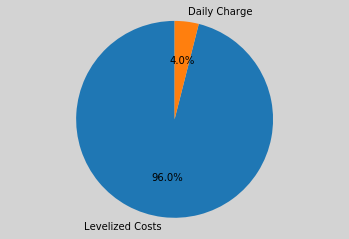

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[215.70875798511327, 113.54517473190042, 198.43258097128407, 3.478987264381738, 4.889864570565095, 28.764245229448, 0.5034978068036801, 0.5898997518984714, 0.340025638349383, 3365.44, 325.4454, 0.0, 287.664, 37.7814, {'Levelized Costs': 3232.3759999999997, 'Energy Charge': 0.022000000000275577, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60108932815, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (156.6178572200996, 192.28480712674002, 127.5076743553289, 55.95346061345558, 45.2722350691258, 34.883430044242495, 0.7417015853024655, 0.7775480717444733, 0.6829603669289696)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 157
                                           a tilt of 56.0
                                           and a gcr of 0.742


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5663115978240967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 45.3
                                           and a gcr of 0.778


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.455108404159546 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 128
                                           a tilt of 34.9
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4913992881774902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 180 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 324.485, 0.0]


ERROR:ga_logger:Cost: 3355.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


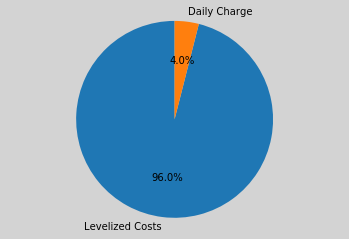

Total roof area of the  building: 599 m2
Total roof area used 417 m2
Percentage: 69.7%
succes
[[156.6178572200996, 192.28480712674002, 127.5076743553289, 55.95346061345558, 45.2722350691258, 34.883430044242495, 0.7417015853024655, 0.7775480717444733, 0.6829603669289696, 3355.91, 324.485, 0.0, 324.485, 0.0, {'Levelized Costs': 3222.852, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60271502388, 61845.7, 417.319]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150.9564976527704, 136.0596496915665, 100.0922417647518, 23.41951089957903, 2.44762033008535, 25.044541672172937, 0.28886393756021006, 0.5392324924583687, 0.2805918539872209)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 23.4
                                           and a gcr of 0.289


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.835050344467163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 136
                                           a tilt of 2.4
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.431954860687256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 25.0
                                           and a gcr of 0.281


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.463017702102661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 322.872, 0.0]


ERROR:ga_logger:Cost: 3520.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0029 /kWh
Total Cost of the system: $ 3,520 per year


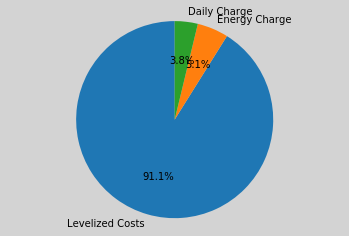

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[150.9564976527704, 136.0596496915665, 100.0922417647518, 23.41951089957903, 2.44762033008535, 25.044541672172937, 0.28886393756021006, 0.5392324924583687, 0.2805918539872209, 3520.16, 322.872, 0.0, 322.872, 0.0, {'Levelized Costs': 3206.83, 'Energy Charge': 180.28800000000018, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60406.811550877035, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (171.66109515323836, 211.98358935594393, 234.56645719575778, 6.0198408659297975, 50.28108243595741, 34.296661851254214, 0.5155389328030181, 0.6841588173456143, 0.6502289913346873)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 6.0
                                           and a gcr of 0.516


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5684847831726074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 212
                                           a tilt of 50.3
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5485129356384277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 34.3
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5093278884887695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 197 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 126s


ERROR:ga_logger:panel relevance: [261.136, 63.1012, 0.0]


ERROR:ga_logger:Cost: 3353.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,353 per year


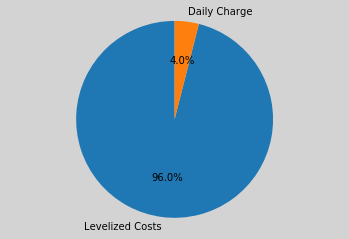

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[171.66109515323836, 211.98358935594393, 234.56645719575778, 6.0198408659297975, 50.28108243595741, 34.296661851254214, 0.5155389328030181, 0.6841588173456143, 0.6502289913346873, 3353.44, 324.23720000000003, 261.136, 63.1012, 0.0, {'Levelized Costs': 3220.377, 'Energy Charge': 0.020999999999958163, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600487084805, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.57862354152931, 90.70099859258488, 93.23079696684718, 1.9253054574688155, 13.364175674058611, 16.43570154765067, 0.35757013989165837, 0.20453870033545937, 0.5503687724311879)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 1.9
                                           and a gcr of 0.358


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6245946884155273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 13.4
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7122373580932617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 16.4
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.014076471328735 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 162 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 329.54]


ERROR:ga_logger:Cost: 3690.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0046 /kWh
Total Cost of the system: $ 3,690 per year


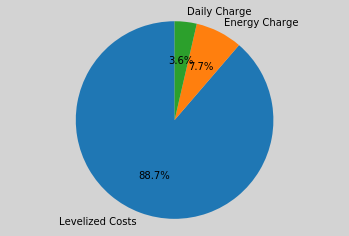

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[114.57862354152931, 90.70099859258488, 93.23079696684718, 1.9253054574688155, 13.364175674058611, 16.43570154765067, 0.35757013989165837, 0.20453870033545937, 0.5503687724311879, 3690.17, 329.54, 0.0, 0.0, 329.54, {'Levelized Costs': 3273.0480000000002, 'Energy Charge': 284.0800000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59578.53336798025, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (178.84941578493115, 217.32808645493125, 225.60535668353862, 8.096619177424934, 54.850950352630555, 15.680547785667175, 0.4617211562116985, 0.7548795736692309, 0.43379800446369615)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 8.1
                                           and a gcr of 0.462


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.574791431427002 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 54.9
                                           and a gcr of 0.755


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.577922821044922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 226
                                           a tilt of 15.7
                                           and a gcr of 0.434


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.600663185119629 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [179.319, 158.82, 0.0]


ERROR:ga_logger:Cost: 3491.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,492 per year


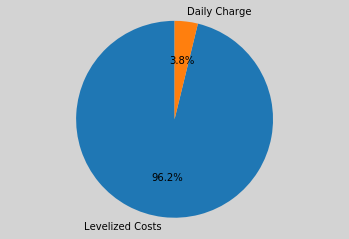

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[178.84941578493115, 217.32808645493125, 225.60535668353862, 8.096619177424934, 54.850950352630555, 15.680547785667175, 0.4617211562116985, 0.7548795736692309, 0.43379800446369615, 3491.52, 338.139, 179.319, 158.82, 0.0, {'Levelized Costs': 3358.464, 'Energy Charge': 0.013999999999953161, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5993057891, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.14672208212676, 206.51910125822246, 140.3131182364531, 2.612629252933072, 32.447623857248125, 14.291889290578807, 0.3078655934454392, 0.568767349415741, 0.24259281585154643)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 2.6
                                           and a gcr of 0.308


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4699647426605225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 207
                                           a tilt of 32.4
                                           and a gcr of 0.569


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5467066764831543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 14.3
                                           and a gcr of 0.243


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7099061012268066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 192 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [0.0, 306.619, 0.0]


ERROR:ga_logger:Cost: 3178.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,178 per year


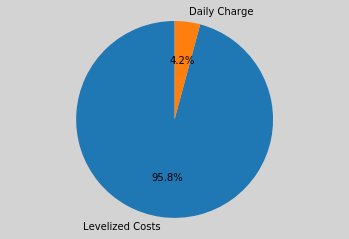

Total roof area of the  building: 599 m2
Total roof area used 539 m2
Percentage: 90.0%
succes
[[169.14672208212676, 206.51910125822246, 140.3131182364531, 2.612629252933072, 32.447623857248125, 14.291889290578807, 0.3078655934454392, 0.568767349415741, 0.24259281585154643, 3178.46, 306.619, 0.0, 306.619, 0.0, {'Levelized Costs': 3045.408, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60195022054, 61845.7, 539.094]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (171.07946108076763, 137.3320853801836, 245.31338872323184, 41.2150416195731, 47.01120596230607, 26.83763665840742, 0.8669148384447403, 0.6537545262038021, 0.6736243342998686)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 171
                                           a tilt of 41.2
                                           and a gcr of 0.867


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4659924507141113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 137
                                           a tilt of 47.0
                                           and a gcr of 0.654


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4534590244293213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 26.8
                                           and a gcr of 0.674


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4949264526367188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 165 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [328.357, 0.0, 0.0]


ERROR:ga_logger:Cost: 3394.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,394 per year


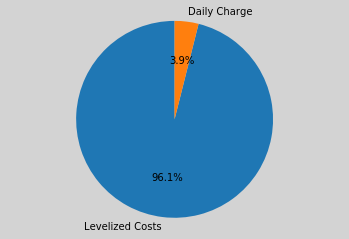

Total roof area of the  building: 599 m2
Total roof area used 379 m2
Percentage: 63.3%
succes
[[171.07946108076763, 137.3320853801836, 245.31338872323184, 41.2150416195731, 47.01120596230607, 26.83763665840742, 0.8669148384447403, 0.6537545262038021, 0.6736243342998686, 3394.36, 328.357, 328.357, 0.0, 0.0, {'Levelized Costs': 3261.302, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60127909977, 61845.7, 378.765]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (117.0338355941934, 121.02099221795551, 160.5305091412124, 32.29339795658074, 14.367560681821077, 1.0651881969430568, 0.5649267471124024, 0.6420083709492933, 0.3493585006961434)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 32.3
                                           and a gcr of 0.565


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5204226970672607 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 14.4
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4803948402404785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 1.1
                                           and a gcr of 0.349


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4774601459503174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 160 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 323.935, 0.0]


ERROR:ga_logger:Cost: 3350.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,350 per year


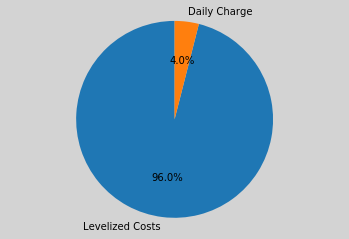

Total roof area of the  building: 599 m2
Total roof area used 505 m2
Percentage: 84.3%
succes
[[117.0338355941934, 121.02099221795551, 160.5305091412124, 32.29339795658074, 14.367560681821077, 1.0651881969430568, 0.5649267471124024, 0.6420083709492933, 0.3493585006961434, 3350.44, 323.935, 0.0, 323.935, 0.0, {'Levelized Costs': 3217.3799999999997, 'Energy Charge': 0.01800000000048385, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60263953997, 61845.7, 504.565]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (173.26683634353196, 187.25072822426768, 194.7330647027118, 33.79344403746489, 27.234178817703388, 25.97822773684549, 0.8029382110670731, 0.6660497424690733, 0.7180652225613824)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 173
                                           a tilt of 33.8
                                           and a gcr of 0.803


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.727933883666992 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 27.2
                                           and a gcr of 0.666


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6370036602020264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 26.0
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6179513931274414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 301.901, 0.0]


ERROR:ga_logger:Cost: 3131.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,132 per year


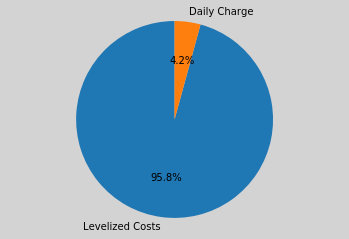

Total roof area of the  building: 599 m2
Total roof area used 453 m2
Percentage: 75.7%
succes
[[173.26683634353196, 187.25072822426768, 194.7330647027118, 33.79344403746489, 27.234178817703388, 25.97822773684549, 0.8029382110670731, 0.6660497424690733, 0.7180652225613824, 3131.6, 301.901, 0.0, 301.901, 0.0, {'Levelized Costs': 2998.542, 'Energy Charge': 0.01600000000013324, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60208295104, 61845.7, 453.271]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (102.68272693716497, 99.48376010868003, 184.45058899365526, 20.100623905040596, 19.03139689808749, 9.537126865534942, 0.5520108332851524, 0.266703027667243, 0.6389563047261879)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 20.1
                                           and a gcr of 0.552


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7659120559692383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 99
                                           a tilt of 19.0
                                           and a gcr of 0.267


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6301398277282715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 9.5
                                           and a gcr of 0.639


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7050282955169678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 174 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.676]


ERROR:ga_logger:Cost: 3248.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,249 per year


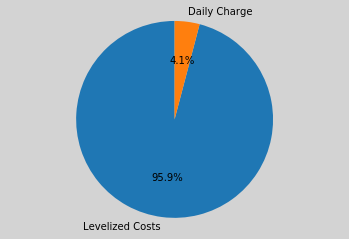

Total roof area of the  building: 599 m2
Total roof area used 491 m2
Percentage: 82.0%
succes
[[102.68272693716497, 99.48376010868003, 184.45058899365526, 20.100623905040596, 19.03139689808749, 9.537126865534942, 0.5520108332851524, 0.266703027667243, 0.6389563047261879, 3248.55, 313.676, 0.0, 0.0, 313.676, {'Levelized Costs': 3115.503, 'Energy Charge': 0.005000000000222826, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60189957845, 61845.7, 490.92]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (204.8995500777399, 237.3870070186796, 190.52467853135266, 35.4303146836222, 43.82408360546811, 23.18126281953024, 0.5688788942742341, 0.5459814496682167, 0.6731630095169725)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 35.4
                                           and a gcr of 0.569


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5778021812438965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 237
                                           a tilt of 43.8
                                           and a gcr of 0.546


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4643852710723877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 23.2
                                           and a gcr of 0.673


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.478393077850342 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 152s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.485]


ERROR:ga_logger:Cost: 3147.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,147 per year


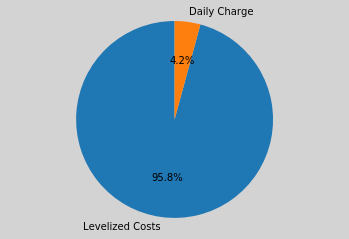

Total roof area of the  building: 599 m2
Total roof area used 451 m2
Percentage: 75.3%
succes
[[204.8995500777399, 237.3870070186796, 190.52467853135266, 35.4303146836222, 43.82408360546811, 23.18126281953024, 0.5688788942742341, 0.5459814496682167, 0.6731630095169725, 3147.33, 303.485, 0.0, 0.0, 303.485, {'Levelized Costs': 3014.2769999999996, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60071643, 61845.7, 450.834]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.3202476096237, 165.07264149787466, 119.19044210266927, 3.0446576254771696, 20.950882221677706, 6.7326628066849015, 0.31538562800778747, 0.45698144390140427, 0.4265229421208789)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 3.0
                                           and a gcr of 0.315


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2686045169830322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.457


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4402334690093994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 119
                                           a tilt of 6.7
                                           and a gcr of 0.427


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.391970634460449 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 179 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 273.623, 0.0]


ERROR:ga_logger:Cost: 3508.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0106 /kWh
Total Cost of the system: $ 3,508 per year


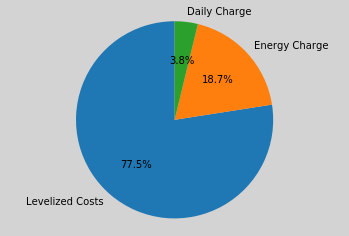

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.3202476096237, 165.07264149787466, 119.19044210266927, 3.0446576254771696, 20.950882221677706, 6.7326628066849015, 0.31538562800778747, 0.45698144390140427, 0.4265229421208789, 3508.26, 273.623, 0.0, 273.623, 0.0, {'Levelized Costs': 2717.6820000000002, 'Energy Charge': 657.5360000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56598.00023440003, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (97.94518024597097, 165.92762585579413, 198.54606339088113, 12.865344976902215, 37.574580510295746, 15.420440436669415, 0.40454620753592757, 0.4768272658388759, 0.5270200315865505)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 98
                                           a tilt of 12.9
                                           and a gcr of 0.405


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6379940509796143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 37.6
                                           and a gcr of 0.477


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5470077991485596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 15.4
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5822665691375732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 210 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 114.19, 189.349]


ERROR:ga_logger:Cost: 3147.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,148 per year


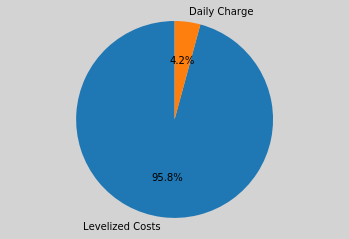

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[97.94518024597097, 165.92762585579413, 198.54606339088113, 12.865344976902215, 37.574580510295746, 15.420440436669415, 0.40454620753592757, 0.4768272658388759, 0.5270200315865505, 3147.87, 303.539, 0.0, 114.19, 189.349, {'Levelized Costs': 3014.809, 'Energy Charge': 0.01899999999989177, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60031883099, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (93.88889568687473, 165.92762585579413, 174.6873061937939, 13.748988266969384, 37.574580510295746, 16.433418647092893, 0.37065342871950646, 0.3633627897814602, 0.5270200315865505)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 13.7
                                           and a gcr of 0.371


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8426520824432373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 37.6
                                           and a gcr of 0.363


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7885167598724365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 16.4
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.757812261581421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [0.0, 29.2622, 273.118]


ERROR:ga_logger:Cost: 3136.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,136 per year


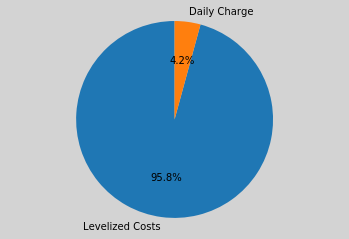

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[93.88889568687473, 165.92762585579413, 174.6873061937939, 13.748988266969384, 37.574580510295746, 16.433418647092893, 0.37065342871950646, 0.3633627897814602, 0.5270200315865505, 3136.35, 302.3802, 0.0, 29.2622, 273.118, {'Levelized Costs': 3003.3009999999995, 'Energy Charge': 0.007000000000402906, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602783782495, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (243.94357945455437, 186.41973698019834, 254.7897644091769, 45.68965145121693, 28.11350193610658, 50.177450689261256, 0.4432690811843452, 0.6959139453515228, 0.5882444289505568)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 244
                                           a tilt of 45.7
                                           and a gcr of 0.443


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4104104042053223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 28.1
                                           and a gcr of 0.696


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.419926166534424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 50.2
                                           and a gcr of 0.588


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4351353645324707 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 217 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [0.0, 303.403, 0.0]


ERROR:ga_logger:Cost: 3146.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,147 per year


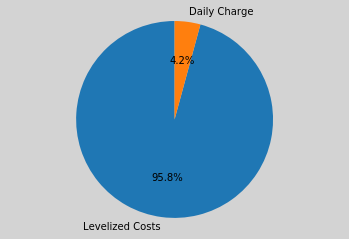

Total roof area of the  building: 599 m2
Total roof area used 436 m2
Percentage: 72.8%
succes
[[243.94357945455437, 186.41973698019834, 254.7897644091769, 45.68965145121693, 28.11350193610658, 50.177450689261256, 0.4432690811843452, 0.6959139453515228, 0.5882444289505568, 3146.51, 303.403, 0.0, 303.403, 0.0, {'Levelized Costs': 3013.453, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60033612183, 61845.7, 435.977]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (219.04999527573185, 172.3891951682899, 164.59737247595373, 42.93098378675048, 11.29851918802122, 11.181620576853831, 0.3436513171342385, 0.21572249290259937, 0.5604615447702402)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 219
                                           a tilt of 42.9
                                           and a gcr of 0.344


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.374063968658447 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 172
                                           a tilt of 11.3
                                           and a gcr of 0.216


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7267391681671143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 11.2
                                           and a gcr of 0.560


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.756474733352661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 158 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 124s


ERROR:ga_logger:panel relevance: [0.0, 15.3918, 295.594]


ERROR:ga_logger:Cost: 3221.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,222 per year


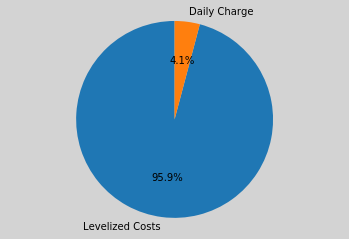

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[219.04999527573185, 172.3891951682899, 164.59737247595373, 42.93098378675048, 11.29851918802122, 11.181620576853831, 0.3436513171342385, 0.21572249290259937, 0.5604615447702402, 3221.83, 310.9858, 0.0, 15.3918, 295.594, {'Levelized Costs': 3088.7679999999996, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60274674974, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (164.68516345169274, 151.93720440380238, 231.37301157506116, 13.815337521927983, 9.869136872895819, 47.21083185177922, 0.32772315611974606, 0.8196525140609802, 0.5901220173462759)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 13.8
                                           and a gcr of 0.328


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6752986907958984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 9.9
                                           and a gcr of 0.820


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.565694570541382 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 47.2
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.586552858352661 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [117.287, 197.437, 0.0]


ERROR:ga_logger:Cost: 3258.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,259 per year


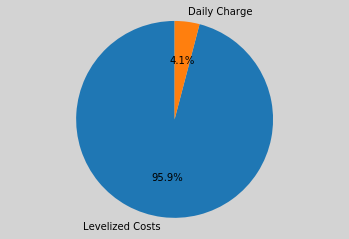

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[164.68516345169274, 151.93720440380238, 231.37301157506116, 13.815337521927983, 9.869136872895819, 47.21083185177922, 0.32772315611974606, 0.8196525140609802, 0.5901220173462759, 3258.95, 314.72400000000005, 117.287, 197.437, 0.0, {'Levelized Costs': 3125.8869999999997, 'Energy Charge': 0.021000000000299224, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600728195306, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155.70200980331364, 102.07136808791024, 232.54851791506016, 9.900187206238348, 7.223603852916895, 17.277192006125066, 0.36729824176778325, 0.323428384695014, 0.5257166995014559)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 9.9
                                           and a gcr of 0.367


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7912957668304443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 102
                                           a tilt of 7.2
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.678504705429077 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 17.3
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7445549964904785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 194 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.779]


ERROR:ga_logger:Cost: 3387.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0021 /kWh
Total Cost of the system: $ 3,388 per year


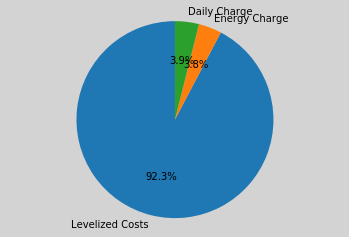

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[155.70200980331364, 102.07136808791024, 232.54851791506016, 9.900187206238348, 7.223603852916895, 17.277192006125066, 0.36729824176778325, 0.323428384695014, 0.5257166995014559, 3387.7, 314.779, 0.0, 0.0, 314.779, {'Levelized Costs': 3126.4539999999993, 'Energy Charge': 128.20400000000046, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60822.504072051415, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245.754255118247, 255.14010149275668, 226.69769606469185, 21.22684676917164, 44.751154376189305, 54.46389430845478, 0.5758052124478319, 0.6806668573187538, 0.3230257273130288)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 246
                                           a tilt of 21.2
                                           and a gcr of 0.576


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6023476123809814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 44.8
                                           and a gcr of 0.681


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.445385217666626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 227
                                           a tilt of 54.5
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.572504997253418 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 157 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [332.85, 0.0, 0.0]


ERROR:ga_logger:Cost: 3438.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,439 per year


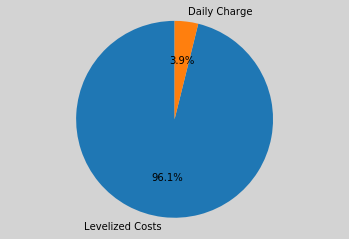

Total roof area of the  building: 599 m2
Total roof area used 578 m2
Percentage: 96.5%
succes
[[245.754255118247, 255.14010149275668, 226.69769606469185, 21.22684676917164, 44.751154376189305, 54.46389430845478, 0.5758052124478319, 0.6806668573187538, 0.3230257273130288, 3438.99, 332.85, 332.85, 0.0, 0.0, {'Levelized Costs': 3305.933, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60082525165, 61845.7, 578.06]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (151.92912412333632, 153.5386288587178, 166.18386775657197, 15.965902714041615, 14.992909573538661, 17.213070517314208, 0.33445249361076257, 0.5531576455793399, 0.2549152782306271)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 16.0
                                           and a gcr of 0.334


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6238293647766113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 15.0
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6412084102630615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 166
                                           a tilt of 17.2
                                           and a gcr of 0.255


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.496245861053467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 208 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 287.528, 20.1299]


ERROR:ga_logger:Cost: 3188.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,189 per year


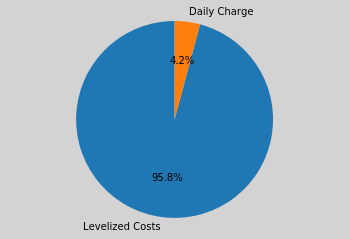

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[151.92912412333632, 153.5386288587178, 166.18386775657197, 15.965902714041615, 14.992909573538661, 17.213070517314208, 0.33445249361076257, 0.5531576455793399, 0.2549152782306271, 3188.78, 307.65790000000004, 0.0, 287.528, 20.1299, {'Levelized Costs': 3055.7239999999997, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602797910105, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.34422064616881, 226.83611990556642, 211.67923567726095, 44.10818365846306, 42.629618697345215, 30.68997035910326, 0.6174292581019847, 0.8229001128302142, 0.5877349827609017)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 44.1
                                           and a gcr of 0.617


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.637849807739258 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 227
                                           a tilt of 42.6
                                           and a gcr of 0.823


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.554166316986084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 212
                                           a tilt of 30.7
                                           and a gcr of 0.588


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.53827166557312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 207 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.234]


ERROR:ga_logger:Cost: 3214.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,214 per year


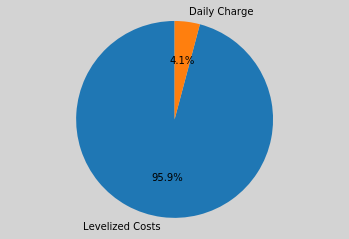

Total roof area of the  building: 599 m2
Total roof area used 528 m2
Percentage: 88.2%
succes
[[126.34422064616881, 226.83611990556642, 211.67923567726095, 44.10818365846306, 42.629618697345215, 30.68997035910326, 0.6174292581019847, 0.8229001128302142, 0.5877349827609017, 3214.37, 310.234, 0.0, 0.0, 310.234, {'Levelized Costs': 3081.313, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601426865054, 61845.7, 527.847]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (98.33901867574221, 134.40980461555813, 185.37600058011878, 12.447926394859568, 39.31833001563108, 22.805524905665365, 0.43479212557603664, 0.535496115542752, 0.6471714066132449)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 98
                                           a tilt of 12.4
                                           and a gcr of 0.435


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7498974800109863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 134
                                           a tilt of 39.3
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.445714235305786 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 22.8
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.532130718231201 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.218]


ERROR:ga_logger:Cost: 3124.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,125 per year


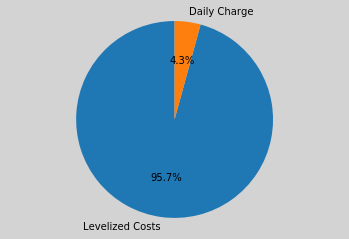

Total roof area of the  building: 599 m2
Total roof area used 465 m2
Percentage: 77.7%
succes
[[98.33901867574221, 134.40980461555813, 185.37600058011878, 12.447926394859568, 39.31833001563108, 22.805524905665365, 0.43479212557603664, 0.535496115542752, 0.6471714066132449, 3124.82, 301.218, 0.0, 0.0, 301.218, {'Levelized Costs': 2991.7639999999997, 'Energy Charge': 0.014000000000578439, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60066408707, 61845.7, 465.438]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (201.8957956402508, 220.99944677272953, 178.4418117211545, 46.12498714633782, 30.941616886425926, 42.05921812150731, 0.8614851237138171, 0.5077110838961524, 0.8023325385509779)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 202
                                           a tilt of 46.1
                                           and a gcr of 0.861


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.696415662765503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 221
                                           a tilt of 30.9
                                           and a gcr of 0.508


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4752249717712402 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 42.1
                                           and a gcr of 0.802


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5041613578796387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 216 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 287.089, 26.7209]


ERROR:ga_logger:Cost: 3249.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,250 per year


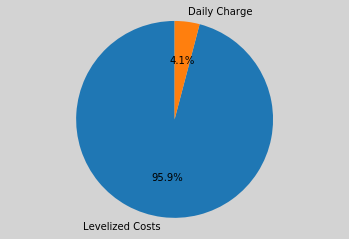

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[201.8957956402508, 220.99944677272953, 178.4418117211545, 46.12498714633782, 30.941616886425926, 42.05921812150731, 0.8614851237138171, 0.5077110838961524, 0.8023325385509779, 3249.88, 313.80989999999997, 0.0, 287.089, 26.7209, {'Levelized Costs': 3116.82, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60500715895, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.47997454485292, 100.90363457967715, 90.20282628982159, 20.359538605965955, 28.04700799746073, 33.66444966492851, 0.23639323161453074, 0.7597590310098944, 0.6684115392948906)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 20.4
                                           and a gcr of 0.236


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.700909376144409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 101
                                           a tilt of 28.0
                                           and a gcr of 0.760


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5682179927825928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 33.7
                                           and a gcr of 0.668


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6672158241271973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [40.628, 324.338, 0.0]


ERROR:ga_logger:Cost: 3757.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,758 per year


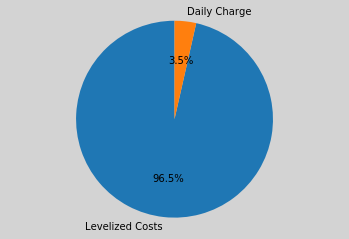

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[130.47997454485292, 100.90363457967715, 90.20282628982159, 20.359538605965955, 28.04700799746073, 33.66444966492851, 0.23639323161453074, 0.7597590310098944, 0.6684115392948906, 3757.97, 364.966, 40.628, 324.338, 0.0, {'Levelized Costs': 3624.9159999999997, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60141039997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (257.82404804779674, 234.5618114504013, 192.1103868089734, 43.366967830060915, 6.321144267926454, 4.904251539131879, 0.26356078945118383, 0.5508820547901675, 0.7277293136862062)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 43.4
                                           and a gcr of 0.264


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6116907596588135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 6.3
                                           and a gcr of 0.551


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.187601327896118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 4.9
                                           and a gcr of 0.728


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.512970447540283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 323.678]


ERROR:ga_logger:Cost: 3347.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,348 per year


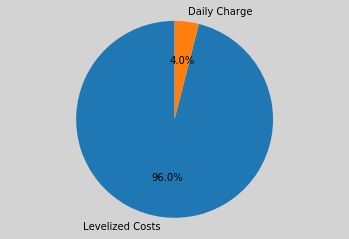

Total roof area of the  building: 599 m2
Total roof area used 445 m2
Percentage: 74.3%
succes
[[257.82404804779674, 234.5618114504013, 192.1103868089734, 43.366967830060915, 6.321144267926454, 4.904251539131879, 0.26356078945118383, 0.5508820547901675, 0.7277293136862062, 3347.9, 323.678, 0.0, 0.0, 323.678, {'Levelized Costs': 3214.8469999999998, 'Energy Charge': 0.011000000000535692, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60246229334, 61845.7, 444.779]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (194.99336278952245, 162.55234649223817, 134.15288787683568, 25.570172608364672, 20.228809495904667, 2.9137121033029216, 0.24017442859349383, 0.43223443505639786, 0.6557491206179918)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 25.6
                                           and a gcr of 0.240


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.599318504333496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 20.2
                                           and a gcr of 0.432


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4160854816436768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 134
                                           a tilt of 2.9
                                           and a gcr of 0.656


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3415486812591553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 203 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 150.942, 163.641]


ERROR:ga_logger:Cost: 3257.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,258 per year


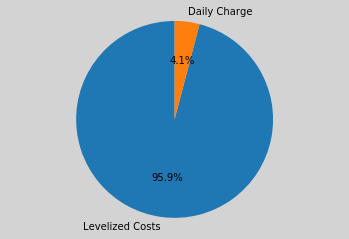

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[194.99336278952245, 162.55234649223817, 134.15288787683568, 25.570172608364672, 20.228809495904667, 2.9137121033029216, 0.24017442859349383, 0.43223443505639786, 0.6557491206179918, 3257.56, 314.58299999999997, 0.0, 150.942, 163.641, {'Levelized Costs': 3124.507, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601110396805, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (264.0418706120298, 185.66214871288986, 201.2980916733328, 53.031219719343134, 33.75754761062069, 43.18660911328482, 0.6724612541174756, 0.6816549475051439, 0.8826251742106124)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 53.0
                                           and a gcr of 0.672


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6055078506469727 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 186
                                           a tilt of 33.8
                                           and a gcr of 0.682


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.68512225151062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 201
                                           a tilt of 43.2
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.519587516784668 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 303.954, 0.0]


ERROR:ga_logger:Cost: 3151.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,152 per year


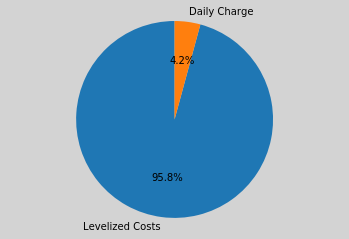

Total roof area of the  building: 599 m2
Total roof area used 446 m2
Percentage: 74.5%
succes
[[264.0418706120298, 185.66214871288986, 201.2980916733328, 53.031219719343134, 33.75754761062069, 43.18660911328482, 0.6724612541174756, 0.6816549475051439, 0.8826251742106124, 3151.99, 303.954, 0.0, 303.954, 0.0, {'Levelized Costs': 3018.9339999999997, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60162994575, 61845.7, 445.905]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (237.47358240825838, 94.71281352515504, 157.6180888632224, 18.578069602160603, 53.15331179466294, 25.863908889868412, 0.49610319394487157, 0.5969674482008436, 0.734019954932715)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 237
                                           a tilt of 18.6
                                           and a gcr of 0.496


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9210283756256104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 53.2
                                           and a gcr of 0.597


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.475700616836548 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 158
                                           a tilt of 25.9
                                           and a gcr of 0.734


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.499481201171875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.863]


ERROR:ga_logger:Cost: 3230.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,231 per year


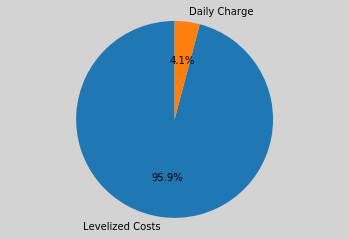

Total roof area of the  building: 599 m2
Total roof area used 425 m2
Percentage: 71.0%
succes
[[237.47358240825838, 94.71281352515504, 157.6180888632224, 18.578069602160603, 53.15331179466294, 25.863908889868412, 0.49610319394487157, 0.5969674482008436, 0.734019954932715, 3230.54, 311.863, 0.0, 0.0, 311.863, {'Levelized Costs': 3097.4889999999996, 'Energy Charge': 0.009000000000298769, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599831800115, 61845.7, 424.87]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (154.62244544101645, 202.52590633709775, 222.10540315149117, 39.54971086437924, 43.385692146717616, 49.66468897162738, 0.7917609086623065, 0.6726000208782524, 0.2459743949041125)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 39.5
                                           and a gcr of 0.792


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.264596700668335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 203
                                           a tilt of 43.4
                                           and a gcr of 0.673


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5363733768463135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 49.7
                                           and a gcr of 0.246


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.644932270050049 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 320.91, 0.0]


ERROR:ga_logger:Cost: 3320.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,320 per year


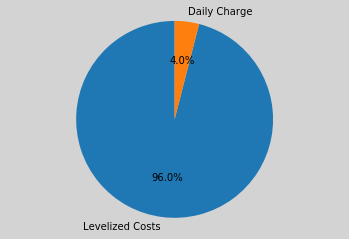

Total roof area of the  building: 599 m2
Total roof area used 477 m2
Percentage: 79.7%
succes
[[154.62244544101645, 202.52590633709775, 222.10540315149117, 39.54971086437924, 43.385692146717616, 49.66468897162738, 0.7917609086623065, 0.6726000208782524, 0.2459743949041125, 3320.4, 320.91, 0.0, 320.91, 0.0, {'Levelized Costs': 3187.343, 'Energy Charge': 0.015000000000270575, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60216484506, 61845.7, 477.118]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (103.80814036378264, 161.9831165652882, 163.52781111293768, 15.894381994228693, 32.62761197555625, 23.66519619208367, 0.3169236392111012, 0.4108714241505168, 0.23058262935778076)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 104
                                           a tilt of 15.9
                                           and a gcr of 0.317


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.574125051498413 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 162
                                           a tilt of 32.6
                                           and a gcr of 0.411


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.484916925430298 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 23.7
                                           and a gcr of 0.231


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7191944122314453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [0.0, 246.014, 0.0]


ERROR:ga_logger:Cost: 3875.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0210 /kWh
Total Cost of the system: $ 3,876 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[103.80814036378264, 161.9831165652882, 163.52781111293768, 15.894381994228693, 32.62761197555625, 23.66519619208367, 0.3169236392111012, 0.4108714241505168, 0.23058262935778076, 3875.88, 246.014, 0.0, 246.014, 0.0, {'Levelized Costs': 2443.458, 'Energy Charge': 1299.38, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51475.57004090017, 61845.7, 598.762]]


ERROR:optimizer_logger:200


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 9 using opt-method ga-100 with 200 evalautions took: (min)


ERROR:Runs_logger:1579.7721943656604


In [29]:
# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE")
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)